# Predicting the standard map

The notebook is structured as follows:

+ [$\text{1. Intuition on the Standard Map}$](#StandardMap)
+ [$\text{2. Training an echo states network}$](#TrainingNetwork)
    + [$\text{2.1 K=0}$](#K0)
    + [$\text{2.2 K=0.1}$](#K01)
    + [$\text{2.3 K=0.25}$](#K025)
    + [$\text{2.4 K=0.5, 0.75, 0.9}$](#Kmult)
    + [$\text{2.5 Chaotic behavior}$](#Kchaos)
+ [$\text{3. Other trials with poor performance or too much computational cost}$](#FailedTrials)
    + [$\text{3.1 Parameters of the reservoir}$](#Params)
        + [$\text{3.1.1 Spectral radius}$](#SpectralRadius)
        + [$\text{3.1.2 Number of nodes}$](#NumNodes)
    + [$\text{3.2 Role played by the input}$](#AddInput)
    + [$\text{3.3 Role played by the noise}$](#AddNoise)
    + [$\text{3.4 Formula for updating the reservoir}$](#UpdRes)
    + [$\text{3.5 Formula for obtaining the output}$](#ObtOut)
        + [$\text{3.5.1 Output as a linear combination}$](#LinComb)
        + [$\text{3.5.2 Output as a polynomial of degree 3}$](#Poly3)
    + [$\text{3.6 Loss function}$](#Loss)


The main goal of [Section 1](#StandardMap) is to provide an intuition of the dynamics of the Standard Map. That is, we explain how it is constructed and analyze different behaviors according to the degree of chaos. Moreover, we illustrate the latter by plotting the phase space under different levels of chaos. 

In [Section 2](#TrainingNetwork), we are going to train a network whose parameters were chosen by us. We begin by setting the training task, which involves determining the parameters as well as the training and testing formulas. Afterwards, we implement the previously discussed strategy in a particular case in order to illustrate its performance. Next, we analyze whether the followed approach is still valid for other cases, that is, for other initial conditions and other levels of chaos.

As already mentioned, [Section 2](#TrainingNetwork) shows the best performance we were able to obtain by tunning all the different components of the network as well as the training. Therefore, [Section 3](#FailedTrials) provides an overview of the different strategies we tried before reaching the best result. Such approaches are worthy to mention and study since, although they may had not worked in this particular case of study, they belong to the set of typical tunning strategies. 

#  1. Intuition on the Standard Map <a name="StandardMap" ></a>

The *Chirikov standard map* (or simply *standard map*) is an area-preserving map  

$$
\begin{alignat*}{3}
F:[0,2\pi]&\times[0,2\pi]\times \mathbb{R} &&\rightarrow [0,&&2\pi]\times[0,2\pi]\\
&(p,\theta,t) &&\mapsto &&F(p,\theta,t)
\end{alignat*}
$$

defined by means of the following differential equation

$$
\begin{cases}
\dot{p} &= p+K\sin(\theta)\\
\dot{\theta} &=\theta+\dot{p}
\end{cases},
$$

where $\theta$ and $p$ determine the angular position and the angular momentum. The parameter $K$ is a non-negative scalar giving the degree of chaos. When $K=0$, the orbits are linear. Then, as this value increases,  periodic and quasi-periodic orbits appear. Finally, if we increase the value even more, so does the probability of observing chaotic dynamics for the appropriate initial conditions. In this section, we are going to plot the phase space for different values of $K$ so as to actually check this behavior. 

This map is generated by the Hamiltonian 

$$
H(p,\theta,t)= \frac{p^2}{2}+K\cos(\theta)\delta_1(t),
$$

where $\delta_1(t)$ is a periodic $\delta-$function with period 1 in time.

In our study, we are not going to use the continuous EDO but its discrete version, which is

$$
\begin{cases}
p_{n+1} &= p_n+K\sin(\theta_n)\\
\theta_{n+1} &=\theta_n+p_{n+1}
\end{cases},
$$

where $p_n$ and $\theta_n$ are taken modulo $2\pi$. Therefore, we are regarding $F$ to be defined on the torus.

The standard map describes the dynamics followed by a *kicked rotator*. A *kicked rotator* is usually imagined as a particle constrained to move on a circle in a system with no friction nor gravity that is periodically kicked. Thus, its parameters are:
* $\theta$, which gives the angular position within the circle. It is measured in radians.
* $p$, which gives its angular momentum. It can be positive or negative, where positive indicates counter-clockwise motion and negative indicates clockwise motion. 
* $K$, which stands for kick strength. For low kick strengths, the particle motion is fairly regular. However, if the kicks are strong enough, $K>K_c\approx 0.971635\dots$  the system becomes chaotic and has a positive Maximal Lyapunov exponent (MLE).

The particle starts out at a random position on the circle with a random initial momentum and is periodically kicked by an "homogeneous field". Depending on the position the particle is located within the circle, the kick affects the particle's motion differently. In particular, in order to compute how effective the kick is at a certain position $\theta$, its value $K$ is multiplied by $\sin(\theta)$.

## Phase space

Let us now visualize the phase space for different values of $K$. The orbits are going to be computed by means of the discrete and recurrent approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_nextpoint_orbit(theta, p, K):
    """
    Given the tuple (theta, p) and K, it returns the tuple (theta_next, p_next) corresponding to the next 
    time step.
    The computations are performed by means of the discrete approach.
    """
    
    p_next = np.mod(p + K*np.sin(theta), 2*np.pi)
    theta_next = np.mod(theta + p_next, 2*np.pi)
    
    return (theta_next, p_next)

In [3]:
def phase_space(K_list, points_orbit=200, theta_initial_points=7, p_initial_points=8):
    """
    Inputs:
    -K_list, list giving the values of K for which we want to compute the phase space
    -points_orbit, number of points to be computed for each orbit
    -theta_initial_points, number of linearly spaced points in [0, 2*pi] to be considered as the theta coordinate
    for the initial condition
    -p_initial_points, number of linearly spaced points in [0, 2*pi] to be considered as the theta coordinate
    for the initial condition
    
    Outputs:
    -plot illustrating the phase space for the given values of K.
    """
    
    theta_initial = list(np.linspace(0, 2*np.pi, theta_initial_points))
    p_initial = list(np.linspace(0, 2*np.pi, p_initial_points))
    mesh = np.array(np.meshgrid(theta_initial, p_initial))
    combination = mesh.T.reshape(-1, 2)
    list_initial_points = list(map(tuple, combination))
    
    for K in K_list:
        fig = plt.figure(figsize=(7, 7))            
        for initial_point in  list_initial_points:
            trajectory_theta = [initial_point[0]]
            trajectory_p = [initial_point[1]]
        
            for points in np.arange(points_orbit):
                new_points = compute_nextpoint_orbit(trajectory_theta[-1], trajectory_p[-1], K)
                trajectory_theta.append(new_points[0])
                trajectory_p.append(new_points[1])
            plt.plot(trajectory_theta, trajectory_p, '.')        
        
        plt.title('Phase space for K={}'.format(K))
        plt.xlabel('theta (position)')
        plt.ylabel('p (momentum)') 
        plt.show()

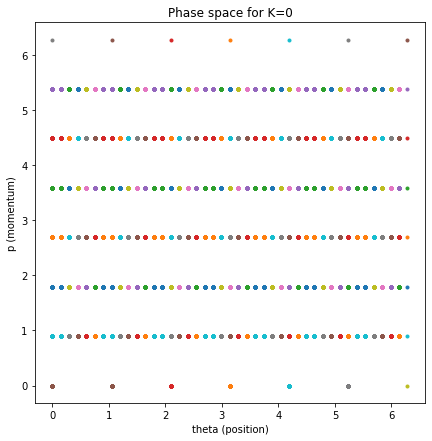

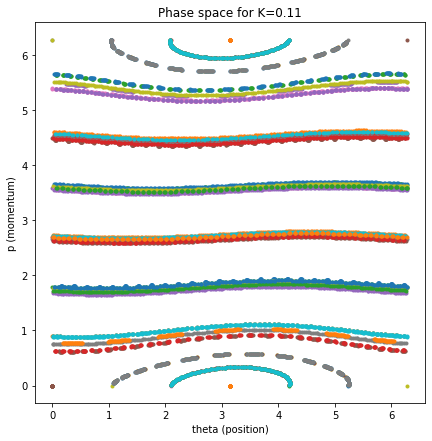

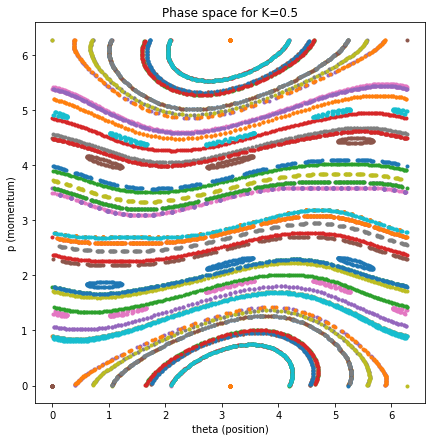

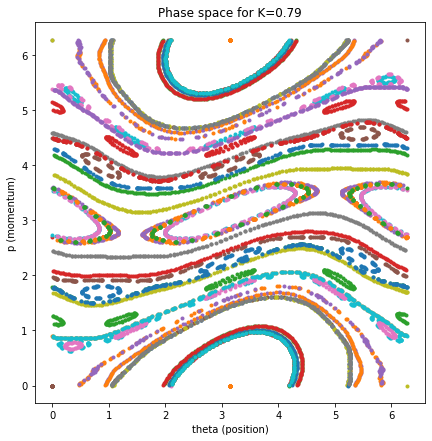

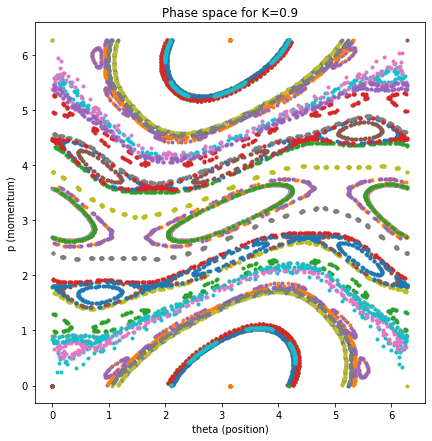

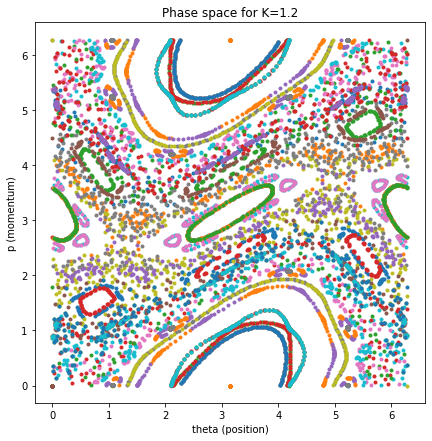

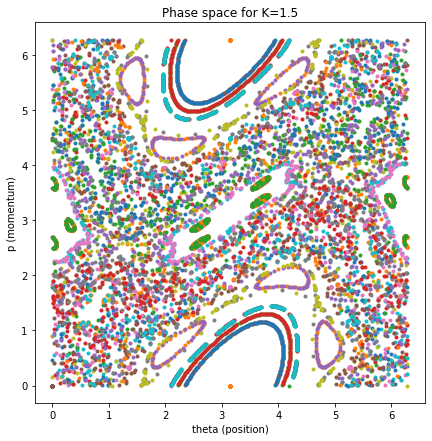

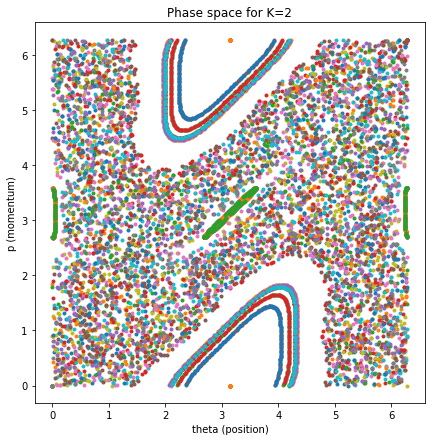

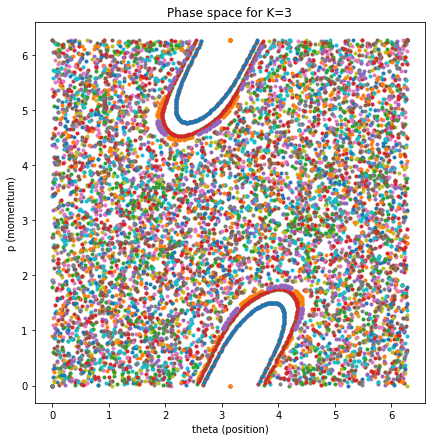

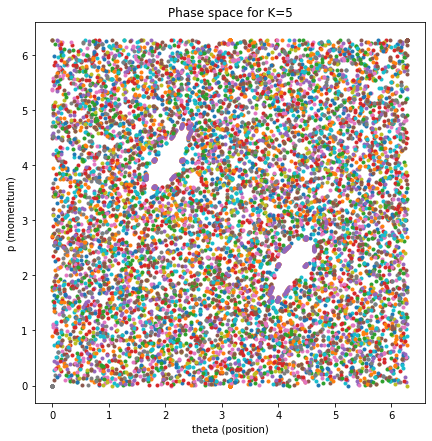

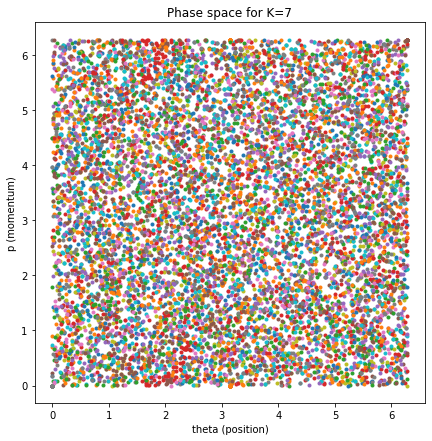

In [4]:
phase_space([0, 0.11, 0.5, 0.79, 0.9, 1.2, 1.5, 2, 3, 5, 7])

Notice that, when $K=0$, each trajectory is a set of points that lie on the same line. The reason is that, in such case, the trajectories' dynamics are as follows

$$
\begin{cases}
p_{n+1} &= p_n\\
\theta_{n+1} &=\theta_n+p_{n+1}
\end{cases}.
$$

So, the value of $p$ is constant and the value of $\theta$ is proportional to $p$ (module 2$\pi$). As the value of $K$ increases, quasi-periodic and periodic orbits appear ($K=0.11,0.5,0.79,0.9$). When the value of $K$ reaches 0.9, we observe trajectories that seem to be slightly chaotic. This would be the case of the light blue and pink curves. For $K=1.2$, such chaotic trajectories are easier to distinguish. That is, we see a wide range of the space filled with points of different colors. Finally, it is clear that, as the value of $K$ keeps increasing, so does the probability of finding chaotic trajectories. 

**DO NOT GET CONFUSED BY THE COLORS.** Notice that, in the above images, we are showing 56 orbits. Since it is very difficult to use 56 different colors, some colors may be repeated to illustrate different orbits. On the other hand, the same color may depict different chunks of the same orbit. For instance, look at the phase space when $K=0.79$. If we look at the five red circles located quite above, they all belong to the same trajectory. However, the red curve that is below them corresponds to a different orbit. 

## Particular orbits

Let us now define a function that, instead of computing the whole phase space, it computes the orbits for a particular set of initial conditions for the desired values of *K*. We will then run the function taking the same values of $K$ as above. By doing so we will actually check that trajectories with the same color in the phase space do not necessarily correspond to the same orbit. Moreover, we will analyze the evolution of a particular set of trajectories for different values of $K$.

In [5]:
def orbit(K_list, initial_conditions, points_orbit=200, legend=True):
    """
    Inputs:
    -K_list, list giving the values of K for which we want to compute the phase space
    -initial_conditions, list giving the tuples of initial conditions to be considered
    -points_orbit, number of points to be computed for each orbit  
    -legend, whether we want to print the legend of the plot
    
    Outputs:
    -plot illustrating the orbits for the given initial conditions and the given values of K.
    """
    
    for K in K_list:
        fig = plt.figure(figsize=(7, 7))            
        for initial_point in initial_conditions:
            trajectory_theta = [initial_point[0]]
            trajectory_p = [initial_point[1]]
            
            for points in np.arange(points_orbit):
                new_points = compute_nextpoint_orbit(trajectory_theta[-1], trajectory_p[-1], K)
                trajectory_theta.append(new_points[0])
                trajectory_p.append(new_points[1])
            plt.plot(trajectory_theta, trajectory_p, '.', label=initial_point)        
                
        plt.title('Phase space for K={}'.format(K))
        plt.xlabel('theta (position)')
        plt.ylabel('p (momentum)') 
        if legend == True:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='INITIAL CONDITIONS')
        plt.show()

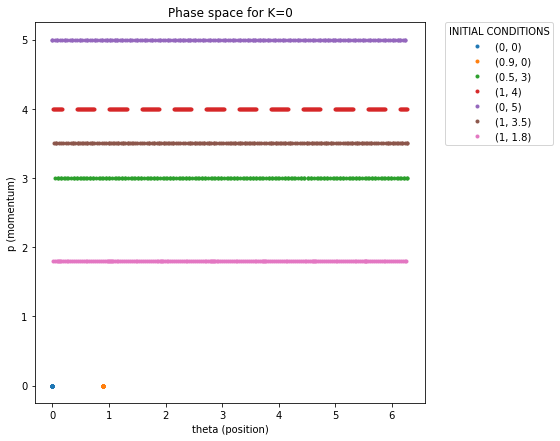

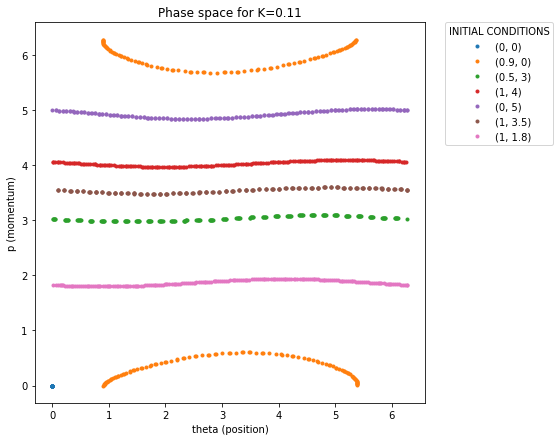

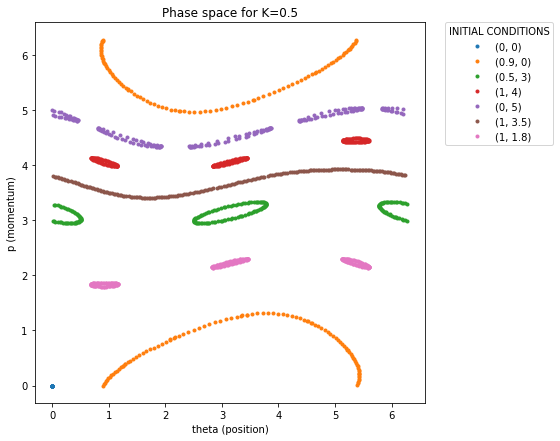

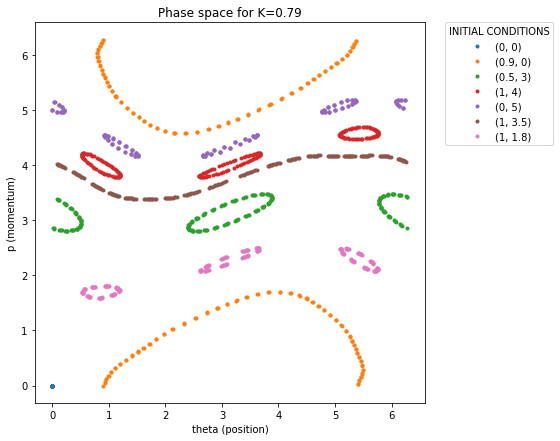

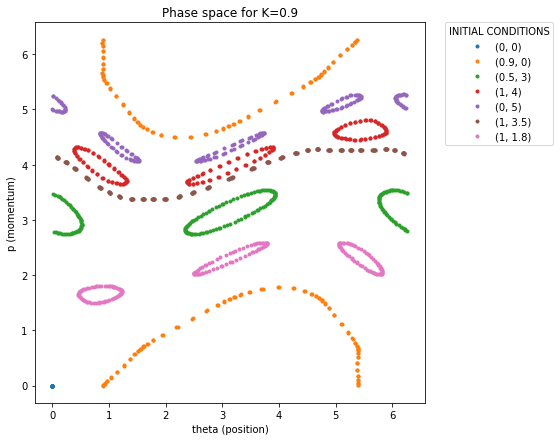

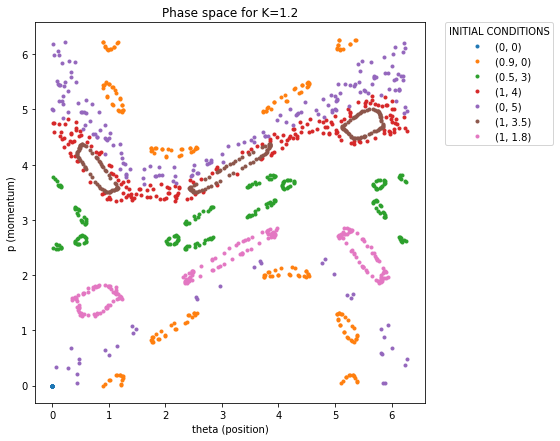

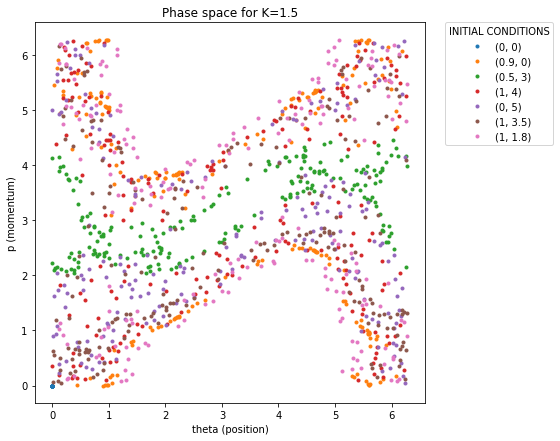

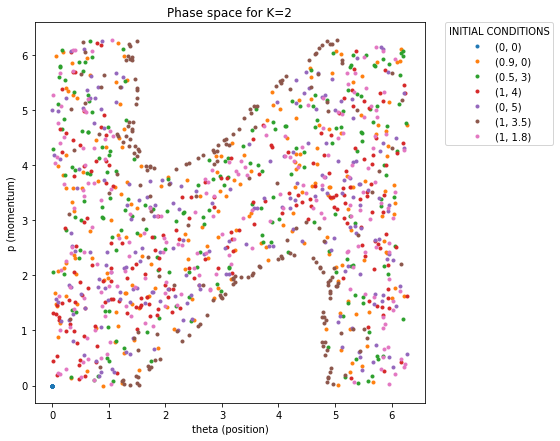

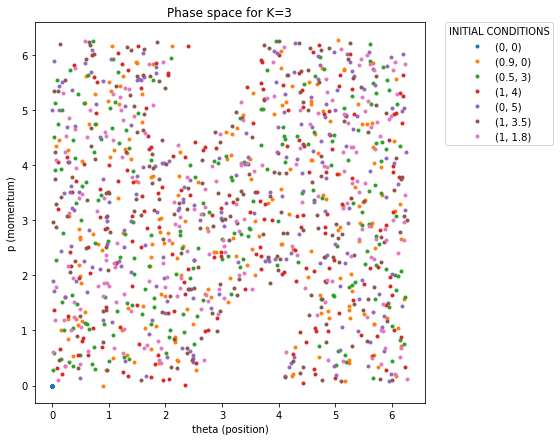

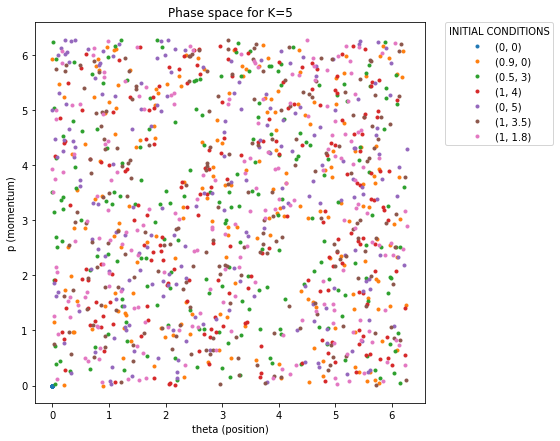

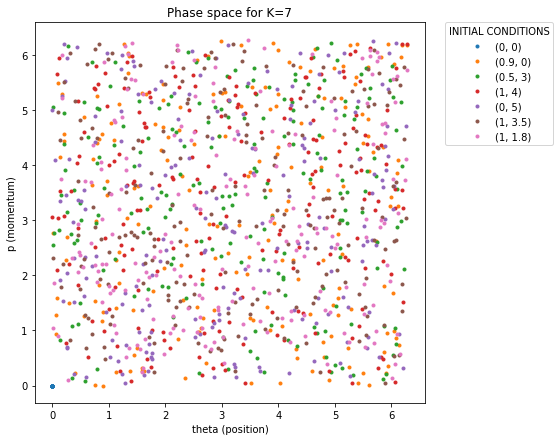

In [6]:
orbit(K_list=[0, 0.11, 0.5, 0.79, 0.9, 1.2, 1.5, 2, 3, 5, 7], 
      initial_conditions=[(0,0),(0.9,0), (0.5,3), (1,4), (0,5), (1,3.5), (1,1.8)])

Since the colors of the trajectories are the same through the different plots, we can easily compare their behavior according to the value of $K$. On the one hand, notice that (0,0) is a fixed point (for any value of $K$). On the other hand, we observe that, as $K$ increases, lines ($K=0$) become curves $(K=0.11)$. Then, curves are turned into circles. Such circles are then splitted into more circles (like the orange and green ones when $K=1.2$). Finally, the trajectories are a chaotic set of points ($K=1.5$). The degree of chaos increases as $K$ increases.

# 2. Training an echo states network <a name="TrainingNetwork" ></a>


Let us now train an echo states network in order to predict the orbit of a standard map. As we have seen in [Section 1](#StandardMap), the dynamics of a standard map is given by the *angular position* ($\theta$) and the *angular momentum* ($p$). Therefore, the output at time *n* is going to be a two dimensional vector of the form

$$
y_\text{teach}(n)^{\scriptsize T}=(\theta(n),p(n)).
$$

The parameters of the network are:
* $W\in M_{N\times N}(\mathbb{R})$
* $W^\text{back}\in M_{N\times 2}(\mathbb{R})$
* $W^\text{in}\in M_{N\times 1}(\mathbb{R})$
* $W^\text{out}\in M_{2\times N}(\mathbb{R})$, which has to be learnt
* $u(n)\in M_{1\times 1}(\mathbb{R})$ for all $n$
* $y^\text{teach}\in M_{2\times T}(\mathbb{R})$
* $y(n)\in M_{2\times 1}(\mathbb{R})$ for all $n$
* $\nu\in M_{N\times T}(\mathbb{R})$

where $N$ the number of nodes of the reservoir, $T$ the number of training time steps and $\nu$ is some noise introduced during training.

In our case of study, we will deal with a reservoir composed by 3000 nodes. Such nodes are going to be randomly connected taking weights equal to 0, 0.4 and -0.4 with probabilities 0.9875, 0.00625 and 0.00625 respectively. Therefore, we will only regard 1.25% of connections. Finally, such weights are going to be rescaled in order to obtain an adjacency matrix with an spectral radius of 1.35. 

The matrix giving the feedback connections is going to be constructed by randomly taking uniformly distributed numbers within the interval [-0.56,0.56]. In addition, we will also input a constant value of 0.5 in order to encourage even more a wider variety of dynamics. Its matrix of connections will take values 0, 0.7 and -0.7 with probabilities 0.5, 0.25 and 0.25 respectively.

Finally, the network is going to be trained for 5000 time steps from which the initial 500 are going to be discarded due to the input and state forgetting property. 

As we already stated in [Section 1](#StandardMap), the position of a particle following the dynamics given by the standard map at time $n$ is 

$$
y_\text{teach}(n)^{\scriptsize T}=(\theta(n+1),p(n+1)),
$$

where the values of $p$ and $\theta$ are recurrently computed as 

$$
\begin{cases}
p_{n+1} &= p_n+K\sin(\theta_n)\\
\theta_{n+1} &=\theta_n+p_{n+1}
\end{cases},
$$

where $p_n$ and $\theta_n$ are taken modulo $2\pi$. Therefore, $(p_n, \theta_n)\in[0,2\pi]\times[0,2\pi]$ for all $n$. As we are now going to see, the activation function of the network's output is going to be a $\tanh$. Therefore, we cannot obtain values whose modules are greater than 1. That is the reason why the sequence to be learnt is going to be squashed into [-1,1]. In particular, we will squash it into [-0.5,0.5] in order to guarantee that they belong to the linear part of the $\tanh$ function. Let $y_\text{teach}$ be defined as above. That is, it gives the trajectory of a particle following the standard map trajectory in such a way that its values of $p$ and $\theta$ belong to the interval $[0,2\pi]$. Then, we are going to squash it and, afterwards, redefine it as follows

$$
y_\text{teach} := \frac{y_\text{teach}}{2\pi}-0.5.
$$

Notice that such squashing is performed component-wise. Therefore, unless we specify the contrary, $y_\text{teach}$ is going to denote the squashed version of the trajectory.

Let us now explain how the training and testing is going to be carried out. The formulas are provided below.

${\small \text{  }}$




${\underline{\small \text{TRAINING}}}$

The update of the reservoir is going to be performed by means of teacher forcing as follows:

$$
x(n+1)=\tanh\left(W^\text{in}u(n)+Wx(n)+W^\text{back}y^\text{teach}[:,n]+\nu[:,n]\right),
$$

where we are going to take $\nu$ as a centered Gaussian noise with standard deviation of 0.001.

Recall that in the experiments we carried out so far (in the previous notebooks), the output of the network was computed as a linear combination of the internal states of the reservoir. That is, the output was computed as

$$
y(n) = W^\text{out}x(n),
$$

where $W^\text{out}\in M_{L\times N}(\mathbb{R})$ was the matrix to be learnt. However, in this case of study we will slightly modify such approach in order to get more accurate outputs. The strategy we will be following is:

$$
y(n) = W^\text{out}\tilde{x}(n),
$$

where 

$$
\tilde{x}(n):=\begin{pmatrix}x(n)_{1:\frac{N}{2}}\\x(n)^2_{\frac{N}{2}+1:N}\end{pmatrix}
$$

stands for the vertical concatenation of vectors $x(n)_{1:\frac{N}{2}}$ and $x(n)^2_{\frac{N}{2}+1:N}$. In addition, the notation of $x(n)_{a:b}$ represents the slice of vector $x(n)$ from component $a$ to component $b$. Therefore, the above vector stands for the first half of $x(n)$ whereas the below one stands for the second half of $x(n)$ to the square.

The learning will consist on a *ridge regression* instead of the classical linear regression. Thus, we will need to minimize the following function 

$$
\text{RIDGE} = ||\tanh^{-1}\left(y^\text{teach}\right)-W^\text{out}\tilde{x}||_2^2+\alpha||W^\text{out}||_2^2,
$$

where $y^\text{teach}\in M_{2\times (T-n_\text{min})}(\mathbb{R})$, $W^\text{out}\in M_{2\times N}(\mathbb{R})$ and $\tilde{x}\in M_{N\times (T-n_\text{min})}(\mathbb{R})$. Recall that $T$ is the number of time steps considered and $n_\text{min}$ is the number of discarded time steps. In addition, we will take $\alpha$=10.

${\small \text{  }}$




${\underline{\small \text{TESTING}}}$

When testing the network, the update will depend on the output produced by the network itself:

$$
\begin{align*}
x(n+1)&=\tanh\left(W^\text{in}u(n)Wx(n)+W^\text{back}y(n)\right)\\
y(n+1)&=\tanh\left(W^\text{out}\tilde{x}(n+1)\right)
\end{align*}.
$$

However, before letting the network freely run, we need to perform a few time steps of teacher forcing in order to let the internal states of the reservoir converge. In the function we are going to implement in order to perform the testing, there is a parameter called *t_dismiss*, that specifies the number of teacher forcing steps and, then, *t_autonom*, which gives the number of time steps the network is going to freely run.

As explained in the notebook "MackeyGlass.ipynb", a good metrics to measure the performance of the trained network when dealing with chaotic dynamics is the $\text{NRMSE}_{84}$. In this case of study, it will be defined component-wise as

 $$
 \text{NRMSE}_{84, i} = \left(\frac{\sum_{n=1}^{50} \left(y[i,n\cdot 1000 + n\cdot 84]-y^\text{teach}[i,n\cdot 1000 +   n\cdot 84]\right)^2}{50\,\sigma_i^2}\right)^\frac{1}{2} \quad \text{for $i\in\{1,2\}$},
 $$

 where $\sigma^2_i$ is the variance of the original signal regarding the $i$-th component. **Recall that this metrics is computed by means of the original values, which belong to the interval $\boldsymbol{[0,2\pi]\times[0,2\pi]}$. That is, without squashing them.** Therefore, at this point, the squashing needs to be reverted:

$$
\begin{align*}
y &:= 2\pi\cdot(y+0.5)\\
y_\text{teach} &:= 2\pi\cdot(y_\text{teach}+0.5)
\end{align*}
$$ 
 
Finally, recall that the value of $\sigma^2_i$ is computed from the original (non-squashed) values as follows

$$
\sigma^2_i = \text{E}\left[\left(y^\text{teach}_i\right)^2\right]-\text{E}\left[y^\text{teach}_i\right]^2,
$$

where the expectation is empirically approximated by the mean.

${\small \text{  }}$




${\underline{\small \text{NOTE ON THE PARAMETERS}}}$

All the parameters of this network, which include the introduction of input and noise, the number of nodes and the spectral radius of the reservoir, the formulas for updating the reservoir and for obtaining the output of the network, among others, were chosen by means of trial and error. In [Section 3](#FailedTrials), we can see other strategies implemented that did not work or that did not work as well as the ones stated in this current section.

In [ ]:
#restart the kernel
import os
os._exit(00)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import pdb

In [2]:
def esc(code):
    return f'\033[{code}m'

In [3]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None, W_back = None,
                 non_null_matrices = None, u = None, u_test = None, kick = None, InitialCondition_ODE = None,
                delta = 1, C = 1, a = 1):
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        self.W_back = W_back #feedback connections (matrix of size self.N x self.L) (may be None)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
        
        self.u = u ##input (matrix of size self.K x 1) (may be None)              
        
        self.kick = kick #strength of the kick (float)
        self.InitialCondition_ODE = InitialCondition_ODE #initial condition of the ODE given as the list [theta,p]

        self.delta = delta #training parameter (float)
        self.C = C #training parameter (float)
        self.a = a #training parameter (float)
        
               
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))
        
        
        
        
    def orbit(self, ic, k, t, squash=False):
        """
        Args:
            -ic, list giving the initial conditions [theta,p]
            -k, value of the kick
            -t, number of time steps
            -squash, whether we want to squash the orbits into [-0.5,0.5]
        
        Returns:
            -Matrix of size 2xt given the orbit followed by the given initial point during t time steps. 
            The first row corresponds to theta and the second one to p. The first column gives the initial 
            conditions. Such orbits are squashed into [-0.5,0.5] if squash=True
        """
        
        trajectory_theta = [ic[0]]
        trajectory_p = [ic[1]]
            
        for time_step in np.arange(t-1):
            p_next = np.mod(trajectory_p[-1] + k*np.sin(trajectory_theta[-1]), 2*np.pi)
            theta_next = np.mod(trajectory_theta[-1] + p_next, 2*np.pi)
            trajectory_theta.append(theta_next)
            trajectory_p.append(p_next)
        trajectory_theta = np.asarray(trajectory_theta)
        trajectory_p = np.asarray(trajectory_p)
               
        if squash == True:
            trajectory_theta = trajectory_theta/(2*np.pi)-0.5
            trajectory_p = trajectory_p/(2*np.pi)-0.5
                                    
        return np.vstack([trajectory_theta, trajectory_p])
    
    
    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:]   
    
    
    def augmented_x(self, M):
        """
        Given a matrix M, it powers to the square the last half of its columns Therefore:
        -If M = self.trajectories, it squares the trajectories of the last half of the nodes.
        -If M = x, where x is the state of the nodes at a certain time step, it squares the current stat of the last 
        half of the nodes.
        NOTICE: x has to be inputted as a matrix of size 1 x self.N
        """   
    
        aux1 = M[:,:int(self.N/2)]
        aux2 = M[:,int(self.N/2):]
    
        return np.hstack((aux1, aux2**2))
    
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, stDev=None, t_dismiss=None, t_autonom=None, NRMSE=False, horizon=None, num_runs=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
            -It admits noise, in which case the "stDev" has to be specified
        
        If test=True and NRMSE=False:
            -Computes the predictions for the desired t_autonom regarding a teacher forcing of t_dismiss time steps
        
        If test=True and NRMSE=True:
            -It computes the predictions at the desired time steps. That is, the network runs from the initial
            conditions for 1000 time steps by means of teacher forcing. Then, it autonomoulsy runs the number of
            steps specified in the variable horizon. This is repeated num_runs time.
            Therefore, it return the predictions at time steps [i*(1000+horizon)-1 for i in np.arange(1,num_runs+1)]
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            if NRMSE == False:
                x_prev = self.trajectories[t_dismiss-1,:]
            elif NRMSE == True:
                x_prev = self.initial_state
           
                
        if test == False:             
            if noise == True:
                #nu = np.random.uniform(low=-stDev, high=stDev, size=(self.N, self.T)) #uniform
                nu = np.random.normal(loc = 0, scale = stDev, size=(self.N, self.T)) #Gaussian noise                
                
            elif noise == False:
                nu = np.zeros([self.N, self.T]) 
                
                
        if "W_in" not in self.non_null_matrices:
            self.W_in = np.zeros([self.N, 1])
            if test == False:
                self.u = np.zeros([1, 1]) 
        
        
            
        if "W_back" not in self.non_null_matrices:
            self.W_back = np.zeros([self.N, 1])
            if test == False:
                y = np.zeros([1, self.T]) 
            elif test == True:
                if NRMSE == False:
                    y = np.zeros([1, self.T+t_autonom])
                elif NRMSE == True:
                    y = np.zeros([1, self.T+t_autonom])
            
        if "W_back" in self.non_null_matrices:
            if test == False:
                y = np.copy(self.y_teach)
            elif test == True:
                if NRMSE == False:
                    y = np.copy(self.y_teach_test[:,t_dismiss-1].reshape(-1,1))
                    
                

        delta = self.delta
        C = self.C
        a = self.a                

        
        if test == False:
            for n in np.arange(self.T-1):
                x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in,self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n])+nu[:,n]) #noise added to the whole update 
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:
            if NRMSE == False:
                for n in np.arange(t_autonom):
                    x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]))
                    x_prev = x   
                    y_next = np.tanh(self.regressor.predict(self.augmented_x(x.reshape(1,-1)).reshape(1,-1))) 
                    y_next = y_next.reshape(-1,1)
                    y = np.hstack([y,y_next]) 
                    
                    
                return y  
            
            elif NRMSE == True:
                y = np.zeros([self.L,1]) #this is just for initializing the hstack. It will be removed at the end
                for run in np.arange(num_runs):
                    
                    #teacher forcing
                    for n in np.arange(1000):
                        x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,self.y_teach_test[:,(run*(1000+horizon))+n]))
                        x_prev = x
                        
                    #autonomously run
                    for n in np.arange(horizon):                        
                        y_next = np.tanh(self.regressor.predict(self.augmented_x(x.reshape(1,-1)).reshape(1,-1)))                                                
                        y_next = np.asarray(y_next).reshape(-1)
                        x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y_next))
                        x_prev = x
                    
                    y = np.hstack([y,y_next.reshape(-1,1)])
                    
                return y[:,1:]
            
    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        """
        Args:
            -sel_nodes, list specifying the nodes of the reservoir to be plotted. If sel_nodes=False, it randomly
            selects num_nodes nodes of the reservoir.
        
        Returns:
            -Plots the trajectories of the given nodes.
        """
        
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()
            
            
    def train_network(self, plot=False, noise=False, stDev=0.01, regression_type = 'LinearRegression', regression_param=None):
        """
        Args:
            -plot, whether we want to plot the trajectories of 10 randomly selected nodes of the reservoir
            -noise, whether we want to add noise when training
            -stDev, if noise=True and stDev=a is the standard deviation of the noise
            -regression_type: it admits LinearRegression, Ridge or Lasso (string).
            -regression_param: parameter when performing Ridge or Lasso
        
        Returns:
            -Performs the training and returns the object self. It computes self.trajectories, self.regressor and
            prints the training MSE component-wise.
        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        #Define the ground truth
        self.initial_state = np.zeros(self.N)
        self.y_teach = self.orbit(self.InitialCondition_ODE, self.kick, self.T, squash=True)        
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, stDev=stDev)

        #plot some trajectories
        if plot == True:
            self.plot_nodes_trajectories()
            
        if regression_type == 'LinearRegression':
            regressor = LinearRegression()
        elif regression_type == 'Ridge':
            regressor = Ridge(alpha = regression_param)
        elif regression_type == 'Lasso':
            regressor = Lasso(alpha = regression_param)
        
        x = self.dismiss_transient(self.trajectories)
        regressor.fit(self.augmented_x(x), np.arctanh(self.dismiss_transient(self.y_teach.T))) 
        
        #Compute MSE
        MSE_vector = 1/(self.T-self.n_min)*sum((np.arctanh(self.dismiss_transient(self.y_teach.T)) - regressor.predict(self.augmented_x(x)))**2) 
        
        if self.L == 1: #in case the output is one dimensional
            print("The training MSE is {}".format(MSE_vector[0]))        
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The training MSE for the {}-th dimension is {}".format(i+1, MSE_vector[i]))        
                                              
        self.regressor = regressor   
        
        return self    
    
    
    
    def test_network(self, t_dismiss, t_autonom, NRMSE=True):
        """
        Args:
            -t_dismiss, which is the time we let the reservoir evolve by teacher forcing.
            -t_autonom, which is the time we let the network freely run  
            -NRMSE, which says whether we want to compute the 84 NRMSE error
        
        Returns:
            -The MSE and NRMSE (whenever NRMSE=True) during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """  
        
        #Define y_teach_test
        self.y_teach_test = self.orbit(self.InitialCondition_ODE, self.kick, t_dismiss+t_autonom, squash=True)
            
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_dismiss=t_dismiss, t_autonom=t_autonom)
        y = y[:,1:] #remove the first one
            
        
        #plot prediction vs ground truth        
        plt.figure(figsize=(7,7))
        plt.plot(self.y_teach_test[0,t_dismiss:t_dismiss+t_autonom], self.y_teach_test[1,t_dismiss:t_dismiss+t_autonom], '.', label="ground truth")
        plt.plot(y[0,:], y[1,:], '.', label="Network's prediction")                
        plt.title("Network's prediction vs ground truth")
        plt.xlabel('theta (position)')
        plt.ylabel('p (momentum)') 
        plt.legend()        
                
        #plot time series
        plt.figure(figsize=(20,7))
        plt.plot(self.y_teach_test[0,t_dismiss:t_dismiss+t_autonom], '.', label="ground truth")
        plt.plot(y[0,:], '.', label="Network's prediction")                
        plt.title('Prediction of theta as a time series')
        plt.xlabel('time')
        plt.ylabel('theta (position)') 
        plt.legend()     
        
        plt.figure(figsize=(20,7))
        plt.plot(self.y_teach_test[1,t_dismiss:t_dismiss+t_autonom], '.', label="ground truth")
        plt.plot(y[1,:], '.', label="Network's prediction")                
        plt.title('Prediction of p as a time series')
        plt.xlabel('time')
        plt.ylabel('p (momentum)') 
        plt.legend()         
         
        plt.show() 
        

        #MSE 
        MSE = 1/t_autonom*sum((self.y_teach_test[:,t_dismiss:t_dismiss+t_autonom]-y).T**2) 
        
        if self.L == 1: #in case the output is one dimensional
            print("The test MSE is {}".format(MSE[0]))        
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The test MSE for the {}-th dimension is {}".format(i+1, MSE[i]))        
           

        #NRMSE
        if NRMSE == True:
            NRMSE = self.compute_NRMSE()
            
            if self.L == 1: #in case the output is one dimensional
                print("The 84 NRMSE is {}".format(NRMSE[0]))        
            else: #in case the output has dimension 2 or more
                for i in np.arange(self.L):
                    print("The 84 NRMSE for the {}-th dimension is {}".format(i+1, NRMSE[i]))
                    
            
                
    def compute_NRMSE(self, horizon=84, num_runs=50):
        """
        Computes the 84 NRMSE component-wise for the given horizon (specified in the parameter horizon) and for
        the given number of runs (specified in the parameter num_runs).
        """
        
        #Redefine the self.y_teach_test. It will be of size 2x(1048x50) 
        self.y_teach_test = self.orbit(self.InitialCondition_ODE, self.kick, (1000+horizon)*num_runs, squash=True)
        var = []
        for i in np.arange(self.L):
            #variance of i-th component
            var.append(np.average(self.y_teach_test[i,:]**2)-np.average(self.y_teach_test[i,:])**2) 
            
        
        #desired predictions at the required time steps
        y = self.compute_nodes_trajectories(test=True, NRMSE=True, horizon=horizon, num_runs=num_runs)
        
        #Compute the NRMSE
        list_cols = [i*(1000+horizon)-1 for i in np.arange(1,num_runs+1)]
        y_ground_truth = self.y_teach_test[:, list_cols] 
        y_ground_truth = 2*np.pi*(y_ground_truth + 0.5) #recover original values
        y = 2*np.pi*(y + 0.5) #recover original values
        
        NRMSE = []
        for i in np.arange(self.L):
            NRMSE.append((sum((y_ground_truth[i,:]-y[i,:])**2)/var[i])**0.5)           
                  
        
        return NRMSE 

    
           

    def train_test(self, ic_list, k, t_dismiss, t_autonom, NRMSE=True, noise=False, stDev=0.01, regression_type='LinearRegression', regression_param=None):
        """
        Performs the training and testing for different initial conditions
        
        Arguments:
            -ic_list, list specifying the initial condition (in the form of [theta, p])
            -k, value of the kick
            -noise, whether we want to introduce noise during training
            -stDev, standard deviation of the noise in case noise=True
            -regression_type, admits LinearRegression, Ridge or Lasso
            -regression_param, parametr for the Ridge or Lasso
            -t_dismiss, t_dismiss for testing
            -t_autonom, t_autonom for testing
            -NRMSE, whether we want to print the NRMSE
        """
        self.kick = k
                
        for ic in ic_list:
        
            #set ic
            self.InitialCondition_ODE = ic
                
            print(esc(0))
            print(esc('31;1;4') + 'Initial condition ic={}'.format(ic))
            print(esc(0))
                
            #training
            self.train_network(plot=False, noise=noise, stDev=stDev, regression_type=regression_type, regression_param=regression_param)
                    
            #testing
            self.test_network(t_dismiss=t_dismiss, t_autonom=t_autonom, NRMSE=NRMSE) 
            

    def train_test_k(self, ic, k_list, t_dismiss, t_autonom, NRMSE=True, noise=False, stDev=0.01, regression_type='LinearRegression', regression_param=None):
        """
        Performs the training and testing for different a single initial condition but different values of k
        
        Arguments:
            -ic, initial condition (in the form of [theta, p])
            -k_list, value of the kick
            -noise, whether we want to introduce noise during training
            -stDev, standard deviation of the noise in case noise=True
            -regression_type, admits LinearRegression, Ridge or Lasso
            -regression_param, parametr for the Ridge or Lasso
            -t_dismiss, t_dismiss for testing
            -t_autonom, t_autonom for testing
            -NRMSE, whether we want to print the NRMSE
        """
        self.InitialCondition_ODE = ic        
                
        for k in k_list:
        
            #set ic
            self.kick = k
                
            print(esc(0))
            print(esc('31;1;4') + 'Kick value K={}'.format(k))
            print(esc(0))
                
            #training
            self.train_network(plot=False, noise=noise, stDev=stDev, regression_type=regression_type, regression_param=regression_param)
                    
            #testing
            self.test_network(t_dismiss=t_dismiss, t_autonom=t_autonom, NRMSE=NRMSE) 
        

Along this section, we are going to train and test the network for different kick values. For each kick value, we will begin by taking  

$$
(\theta_0,p_0)= \left(0, 0.75\right)
$$

as the initial condition of the standard map in order to illustrate the overall performance. Afterwards, different initial conditions are going to be tried.

Recall that the dynamics are chaotic for $K>0.98$ and the degree of chaos increases as $K$ does. The kick values we are going to consider in these experiments are: 0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.2, 1.5, 2, 3, 5 and 7. Although the first 5 cases will not display a chaotic dynamics, they are worthy cases of study since their trajectories are not going to be trivial. The reason is the fact that the values of $\theta$ and $p$ are taken in modulo $2\pi$. Therefore, if the initial condition is different from

$$
(\theta_0,p_0) = \left(\frac{2\pi}{a},\frac{2\pi}{b} \right) \quad \text{ for $a,b\in\mathbb{Z}_{>1}$},
$$

then, even though the points are reduced to belong to [0,2$\pi$], two different points of the trajectory will not perfectly coincide when taken in such modulo. Notice that this is still true even if we squash, since squashing does no cause overlapping of points.

In [4]:
#Initialize instance
Network = Network()

# 2.1 K=0 <a name="K0" ></a>

### Illustrative case

In [49]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0

In [50]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [51]:
Network.non_null_matrices = ["W_back", "W_in"]

In [8]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE for the 1-th dimension is 0.002167197444000072
The training MSE for the 2-th dimension is 3.0814879110195774e-33


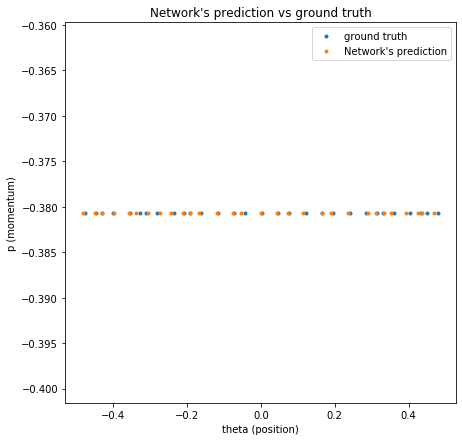

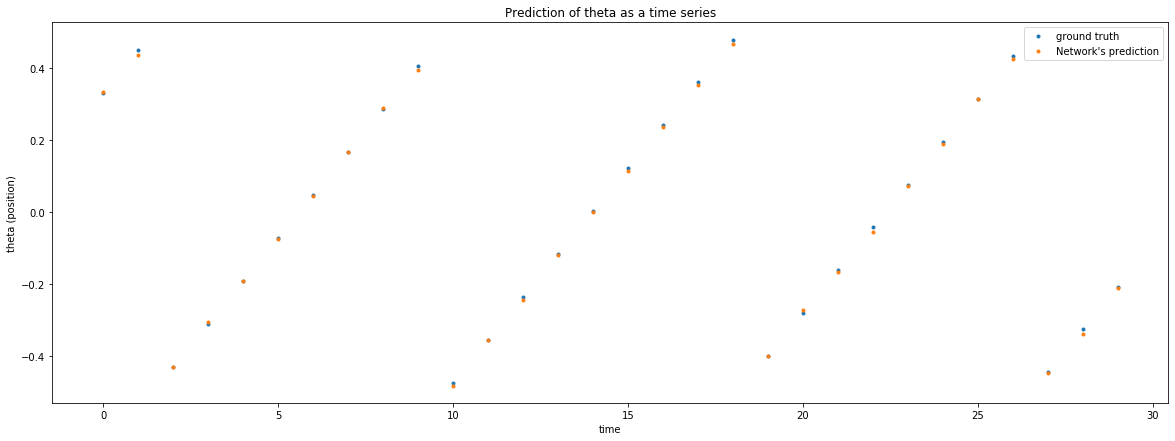

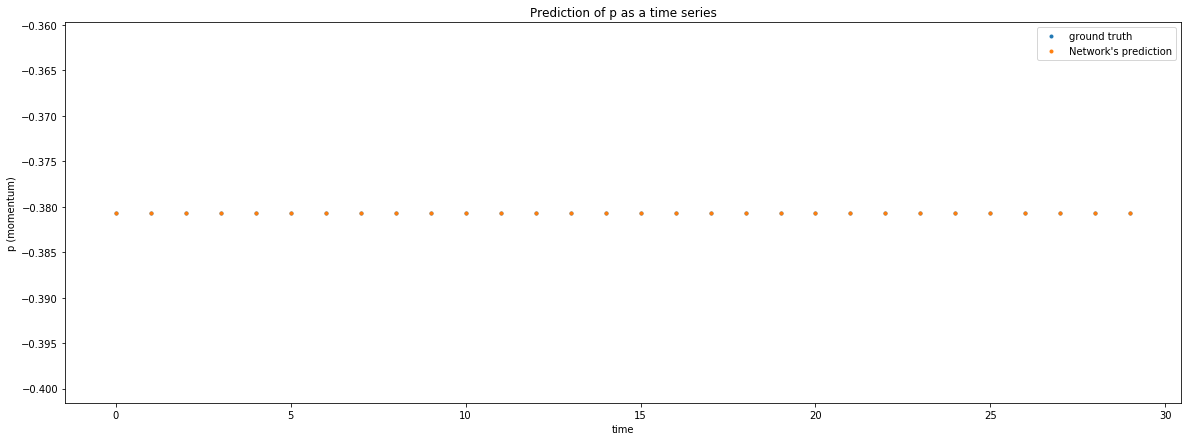

The test MSE for the 1-th dimension is 4.3154630408214414e-05
The test MSE for the 2-th dimension is 3.0814879110195774e-33
The 84 NRMSE for the 1-th dimension is 1.9734444806292073
The 84 NRMSE for the 2-th dimension is 3.1610136383170525e-07


In [9]:
#TEST: PREDICT
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

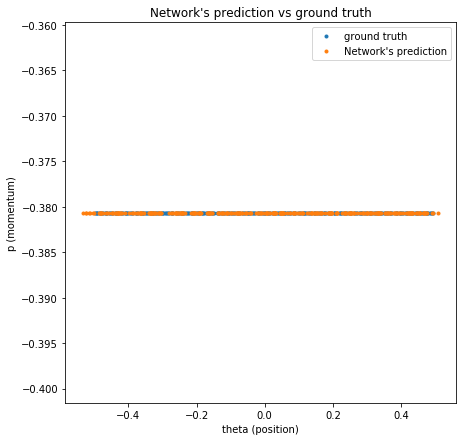

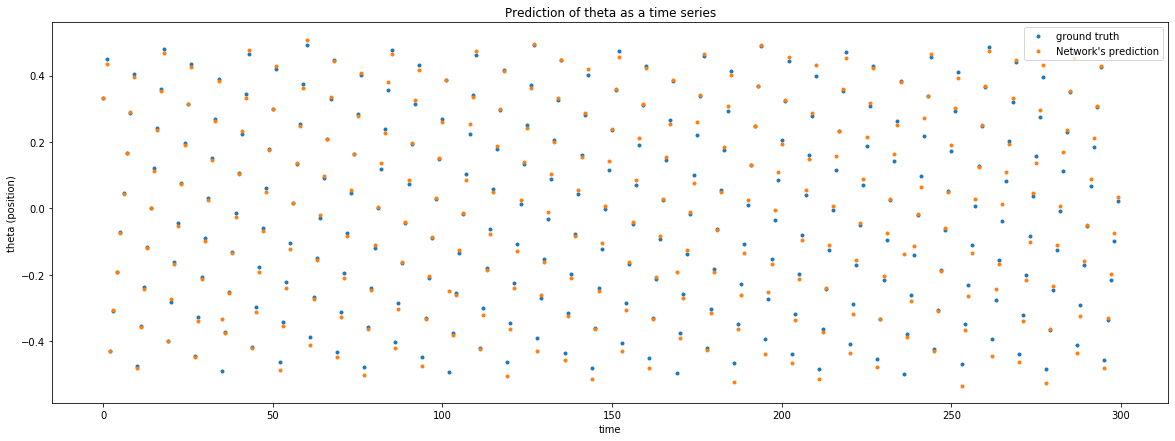

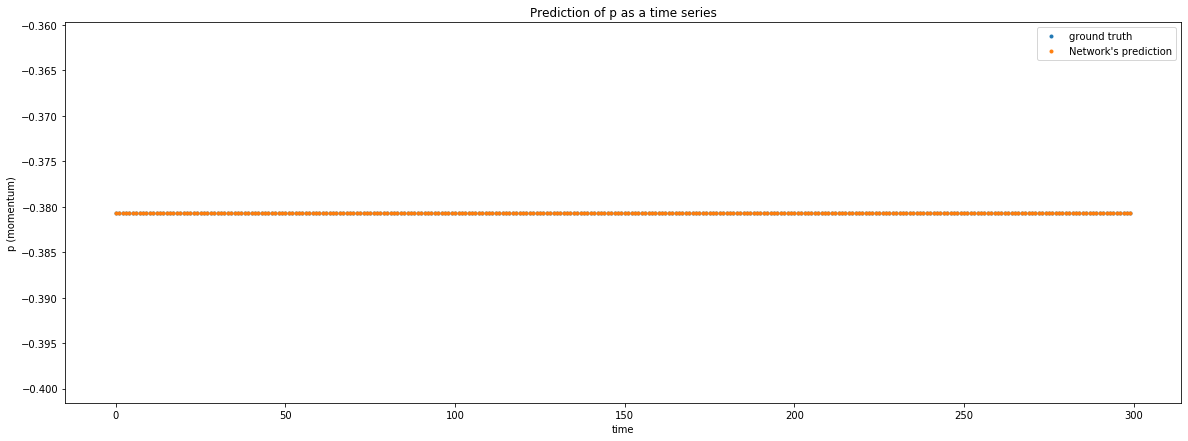

The test MSE for the 1-th dimension is 0.0013109493021867132
The test MSE for the 2-th dimension is 3.0814879110195774e-33


In [10]:
#TEST: PREDICT
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

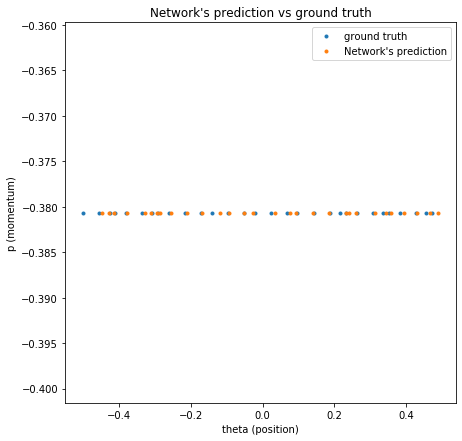

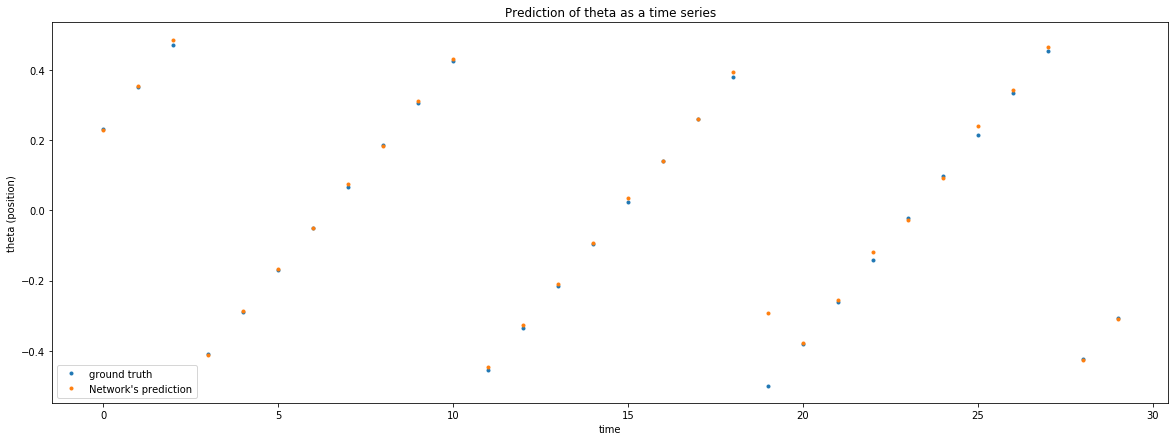

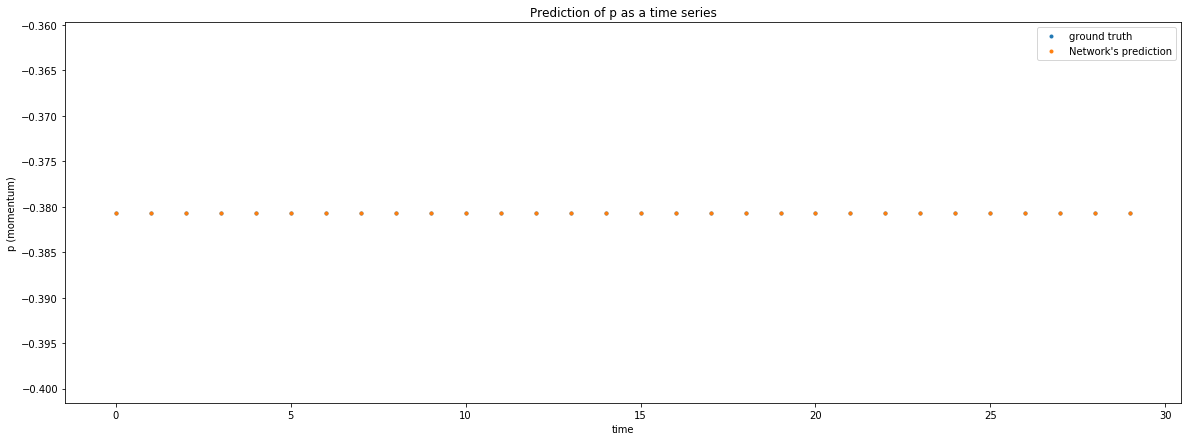

The test MSE for the 1-th dimension is 0.001487246244492662
The test MSE for the 2-th dimension is 3.0814879110195774e-33


In [11]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


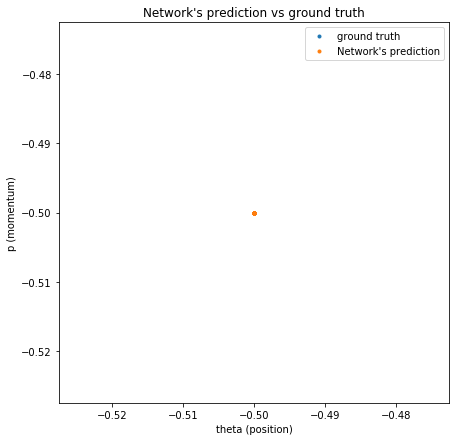

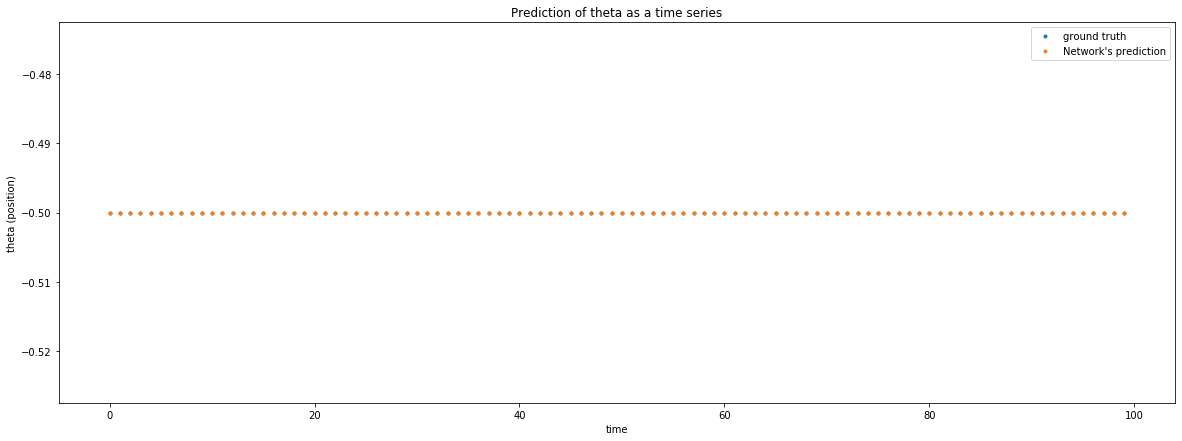

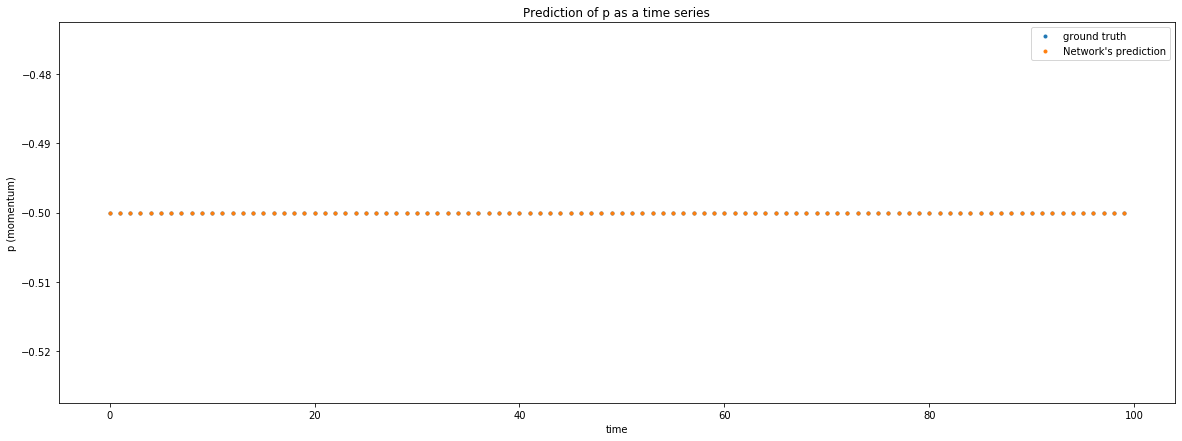

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 4.293723882638157e-07
The training MSE for the 2-th dimension is 0.0


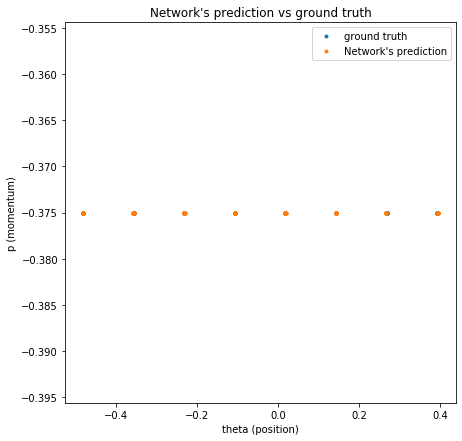

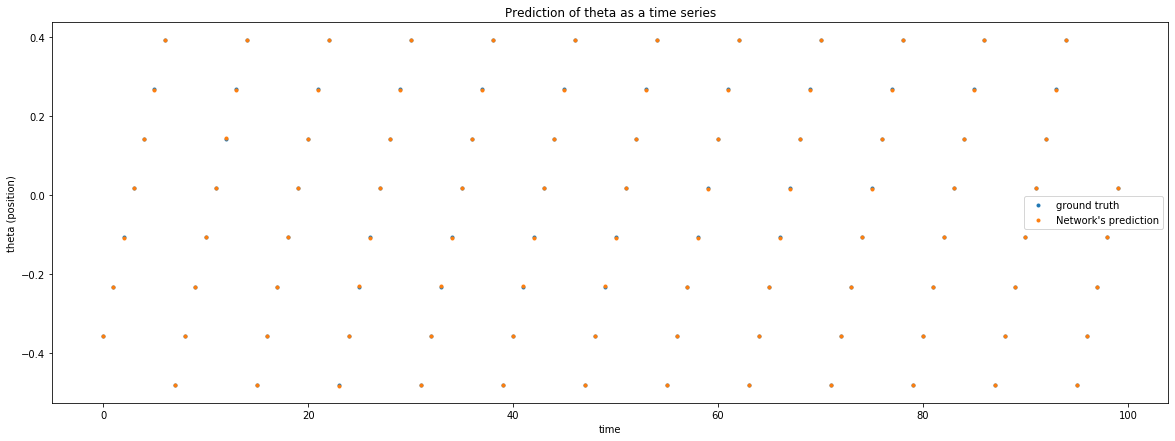

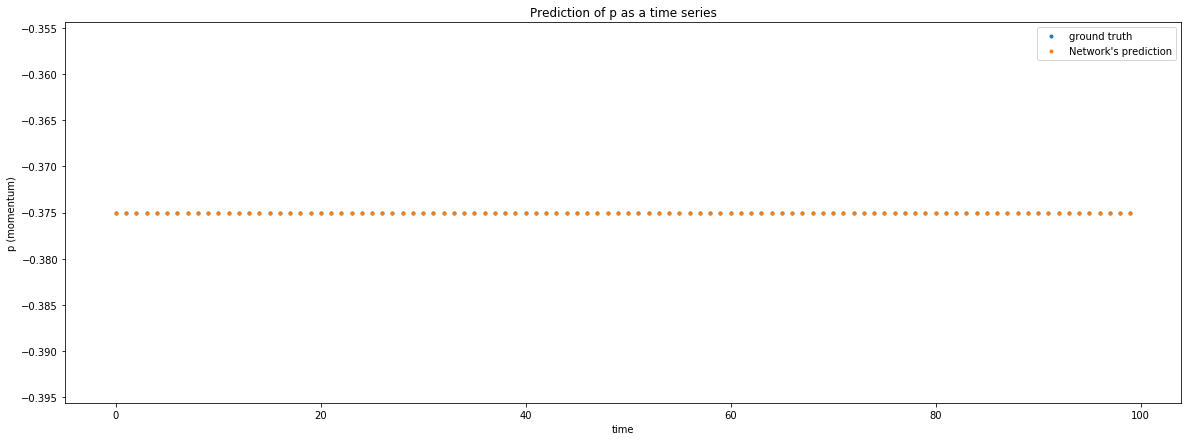

The test MSE for the 1-th dimension is 5.401184656490912e-07
The test MSE for the 2-th dimension is 3.0814879110195774e-33


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is 0.023314189202141386
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.00271438973839124
The training MSE for the 2-th dimension is 0.0


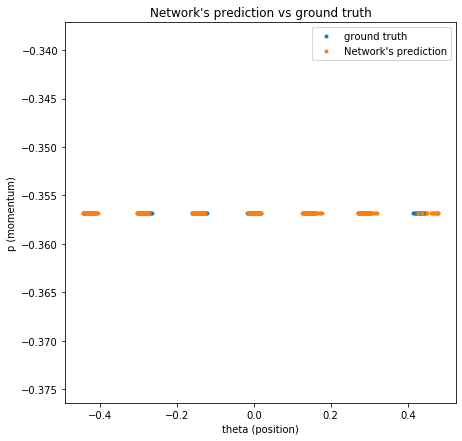

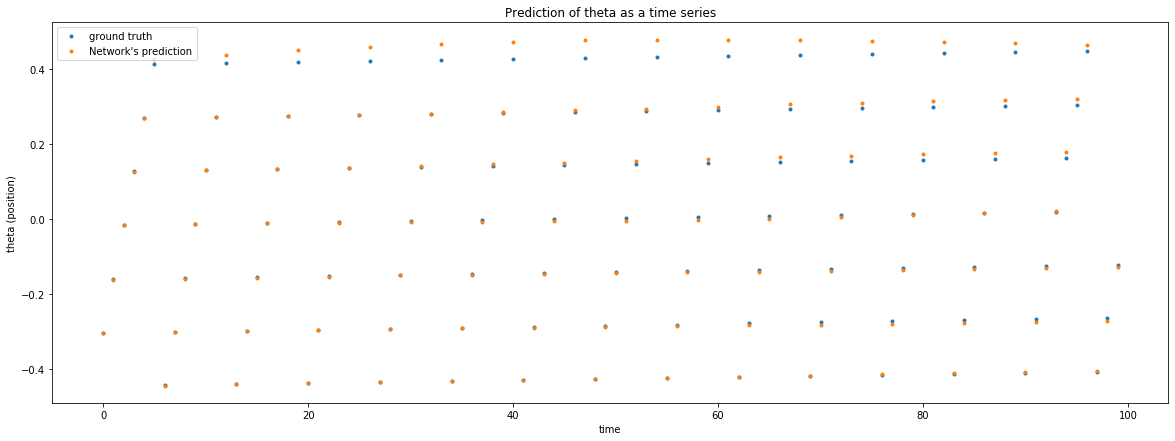

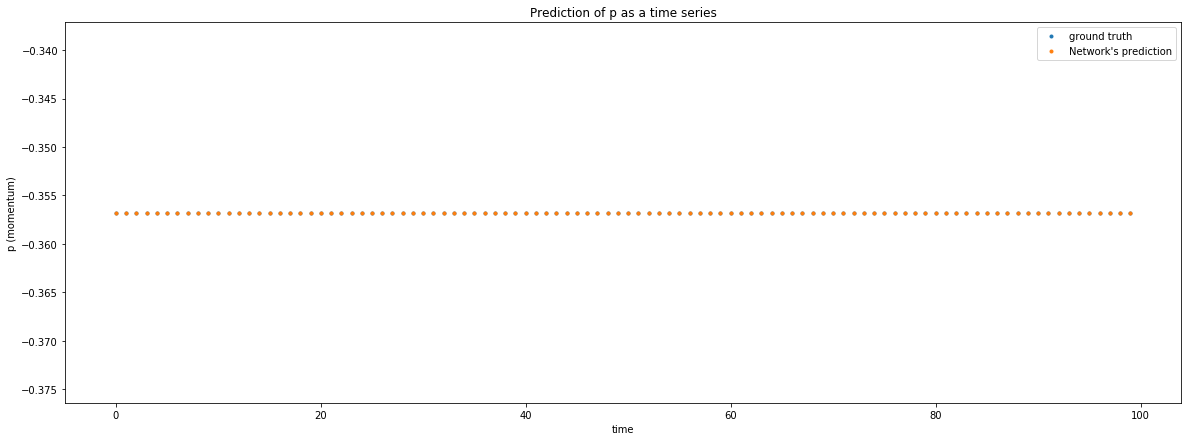

The test MSE for the 1-th dimension is 0.00020956322834888666
The test MSE for the 2-th dimension is 0.0
The 84 NRMSE for the 1-th dimension is 12.768710995575113
The 84 NRMSE for the 2-th dimension is 0.0

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 0.0
The training MSE for the 2-th dimension is 1.232595164407831e-32


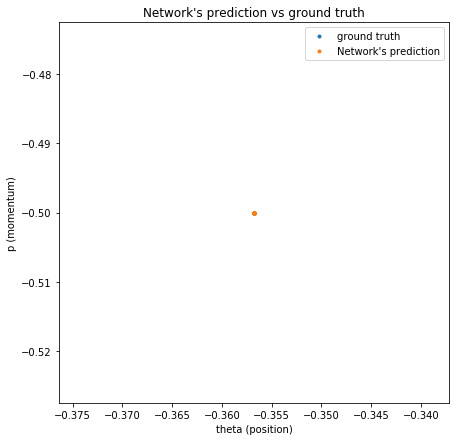

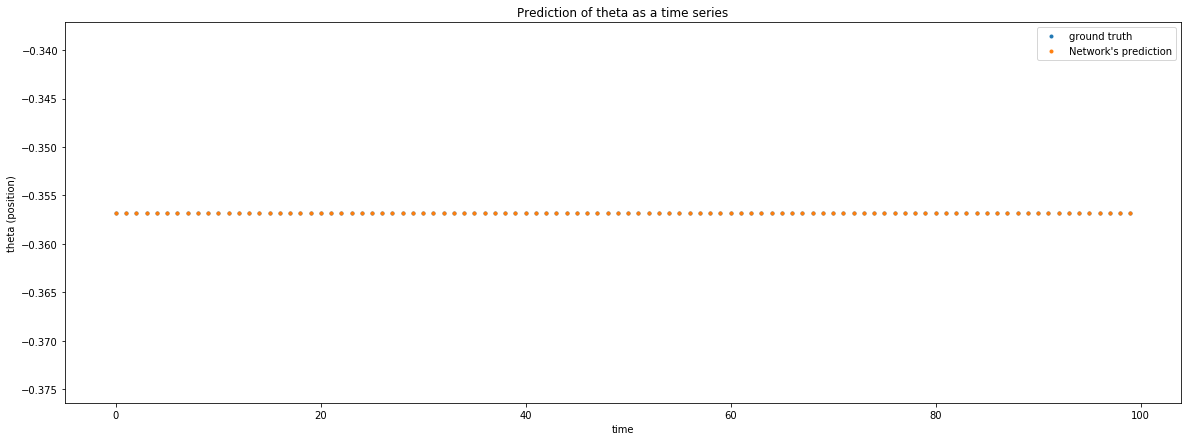

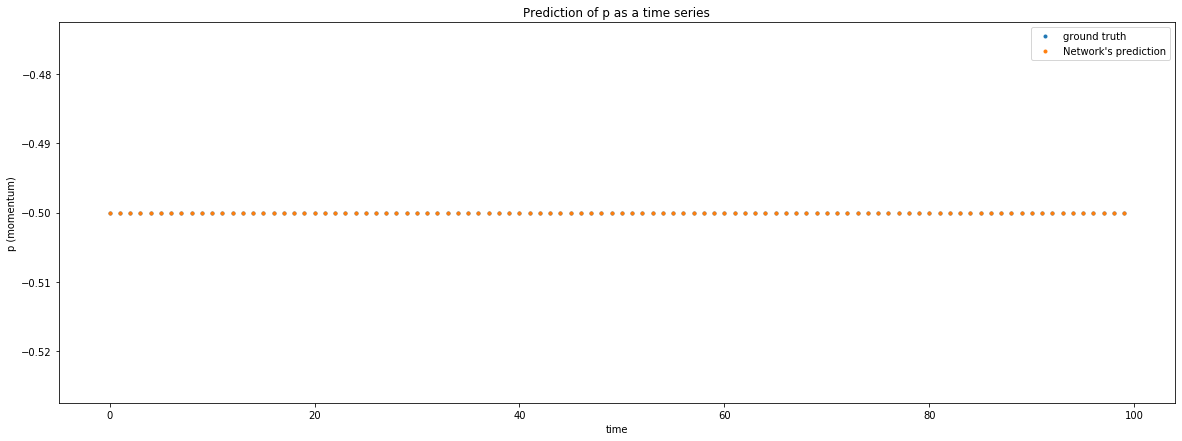

The test MSE for the 1-th dimension is 0.0
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is 0.0
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.0015402700085252147
The training MSE for the 2-th dimension is 0.0


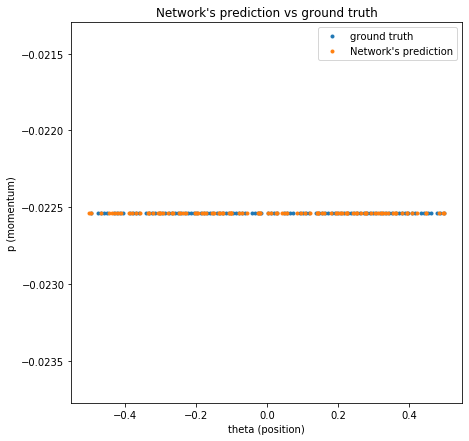

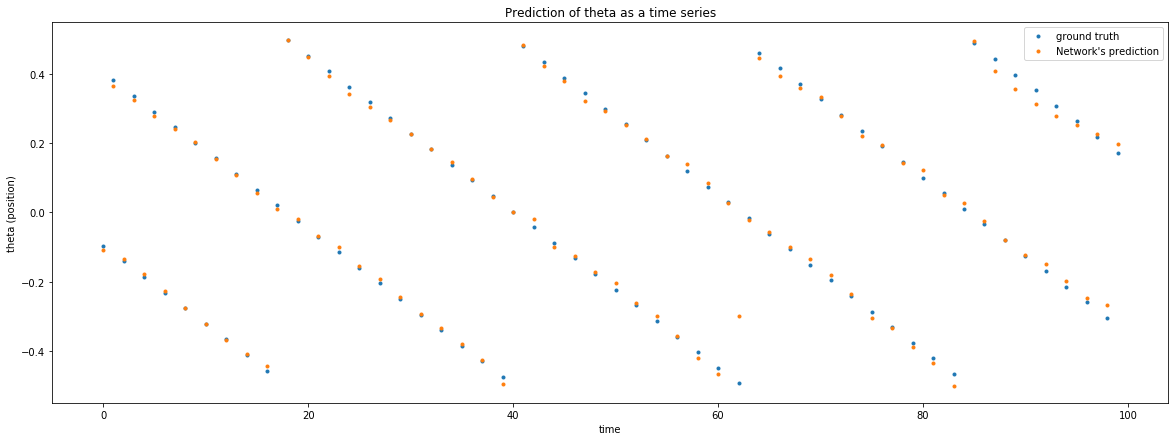

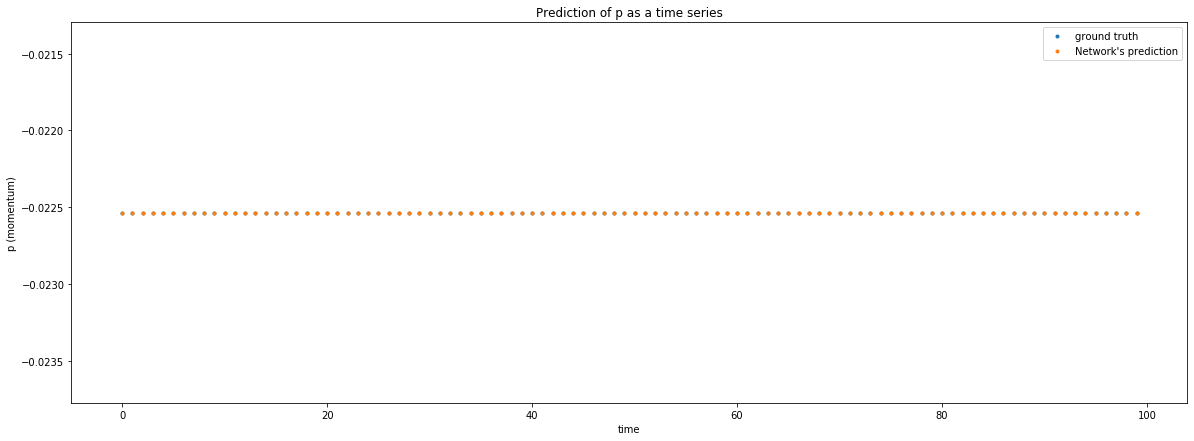

The test MSE for the 1-th dimension is 0.0005695122045787625
The test MSE for the 2-th dimension is 1.2037062152420224e-35
The 84 NRMSE for the 1-th dimension is 2.318738357045545
The 84 NRMSE for the 2-th dimension is 0.0

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 0.000847564264787281
The training MSE for the 2-th dimension is 4.81482486096809e-35


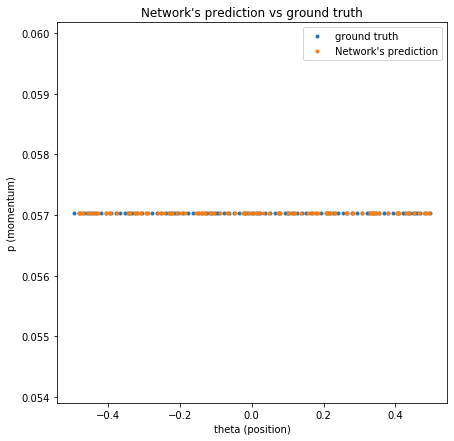

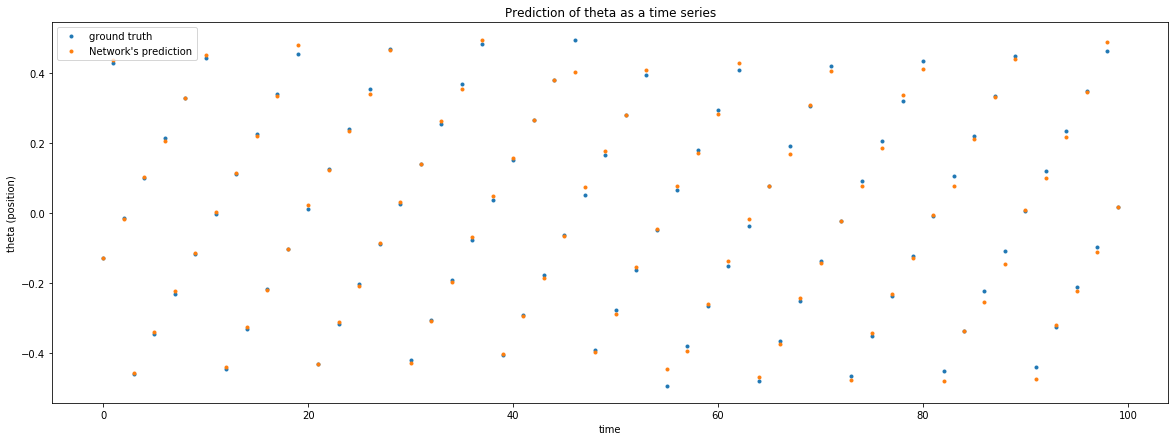

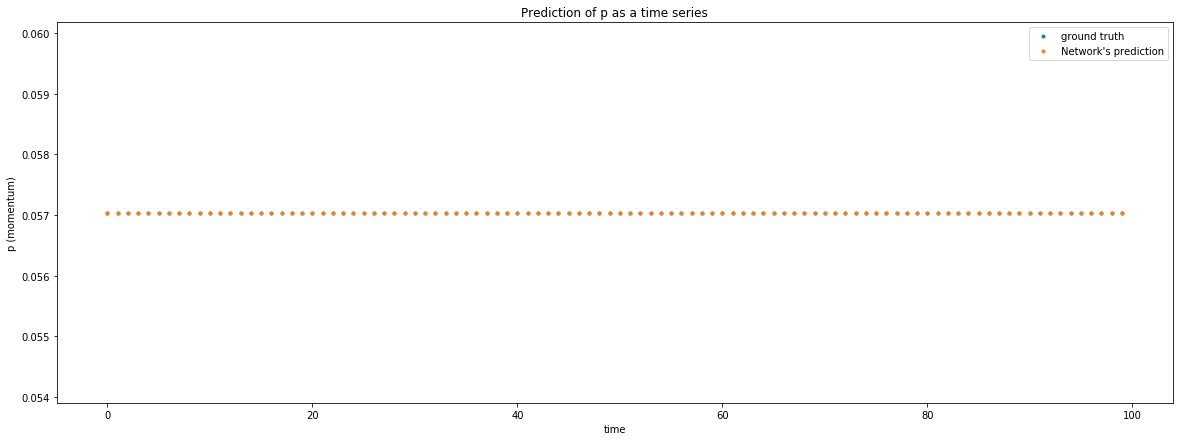

The test MSE for the 1-th dimension is 0.0002479286720340799
The test MSE for the 2-th dimension is 4.81482486096809e-35
The 84 NRMSE for the 1-th dimension is 2.616620138017931
The 84 NRMSE for the 2-th dimension is 0.0

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.0022142521316975733
The training MSE for the 2-th dimension is 3.0814879110195774e-33


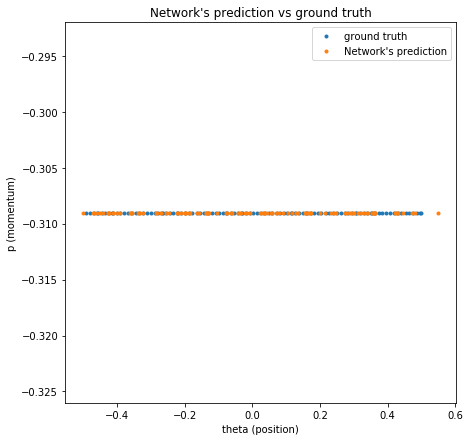

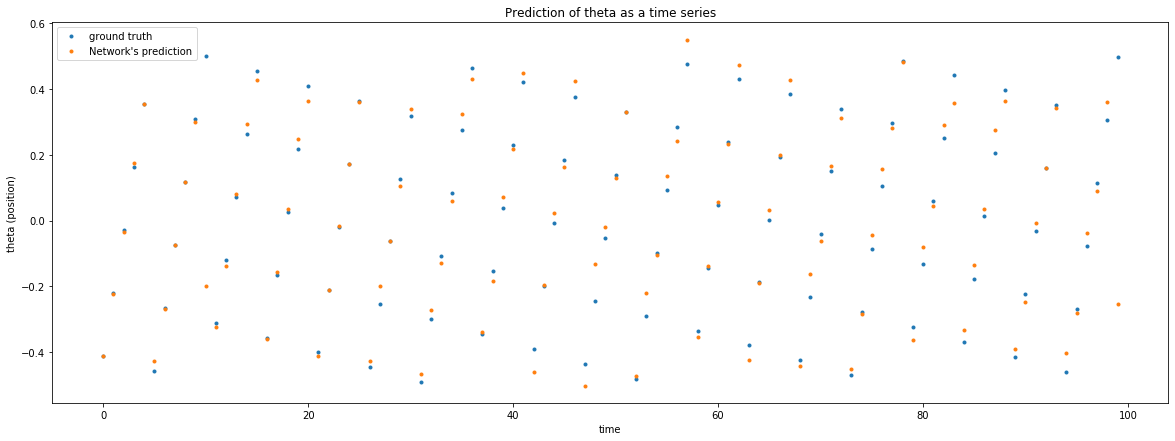

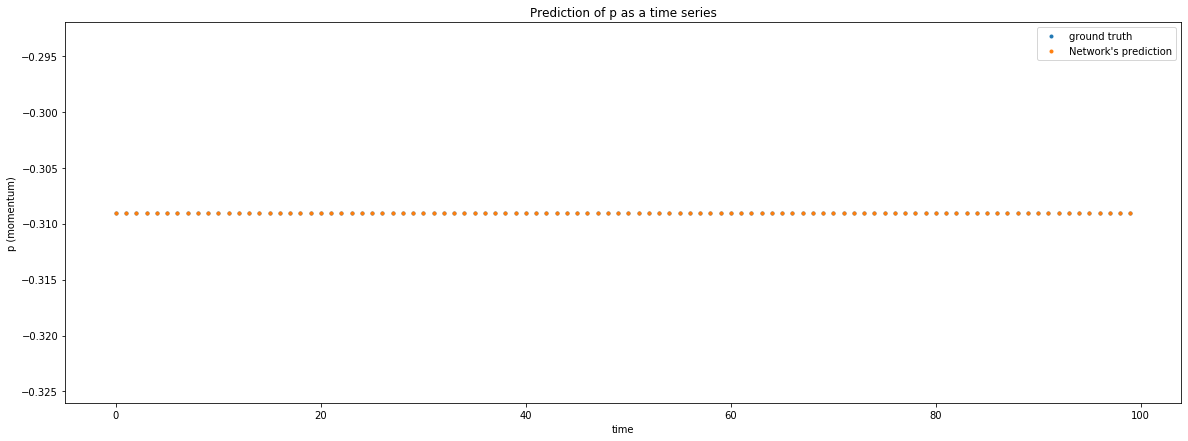

The test MSE for the 1-th dimension is 0.0116387319164852
The test MSE for the 2-th dimension is 3.0814879110195774e-33
The 84 NRMSE for the 1-th dimension is 8.392255037534458
The 84 NRMSE for the 2-th dimension is nan


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Since we are taking $K=0$, the value of $p$ is going to remain constant. When predicting the time steps that followed the training ones, we may infer that the constant nature of $p$ is captured, which is not surprising since it is the easiest dynamics to be learnt. On the other hand, by looking at the prediction of the parameter $\theta$, we can see that the first time steps are, in general, quite accurate. However, it appears that, after some time, the network starts commiting some mistakes. At this point, we can distinguish two different types of behavior according to the $\text{NRMSE}_{84}$: the mistakes are amplified as time goes by OR the dynamics end up catching again the true trajectory. In the former case, such metrics are large (as happened with ($\theta_0$,$p_0$)=(1,1.2)) whereas in the latter case, such metrics are smaller (as happened with ($\theta_0$,$p_0$)=(0,0.75)). 

# 2.2 K=0.1 <a name="K01" ></a>

### Illustrative case

In [15]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0.1

In [16]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [17]:
Network.non_null_matrices = ["W_back", "W_in"]

In [18]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE for the 1-th dimension is 0.00297013971458614
The training MSE for the 2-th dimension is 1.9712378488347376e-08


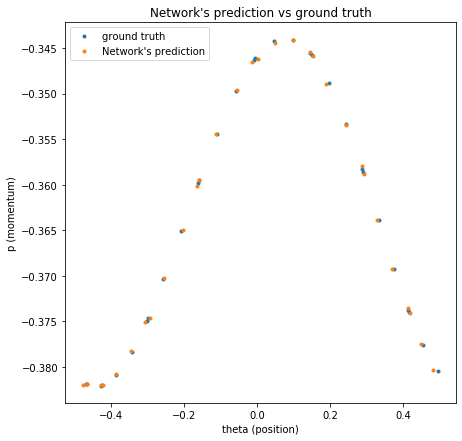

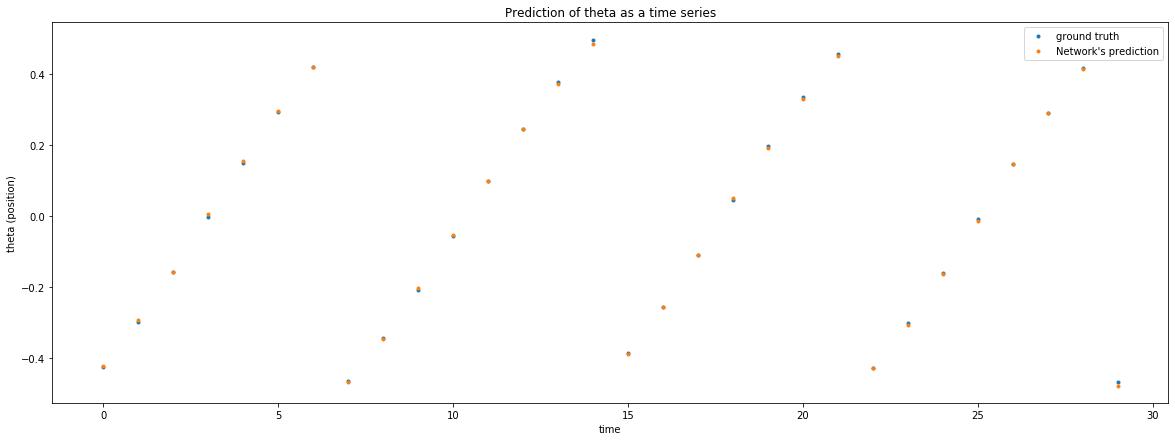

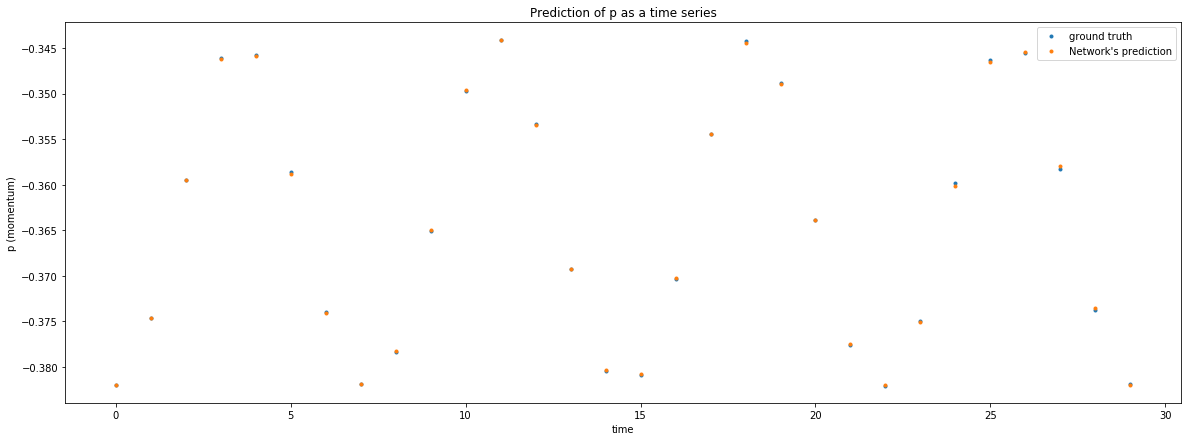

The test MSE for the 1-th dimension is 2.225677739032438e-05
The test MSE for the 2-th dimension is 1.4534580994070284e-08
The 84 NRMSE for the 1-th dimension is 14.477667181104364
The 84 NRMSE for the 2-th dimension is 1.5948343301694383


In [19]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

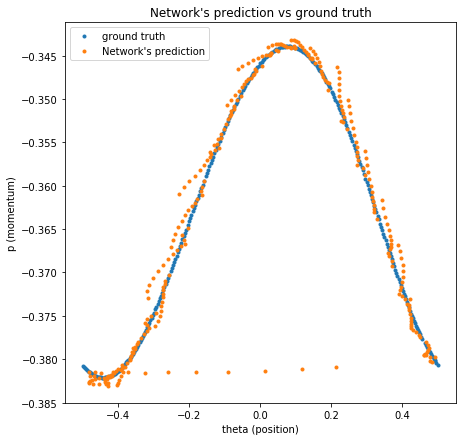

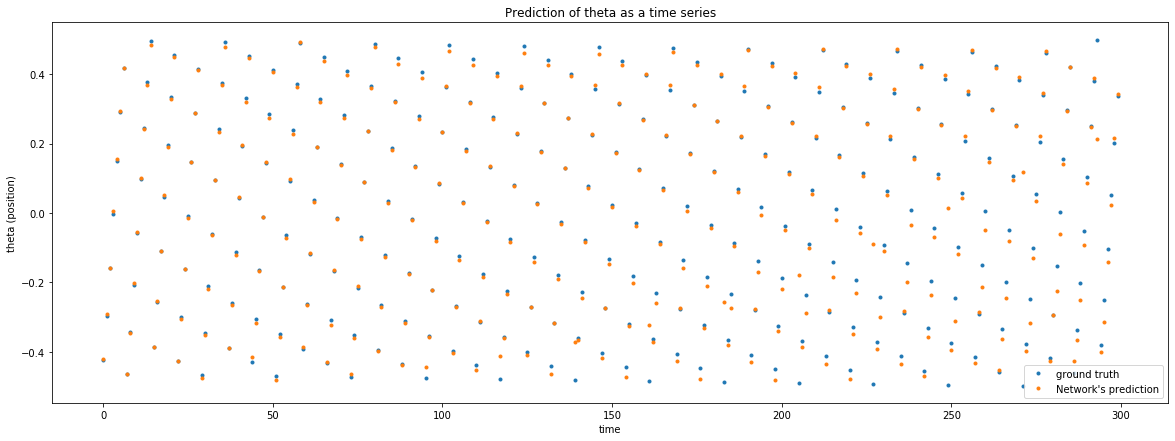

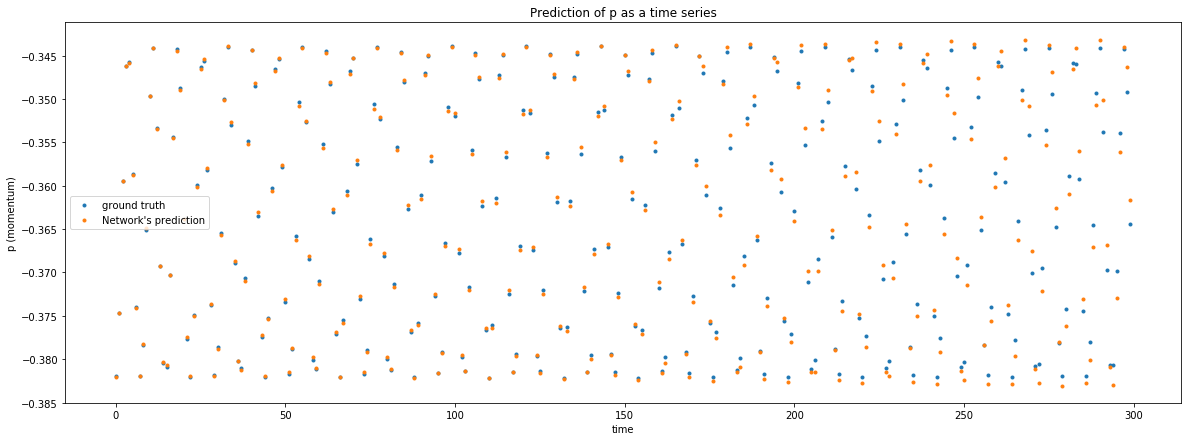

The test MSE for the 1-th dimension is 0.0038843540676209865
The test MSE for the 2-th dimension is 1.0452639016488094e-06


In [20]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

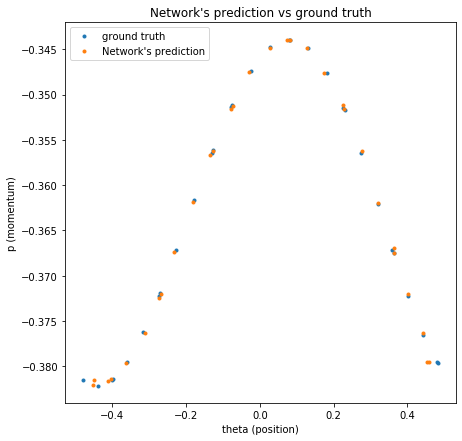

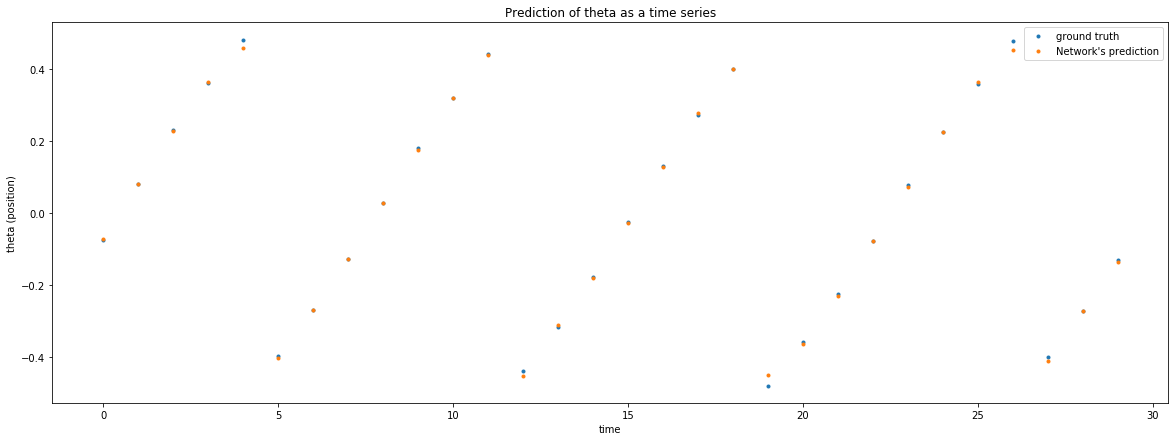

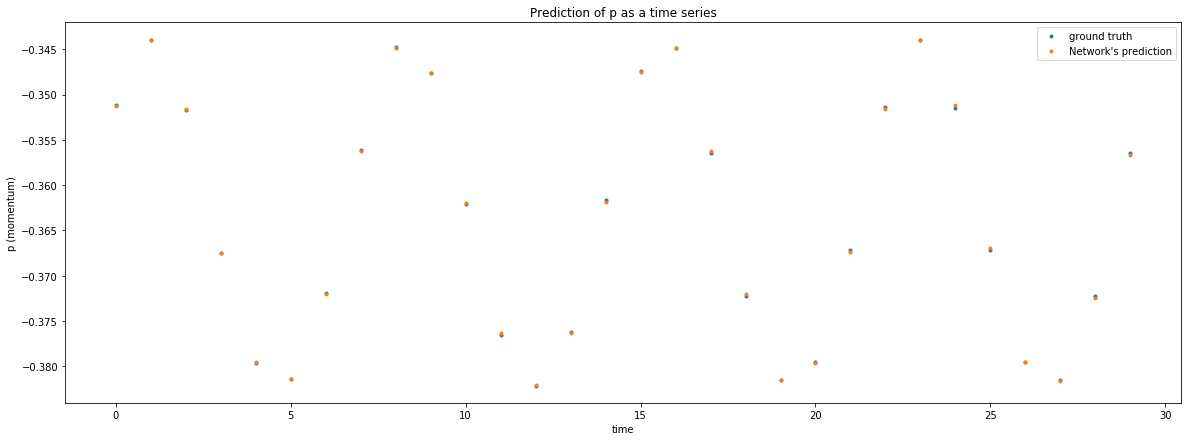

The test MSE for the 1-th dimension is 9.131223744378028e-05
The test MSE for the 2-th dimension is 2.128598278295067e-08


In [21]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

###  Different initial conditions


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


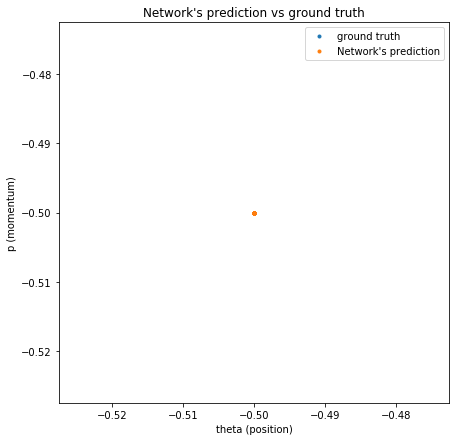

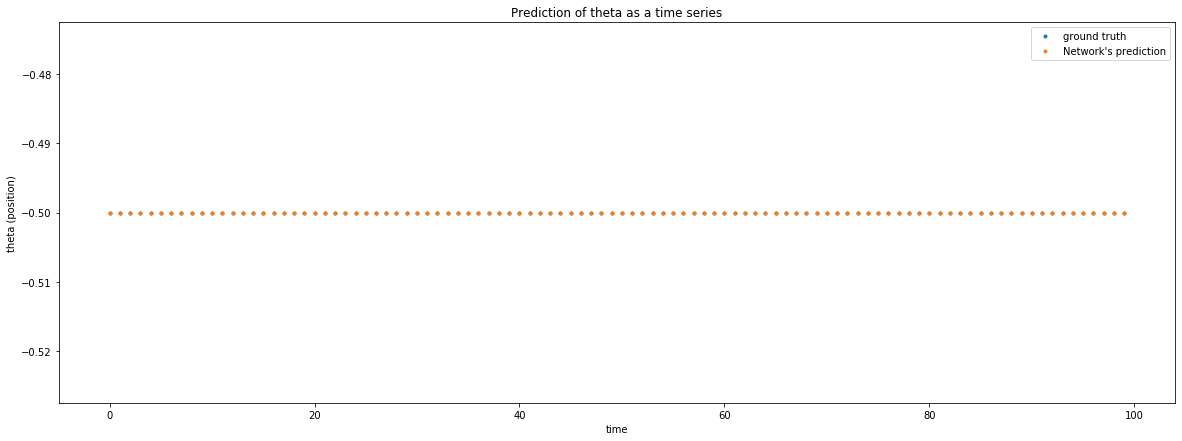

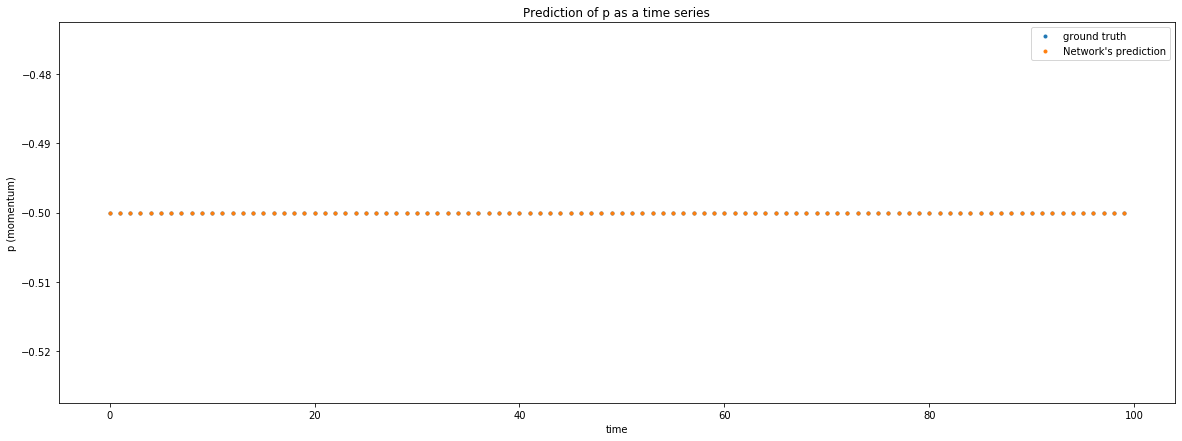

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 0.0018938078580191039
The training MSE for the 2-th dimension is 3.084403944592877e-08


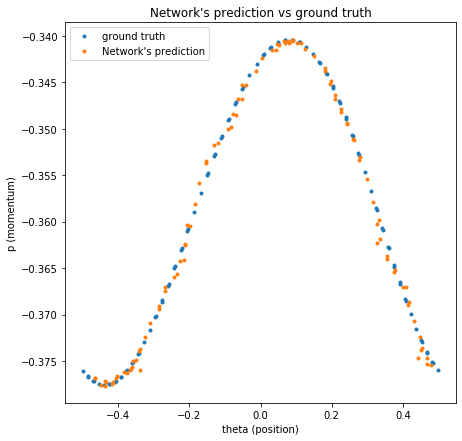

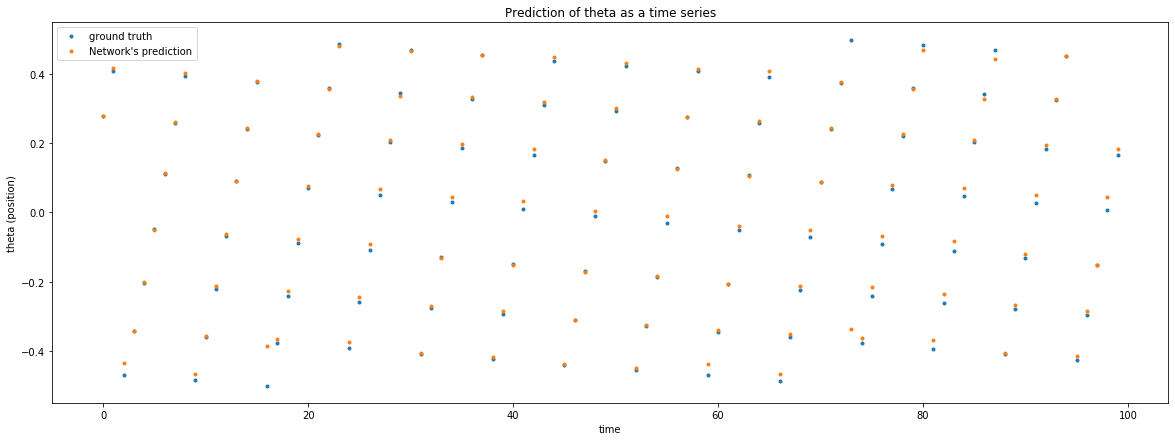

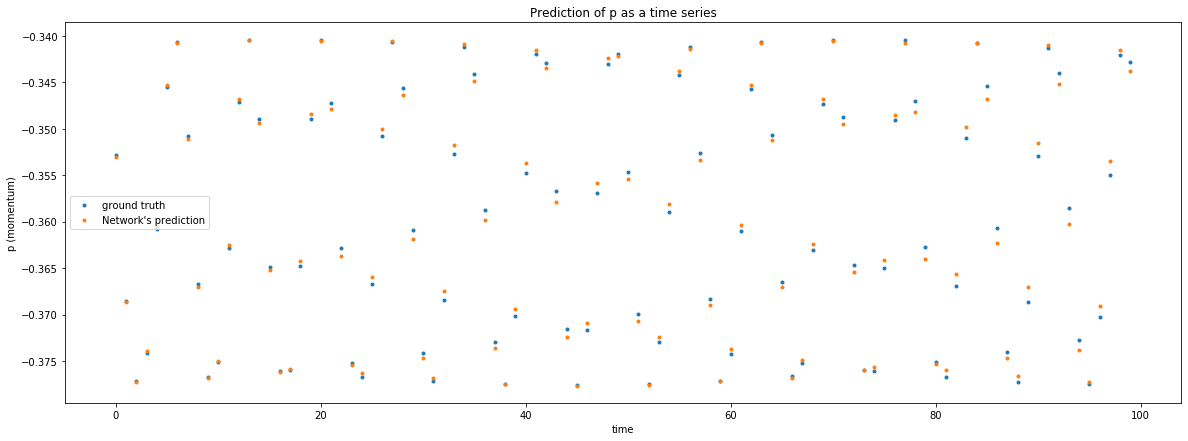

The test MSE for the 1-th dimension is 0.007298041088306514
The test MSE for the 2-th dimension is 5.175994902932712e-07
The 84 NRMSE for the 1-th dimension is 2.2214914716349443
The 84 NRMSE for the 2-th dimension is 1.9797492307956126

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.003624587798062987
The training MSE for the 2-th dimension is 1.7974615438795886e-08


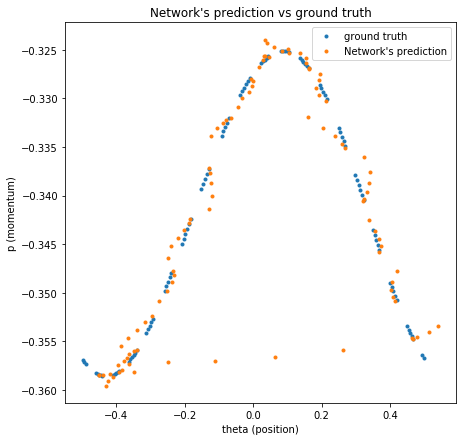

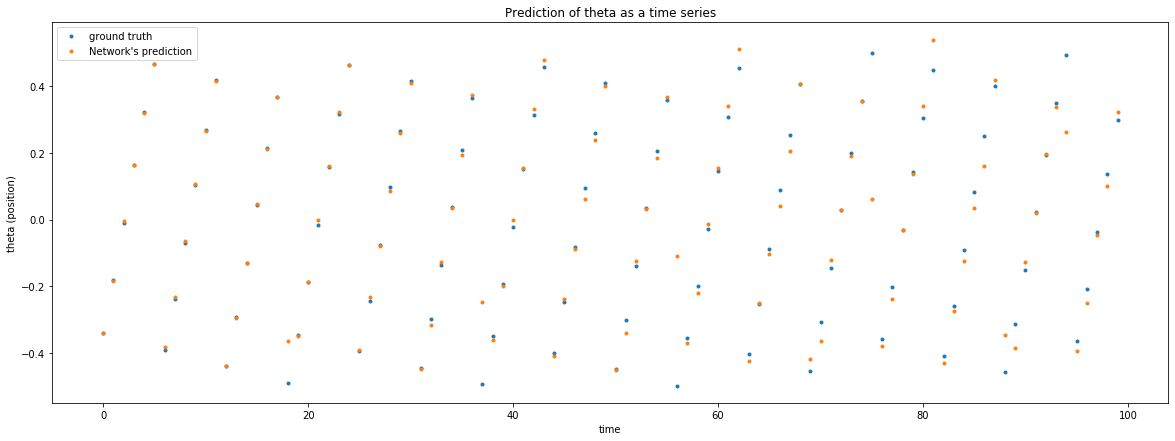

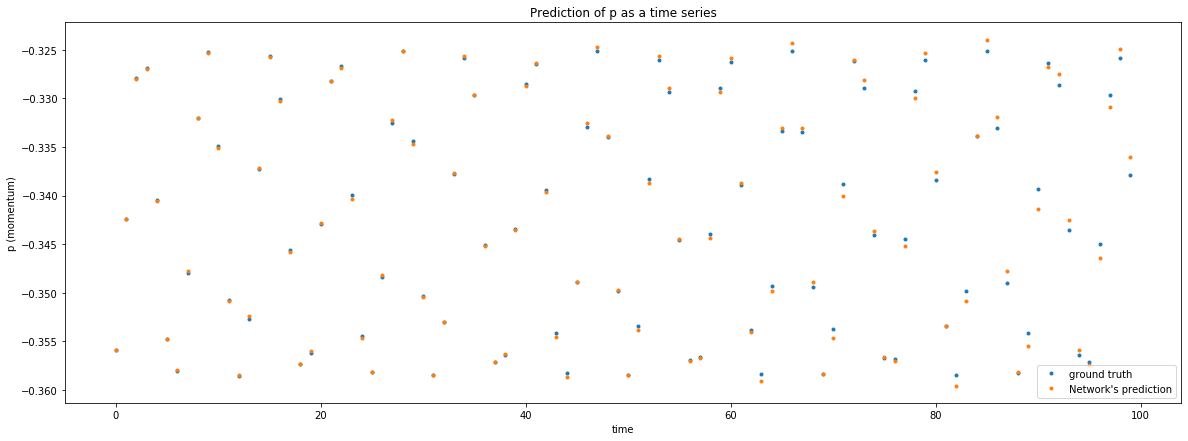

The test MSE for the 1-th dimension is 0.005379803845057384
The test MSE for the 2-th dimension is 3.334169193145806e-07
The 84 NRMSE for the 1-th dimension is 13.486317374234929
The 84 NRMSE for the 2-th dimension is 3.795820447543062

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 1.0876041398339148e-06
The training MSE for the 2-th dimension is 0.0033590307788725453


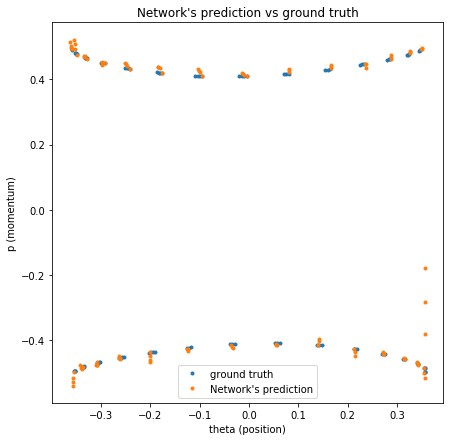

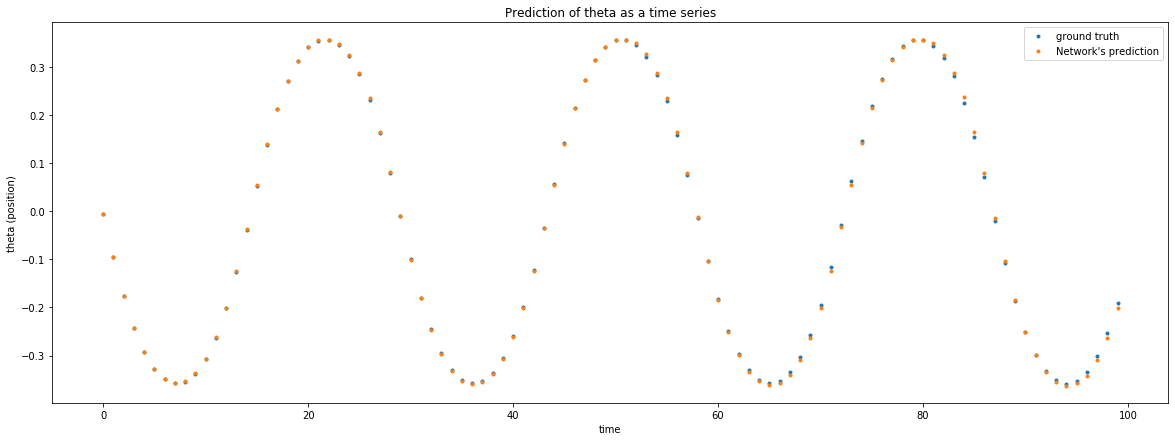

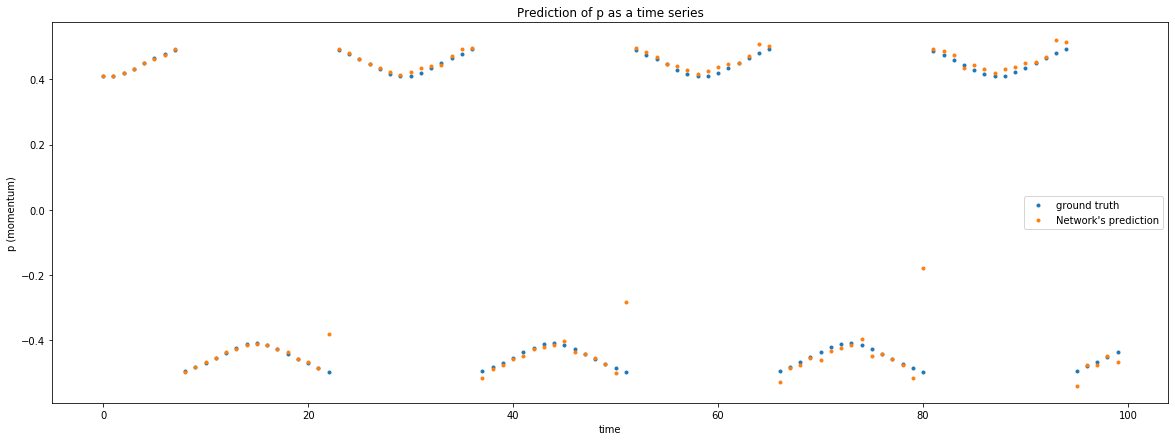

The test MSE for the 1-th dimension is 1.592399640364605e-05
The test MSE for the 2-th dimension is 0.0017856918170284686
The 84 NRMSE for the 1-th dimension is 1.1615872335340902
The 84 NRMSE for the 2-th dimension is 7.723921112405613

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.0013734986169014135
The training MSE for the 2-th dimension is 4.023494022896191e-09


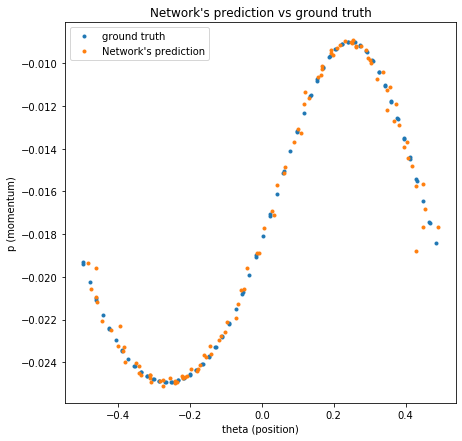

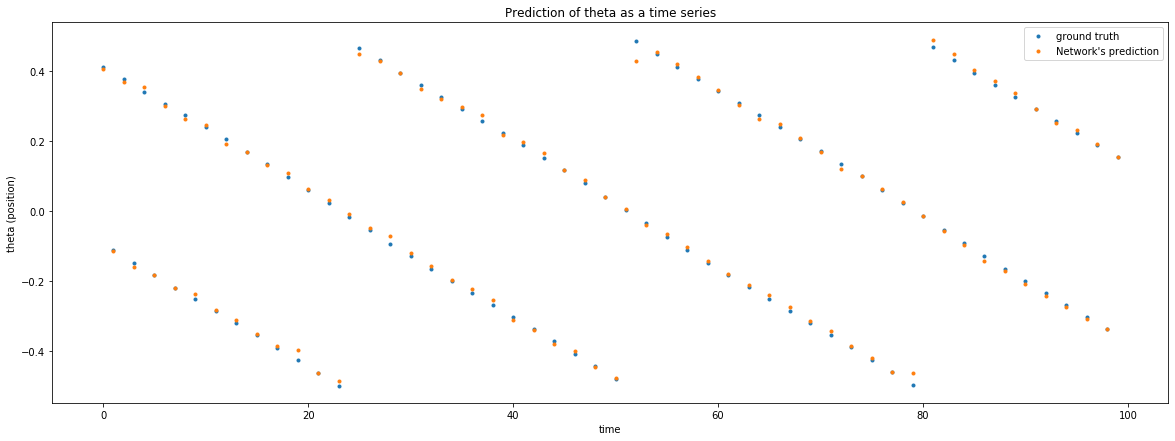

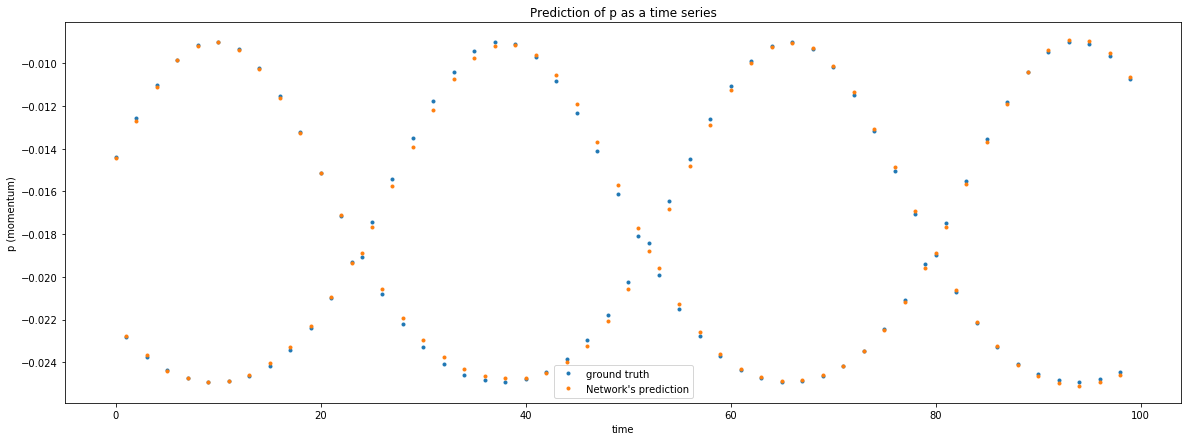

The test MSE for the 1-th dimension is 0.00012509130430174168
The test MSE for the 2-th dimension is 3.7233282483537225e-08
The 84 NRMSE for the 1-th dimension is 19.226216470637713
The 84 NRMSE for the 2-th dimension is 1.5012969087944728

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 0.0009323133016786039
The training MSE for the 2-th dimension is 3.773680400564986e-09


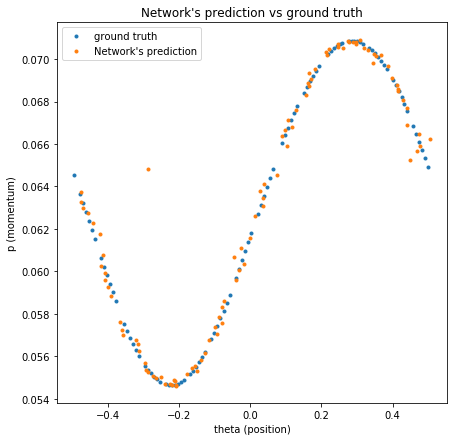

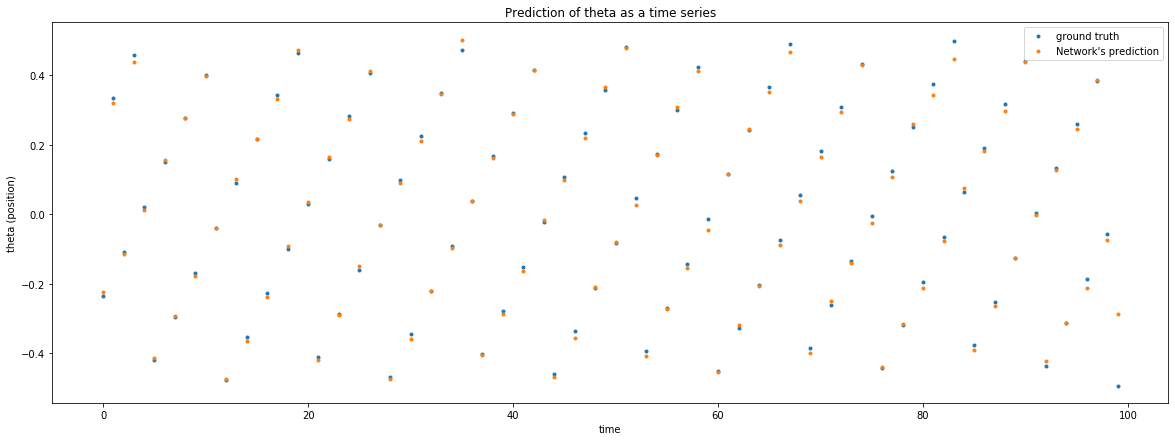

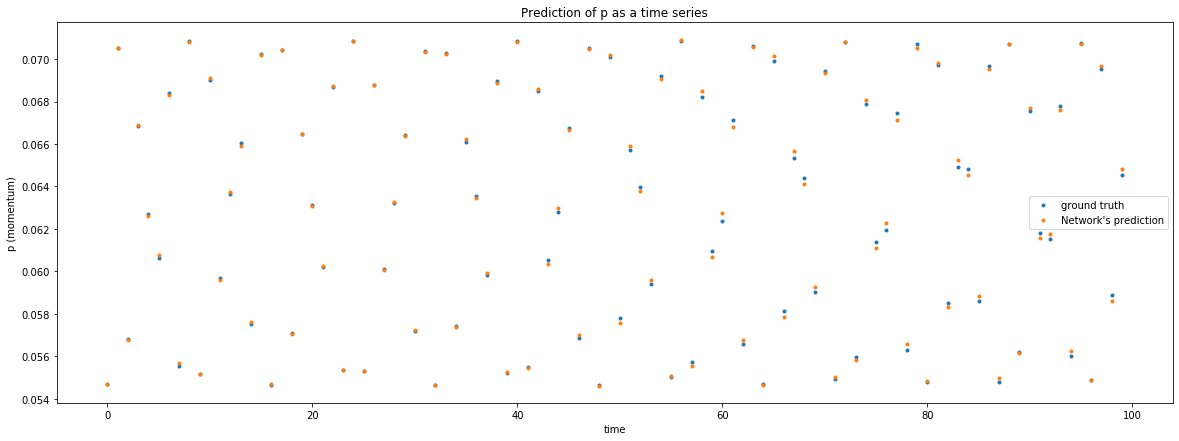

The test MSE for the 1-th dimension is 0.0005826960770658745
The test MSE for the 2-th dimension is 2.5872807034849504e-08
The 84 NRMSE for the 1-th dimension is 3.2775845686390364
The 84 NRMSE for the 2-th dimension is 1.9446643523775504

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.003543338074080033
The training MSE for the 2-th dimension is 1.2871500062392136e-08


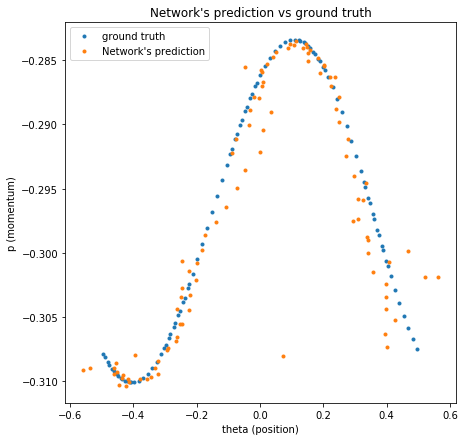

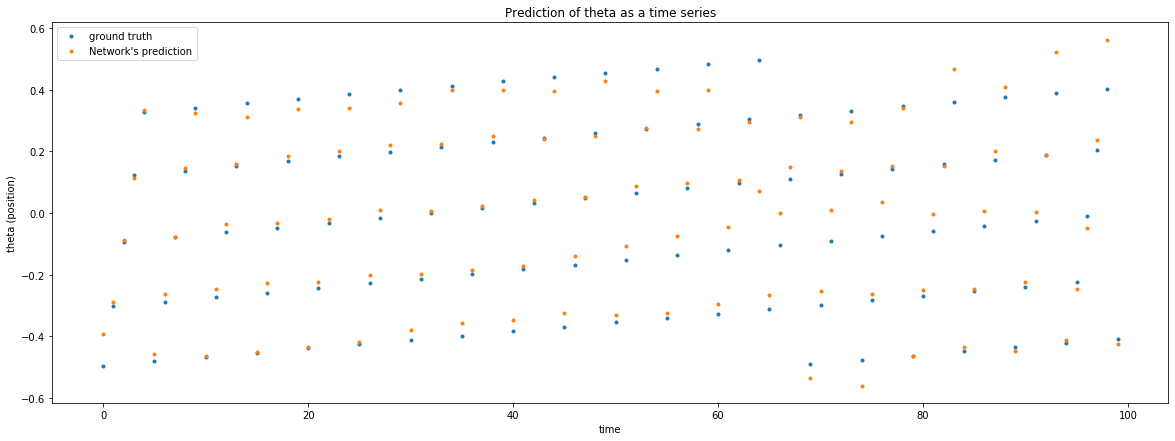

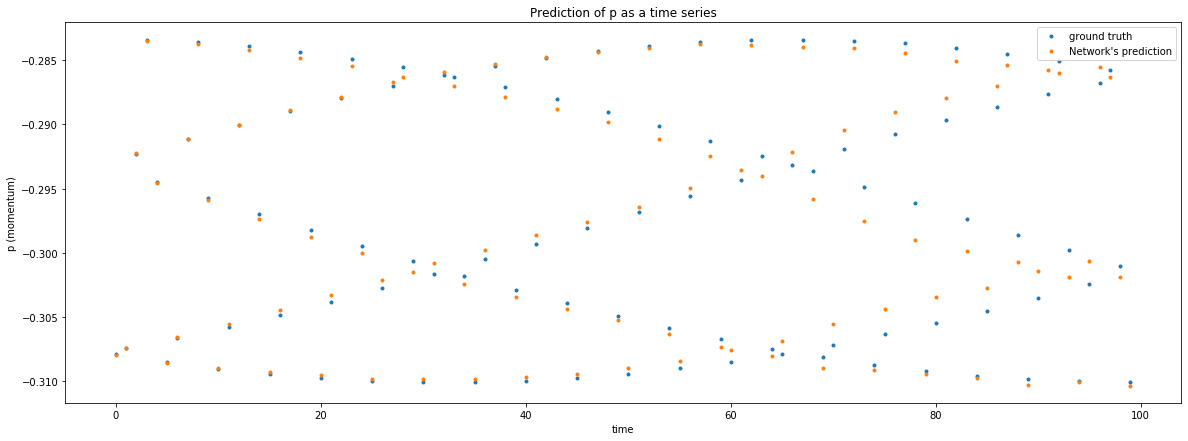

The test MSE for the 1-th dimension is 0.003600752234948547
The test MSE for the 2-th dimension is 9.819122710985339e-07
The 84 NRMSE for the 1-th dimension is 21.834204645697326
The 84 NRMSE for the 2-th dimension is 8.264865270710628


In [22]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.1, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Again, we can distinguish the same two types of dynamics as in the previous case of $K=0$. However, notice that, despite the predictions may end up degenerating, the short term predictions are quite good. Observe that, if it is true that it is quite easy to infer the underlying subspace where the data lies, it is not so easy to actually predict the next time step since they do not follow a clear pattern. Therefore, the task of predicting these dynamics do to seem to be trivial, despite the fact that this value of $K$ do not lead to chaotic behaviors.

# 2.3 K=0.25 <a name="K025" ></a>

### Illustrative example

In [26]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0.25

In [27]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [28]:
Network.non_null_matrices = ["W_back", "W_in"]

In [29]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE for the 1-th dimension is 0.001168620165098588
The training MSE for the 2-th dimension is 3.067409220834913e-08


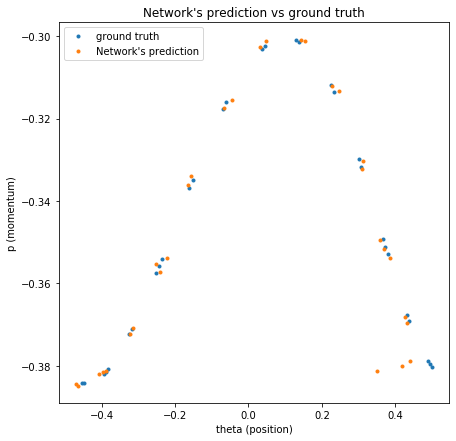

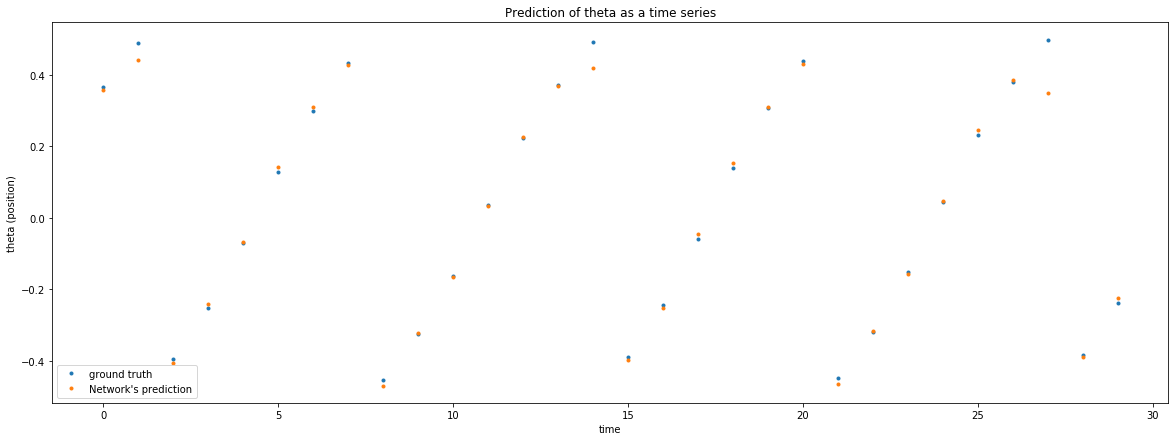

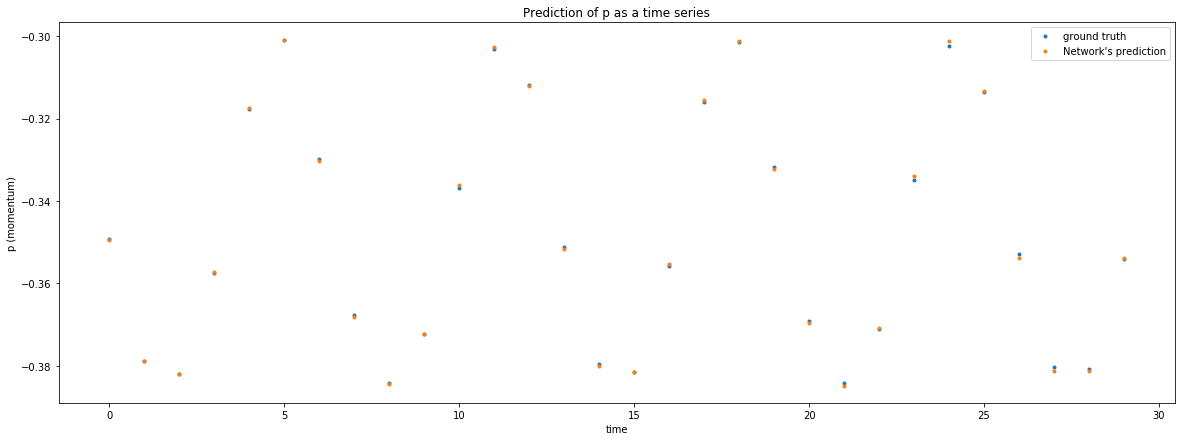

The test MSE for the 1-th dimension is 0.001080236569863155
The test MSE for the 2-th dimension is 2.310776200440858e-07
The 84 NRMSE for the 1-th dimension is 6.371729462897517
The 84 NRMSE for the 2-th dimension is 1.9359799329287115


In [30]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

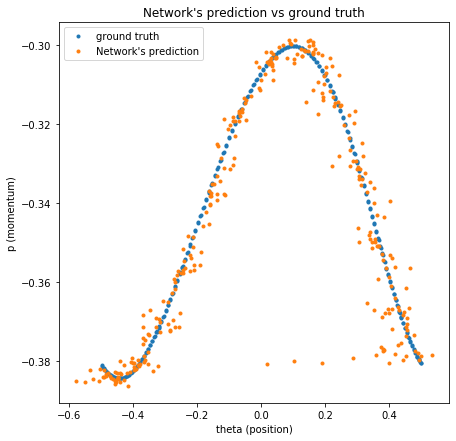

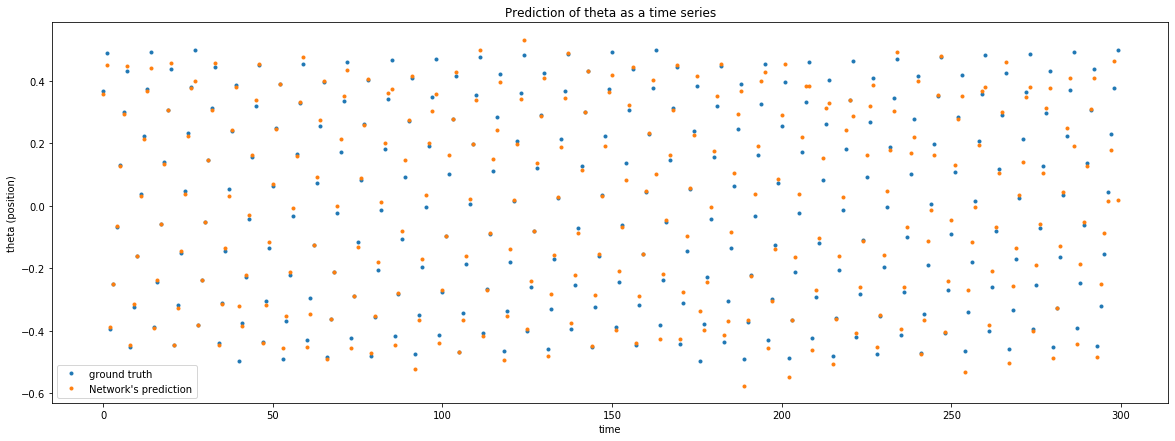

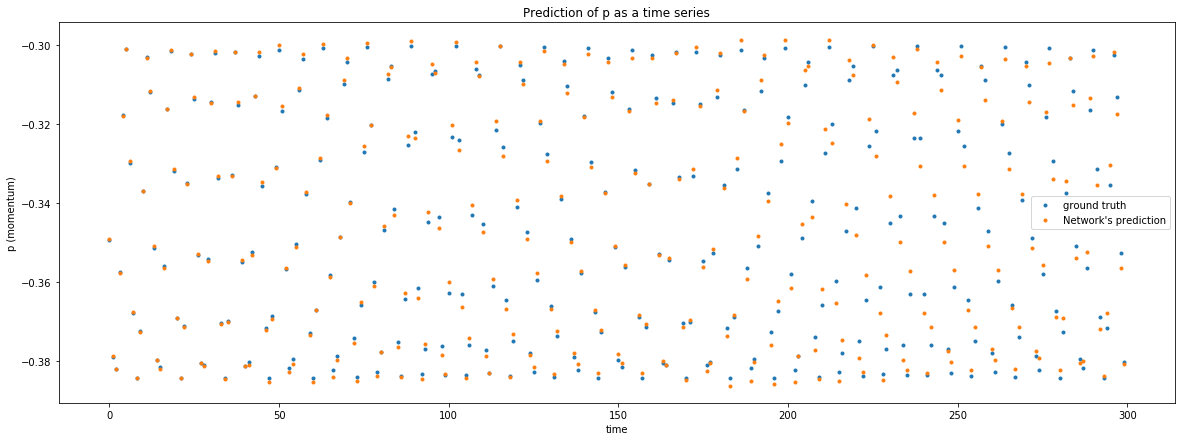

The test MSE for the 1-th dimension is 0.0029881539219923942
The test MSE for the 2-th dimension is 5.678255446388582e-06


In [569]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

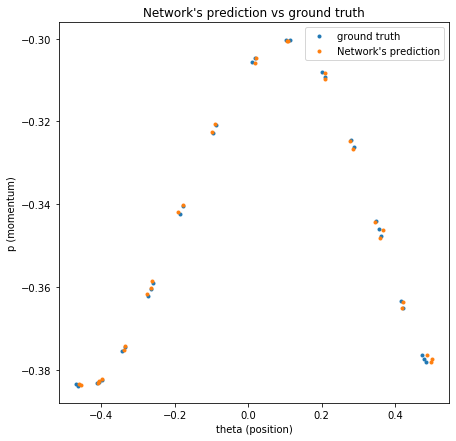

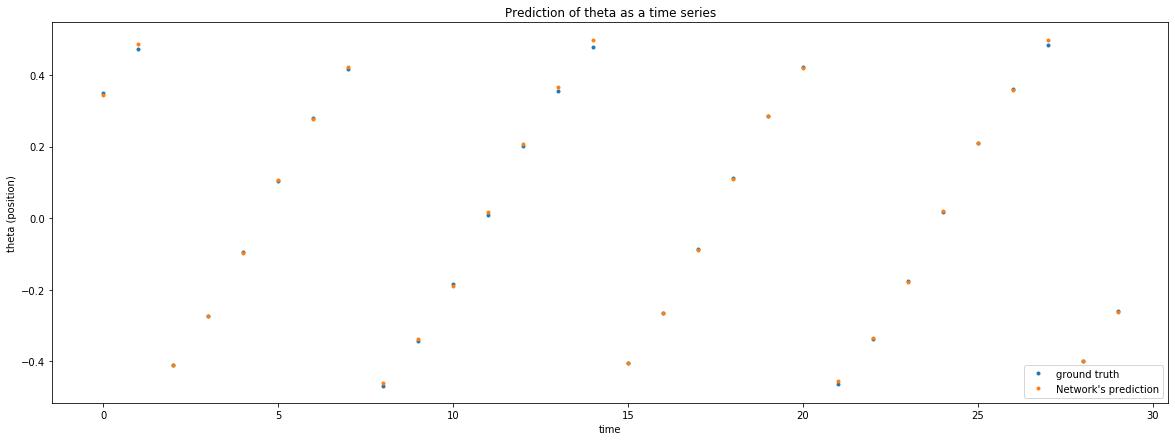

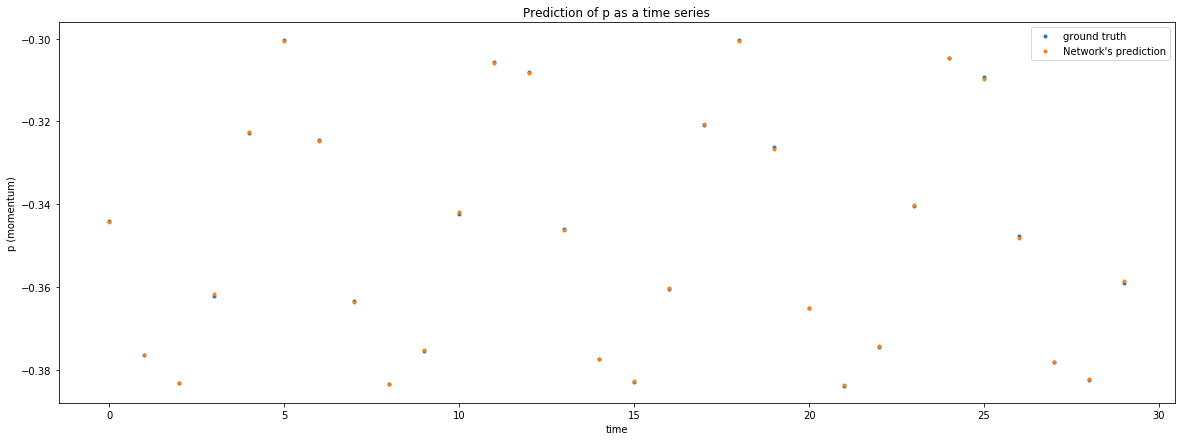

The test MSE for the 1-th dimension is 4.504672582384429e-05
The test MSE for the 2-th dimension is 6.753867134136405e-08


In [32]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


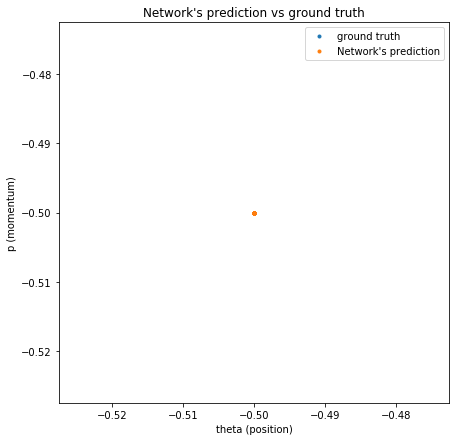

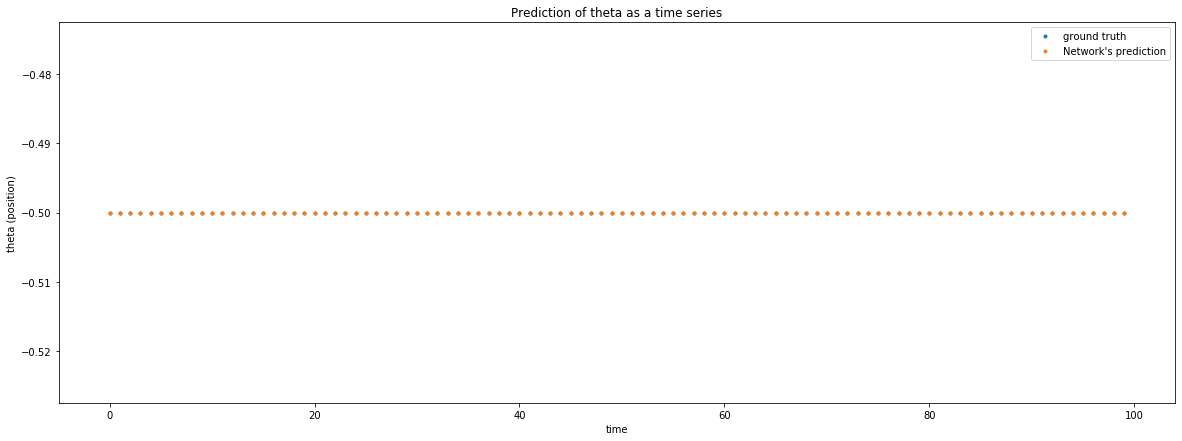

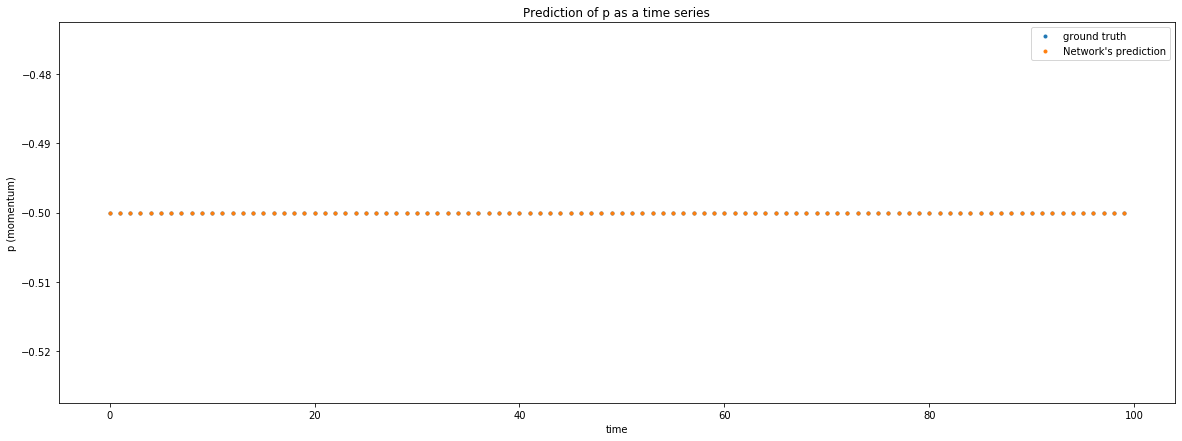

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 0.0018158928534474565
The training MSE for the 2-th dimension is 5.569885834013515e-08


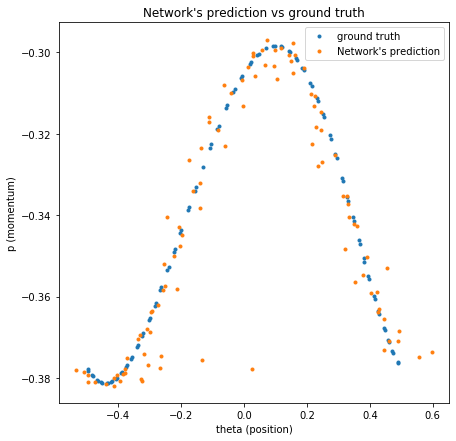

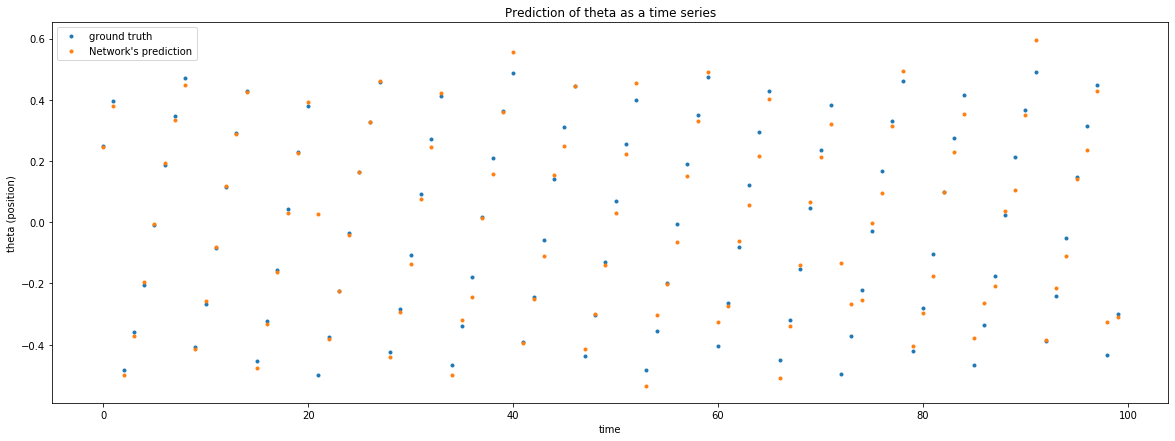

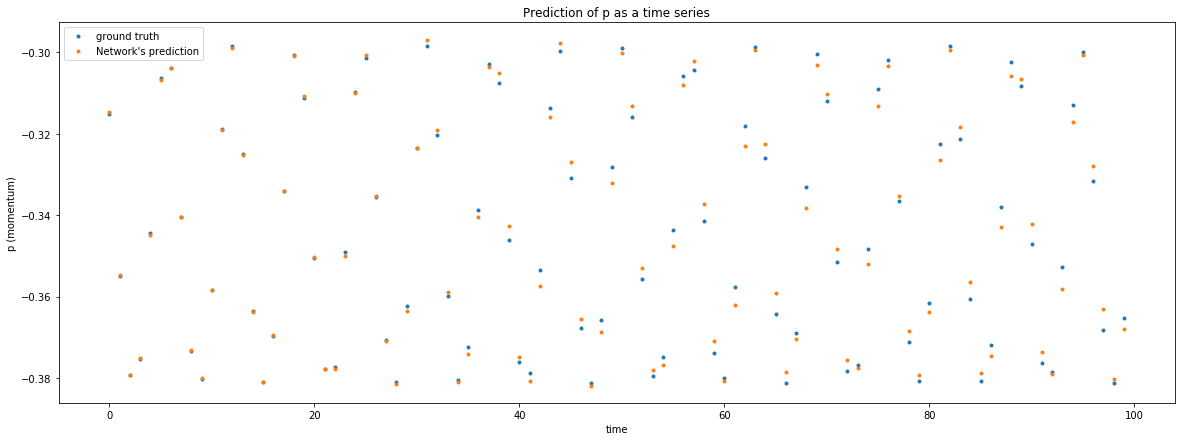

The test MSE for the 1-th dimension is 0.005653931479871975
The test MSE for the 2-th dimension is 5.908480930221211e-06
The 84 NRMSE for the 1-th dimension is 9.194991218610804
The 84 NRMSE for the 2-th dimension is 2.9872069863290496

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.0016897060126719314
The training MSE for the 2-th dimension is 3.975226097190624e-08


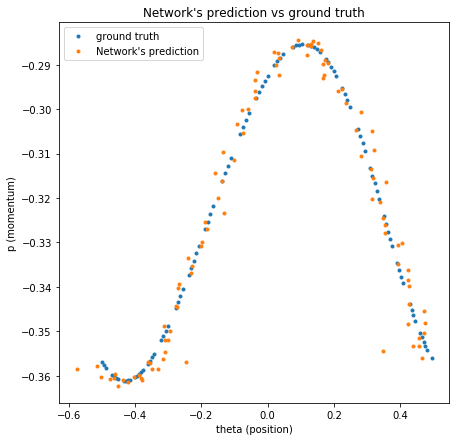

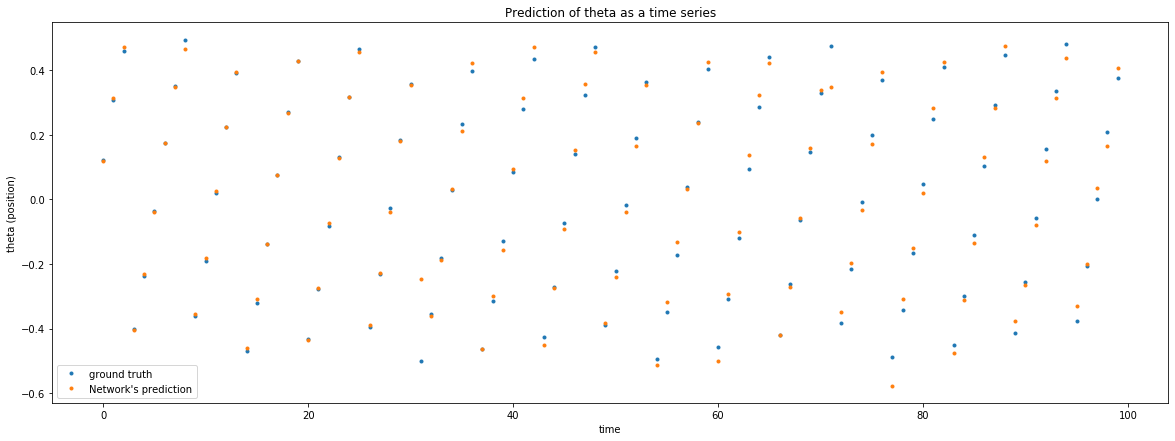

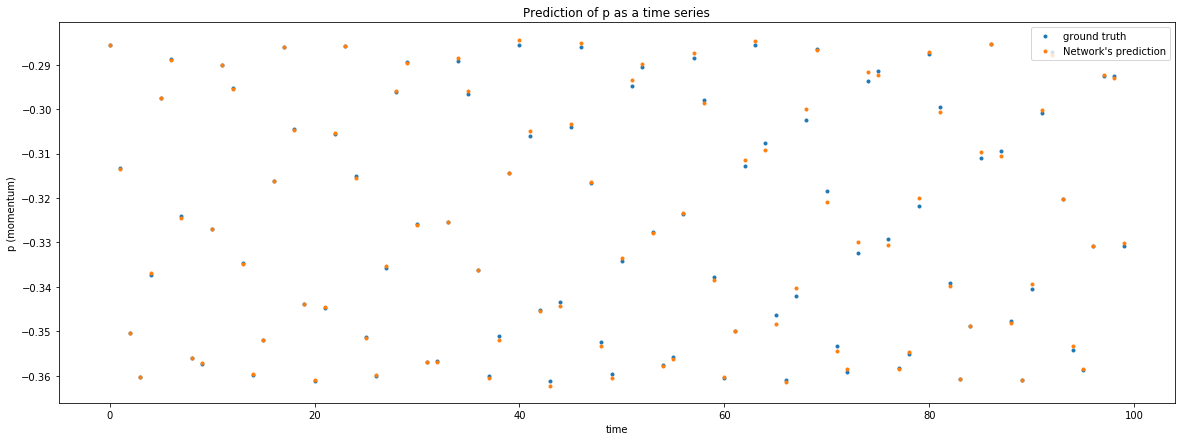

The test MSE for the 1-th dimension is 0.0013131379232590606
The test MSE for the 2-th dimension is 6.961917964680724e-07
The 84 NRMSE for the 1-th dimension is 4.997007472372802
The 84 NRMSE for the 2-th dimension is 1.0506464255870394

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 5.005188068098895e-07
The training MSE for the 2-th dimension is 0.002129627722107886


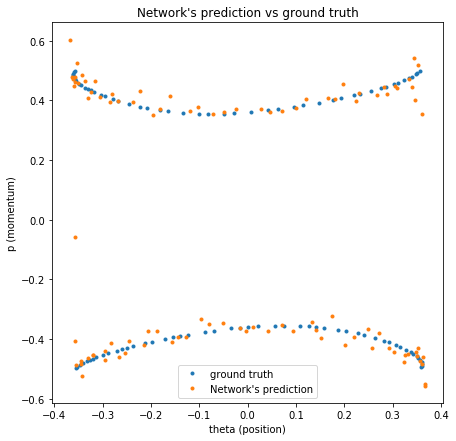

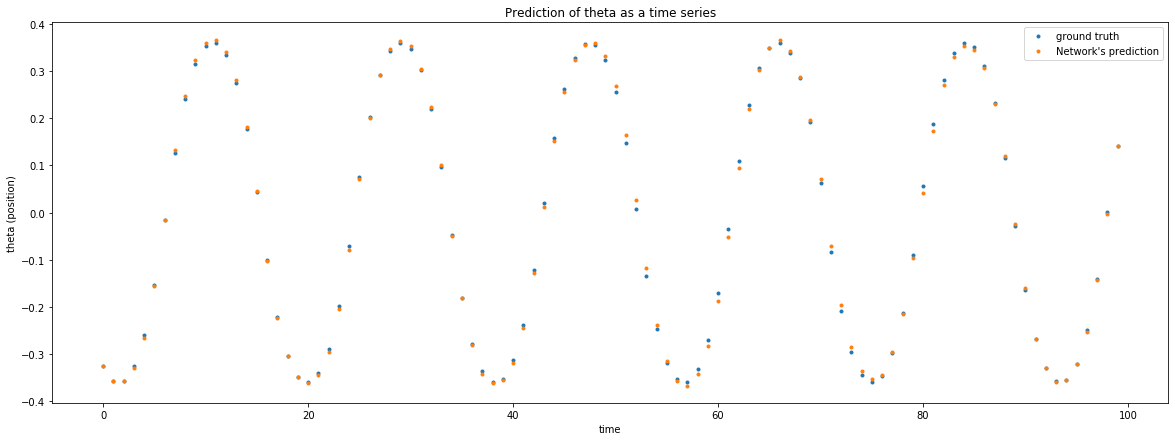

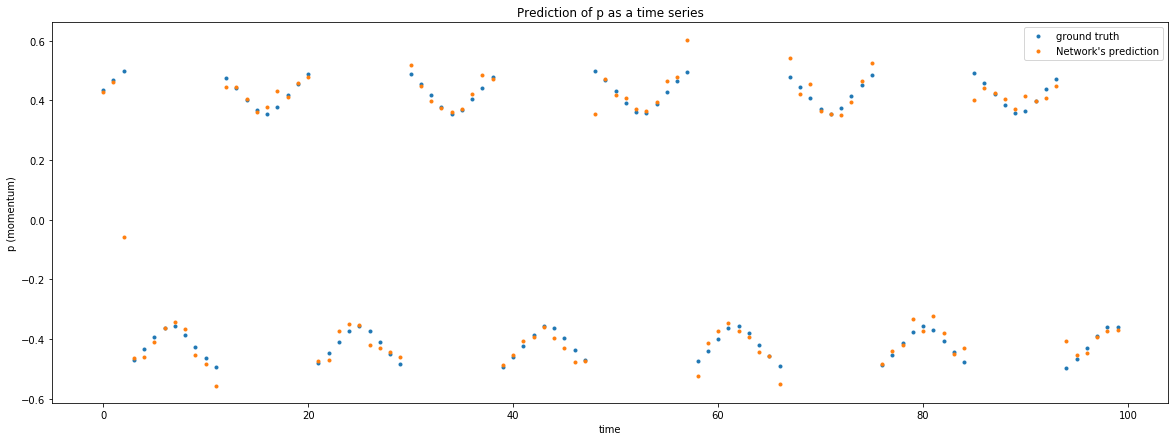

The test MSE for the 1-th dimension is 5.2248168101807985e-05
The test MSE for the 2-th dimension is 0.004194589009552698
The 84 NRMSE for the 1-th dimension is 1.3668107391420596
The 84 NRMSE for the 2-th dimension is 3.2625371253229534

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.0012606916552115929
The training MSE for the 2-th dimension is 1.5929587649616096e-07


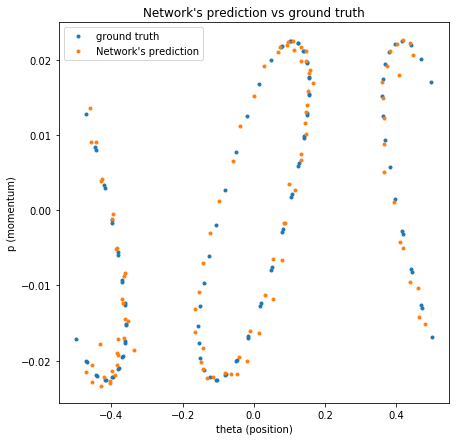

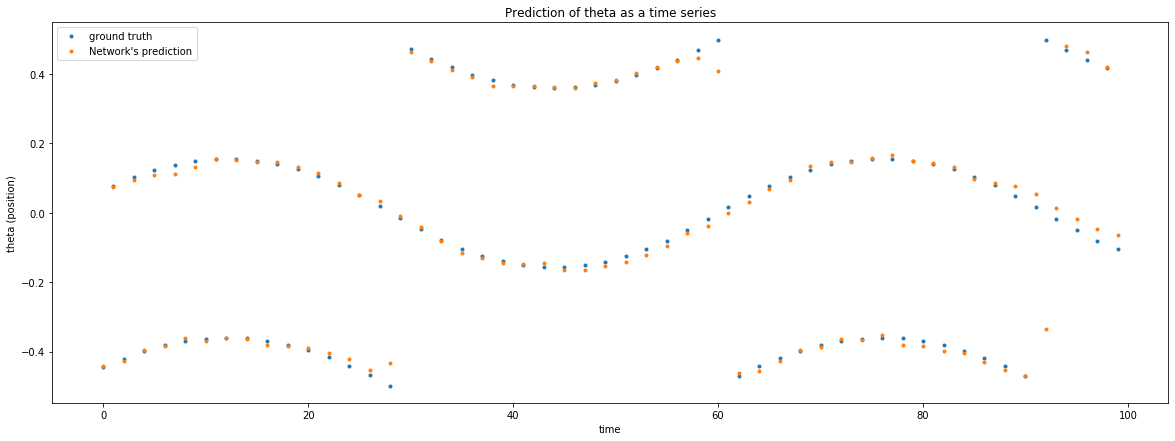

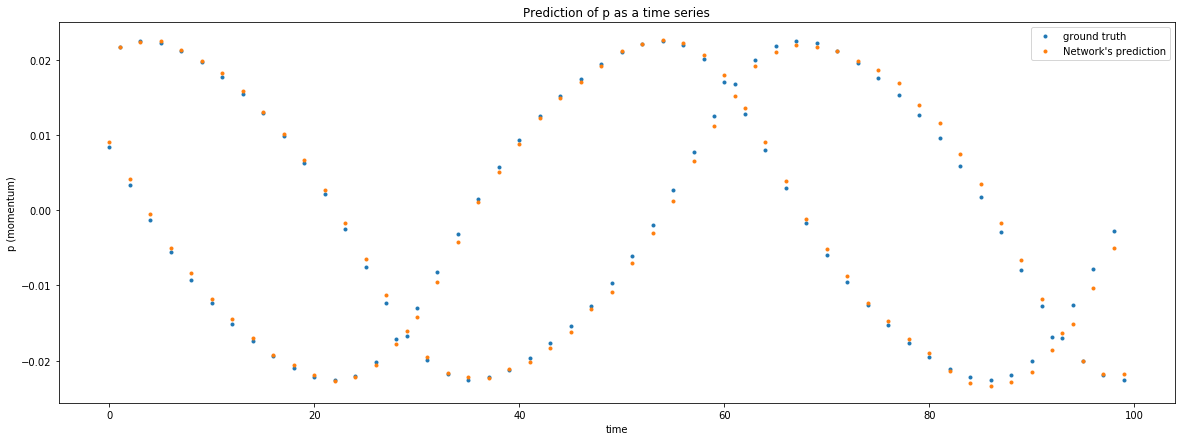

The test MSE for the 1-th dimension is 0.007276563341003203
The test MSE for the 2-th dimension is 8.071897173550672e-07
The 84 NRMSE for the 1-th dimension is 1.9639100202617066
The 84 NRMSE for the 2-th dimension is 1.7754198764609623

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 0.00048648691082199655
The training MSE for the 2-th dimension is 1.2724573670540364e-08


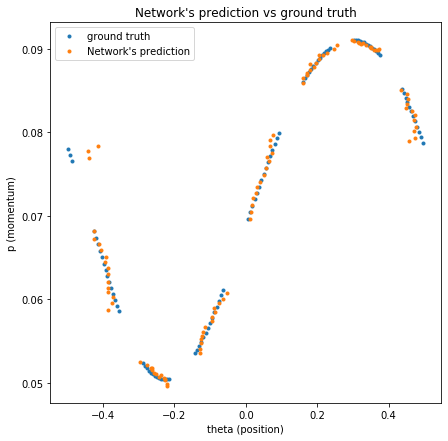

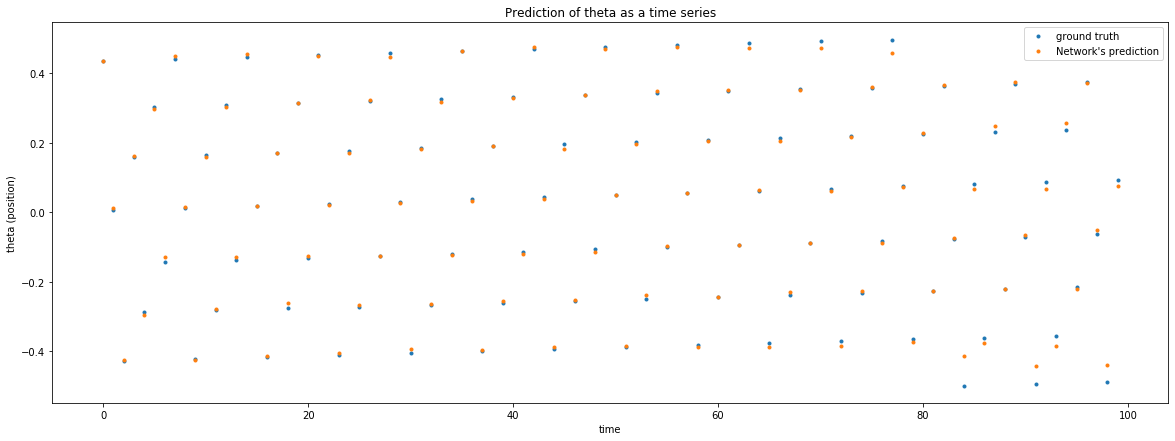

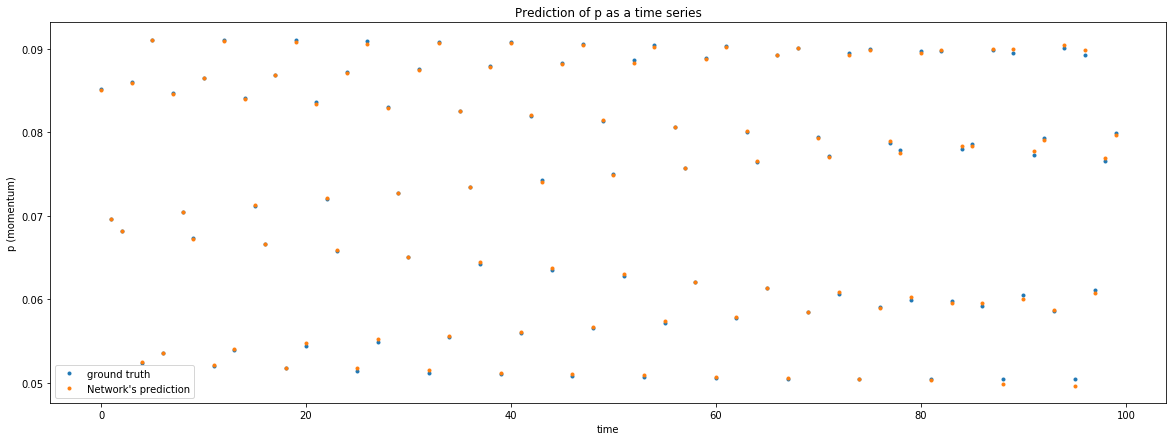

The test MSE for the 1-th dimension is 0.00019711662555366752
The test MSE for the 2-th dimension is 4.7705025365437576e-08
The 84 NRMSE for the 1-th dimension is 1.8483424691992514
The 84 NRMSE for the 2-th dimension is 1.1960235702828603

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.0015435063898050782
The training MSE for the 2-th dimension is 4.6030621351554214e-08


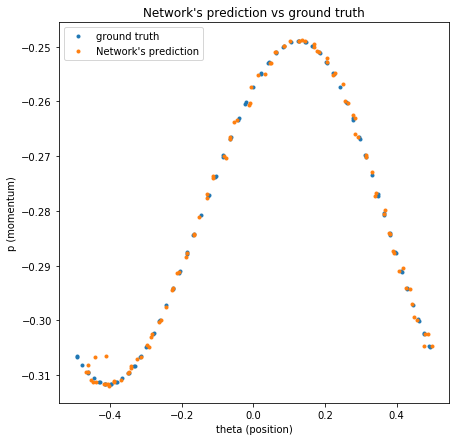

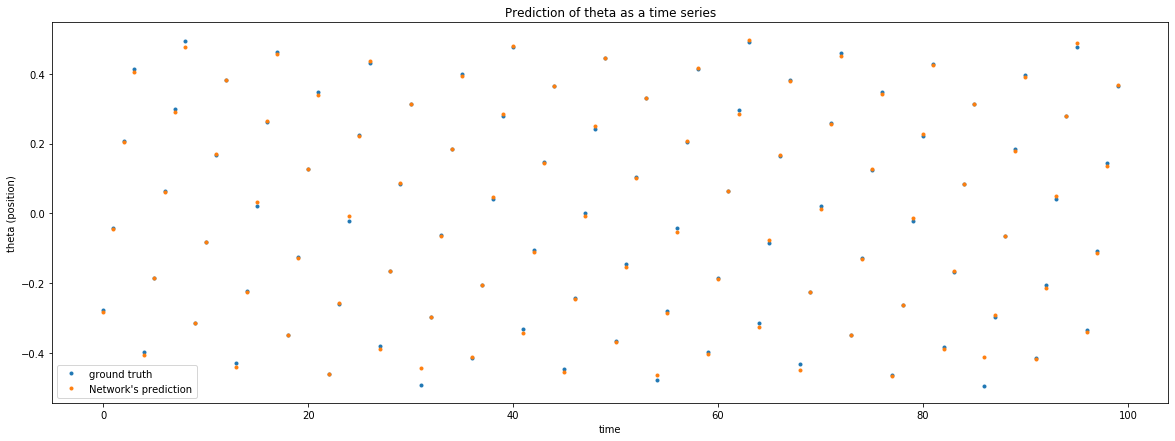

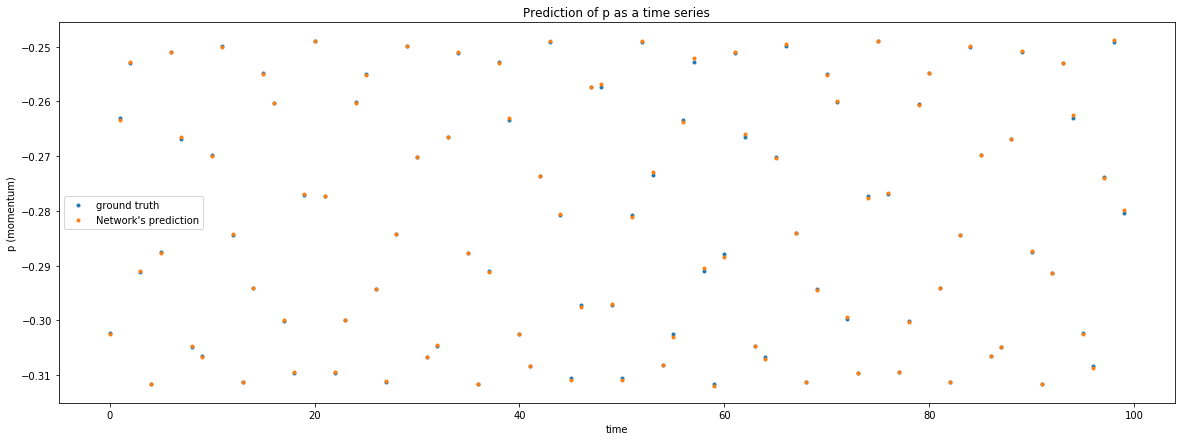

The test MSE for the 1-th dimension is 0.0001315942385738083
The test MSE for the 2-th dimension is 5.755078890994474e-08
The 84 NRMSE for the 1-th dimension is 15.054655418963806
The 84 NRMSE for the 2-th dimension is 1.119004877121283


In [33]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.25, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 2.4 K=0.5, 0.75, 0.9 <a name="Kmult" ></a>

In [34]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


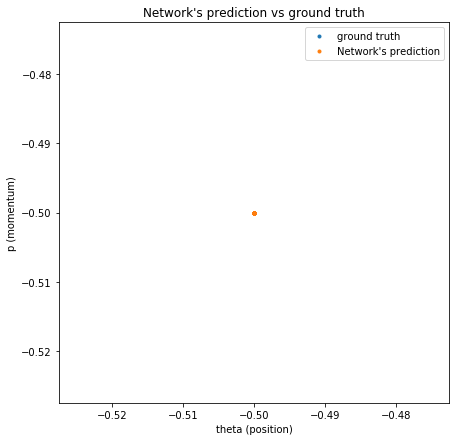

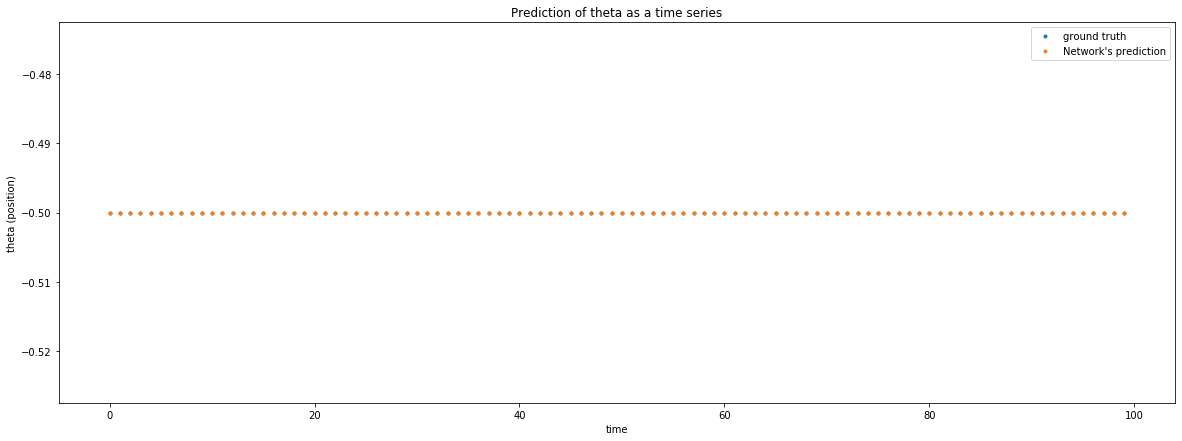

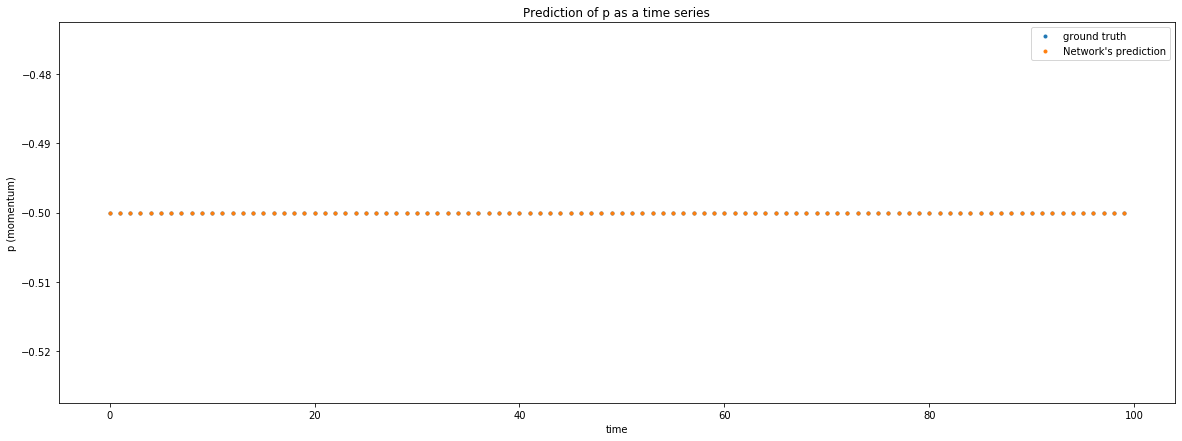

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 4.457571452058333e-06
The training MSE for the 2-th dimension is 1.8142675923058391e-07


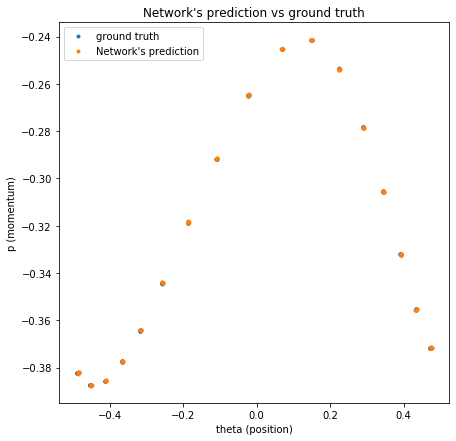

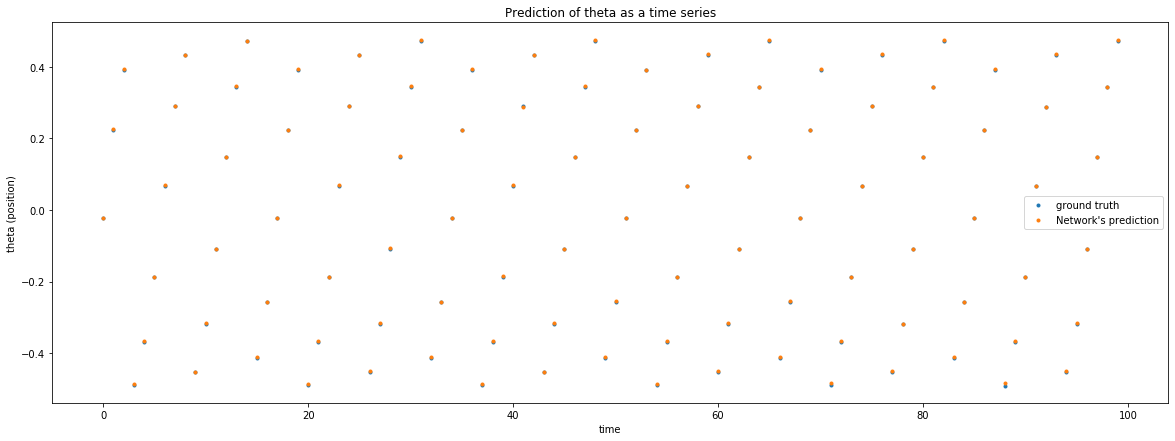

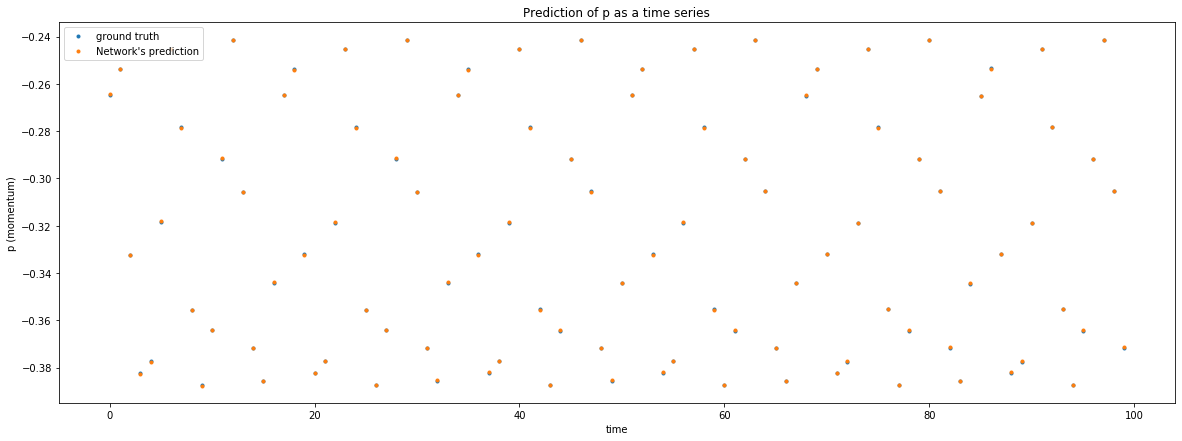

The test MSE for the 1-th dimension is 4.123532524425663e-06
The test MSE for the 2-th dimension is 3.3269364386324364e-08
The 84 NRMSE for the 1-th dimension is 0.49775123393169024
The 84 NRMSE for the 2-th dimension is 0.9465890260152461

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.0008444842329176567
The training MSE for the 2-th dimension is 1.386361990555628e-07


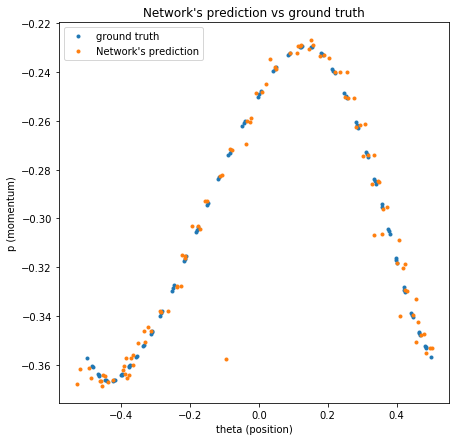

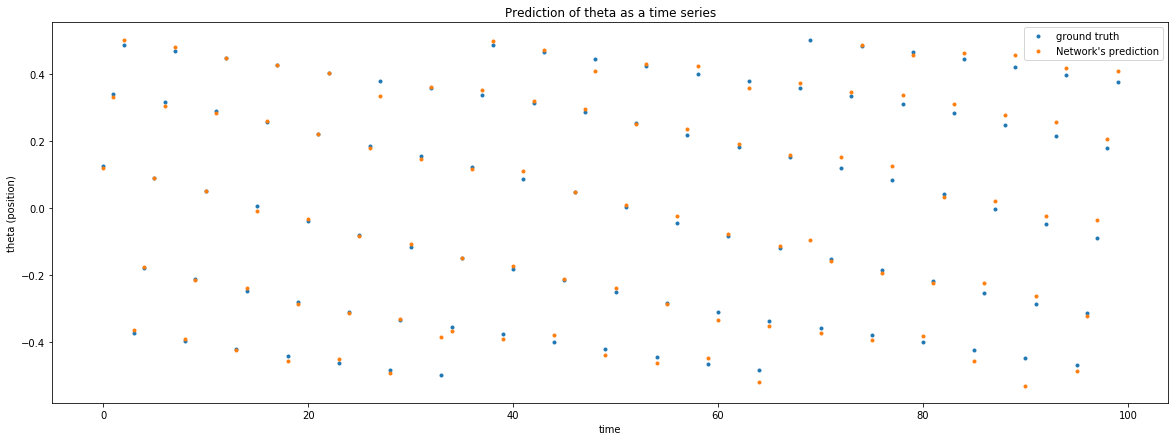

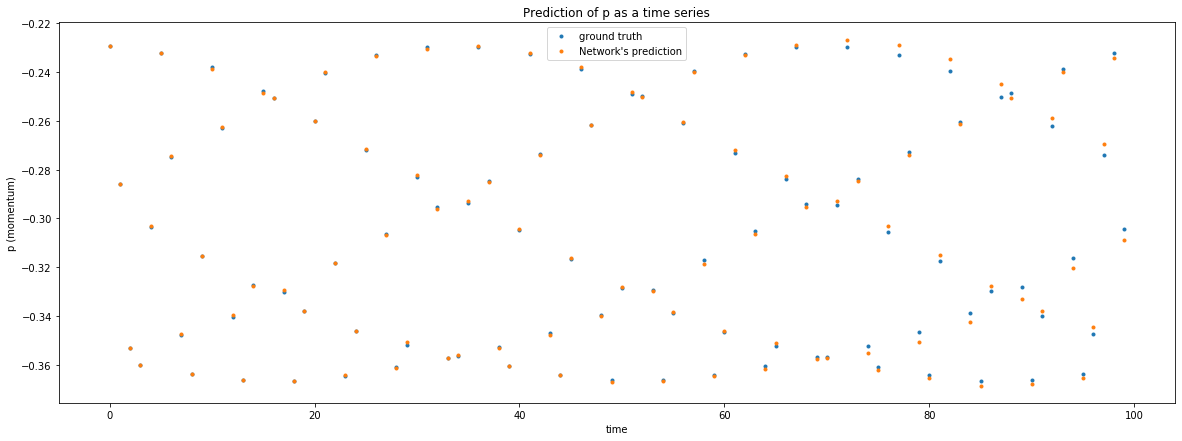

The test MSE for the 1-th dimension is 0.0040584997981939035
The test MSE for the 2-th dimension is 2.934785800423218e-06
The 84 NRMSE for the 1-th dimension is 3.3031951142688065
The 84 NRMSE for the 2-th dimension is 1.646618041665811

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 6.784328140030694e-07
The training MSE for the 2-th dimension is 0.0017397918517223353


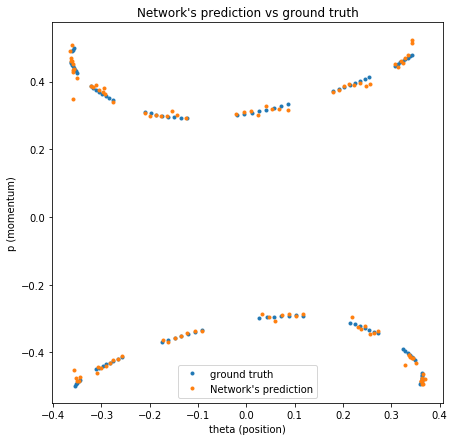

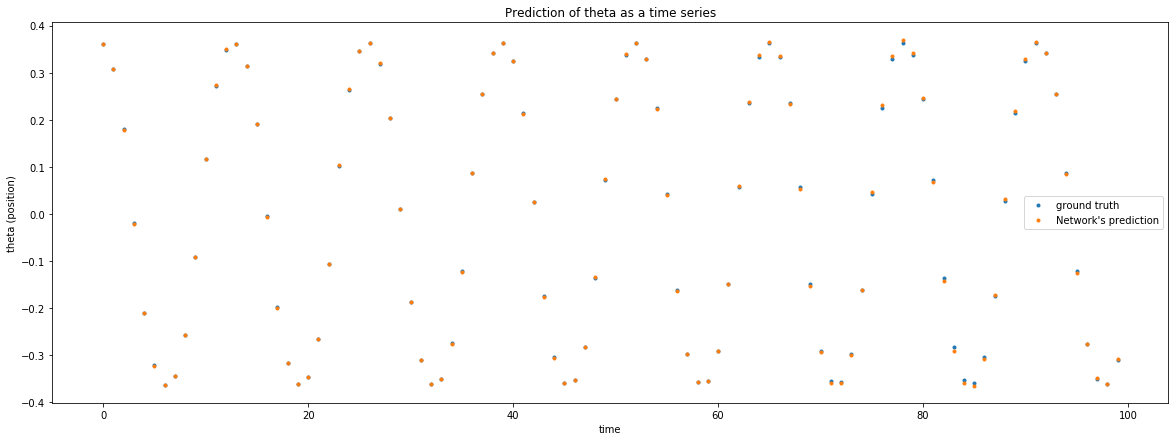

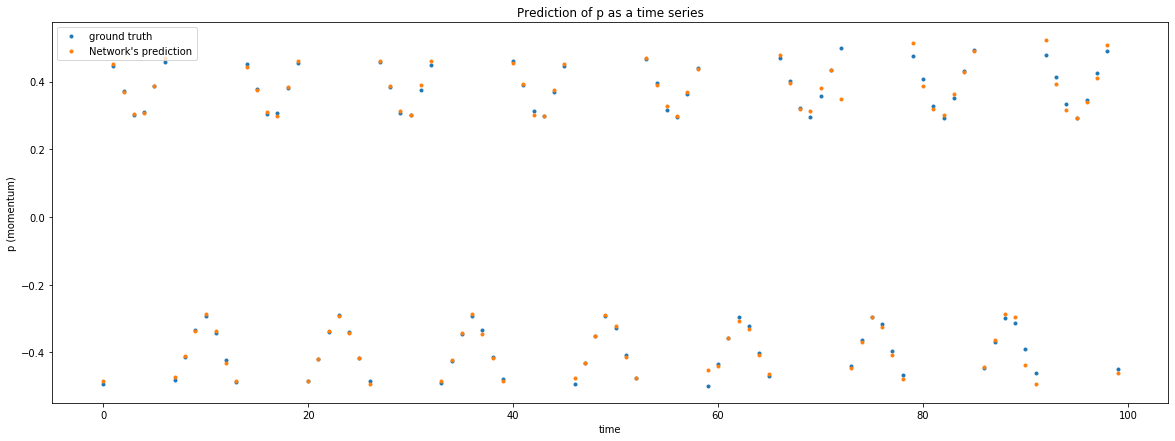

The test MSE for the 1-th dimension is 5.795696713164965e-06
The test MSE for the 2-th dimension is 0.00037273743787519486
The 84 NRMSE for the 1-th dimension is 1.064997917525548
The 84 NRMSE for the 2-th dimension is 3.93625532533704

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.0010032403486228342
The training MSE for the 2-th dimension is 1.4007594114750334e-07


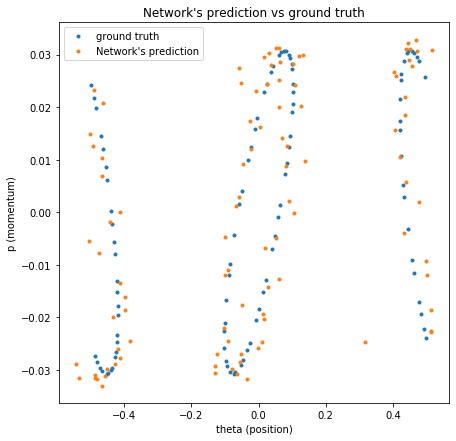

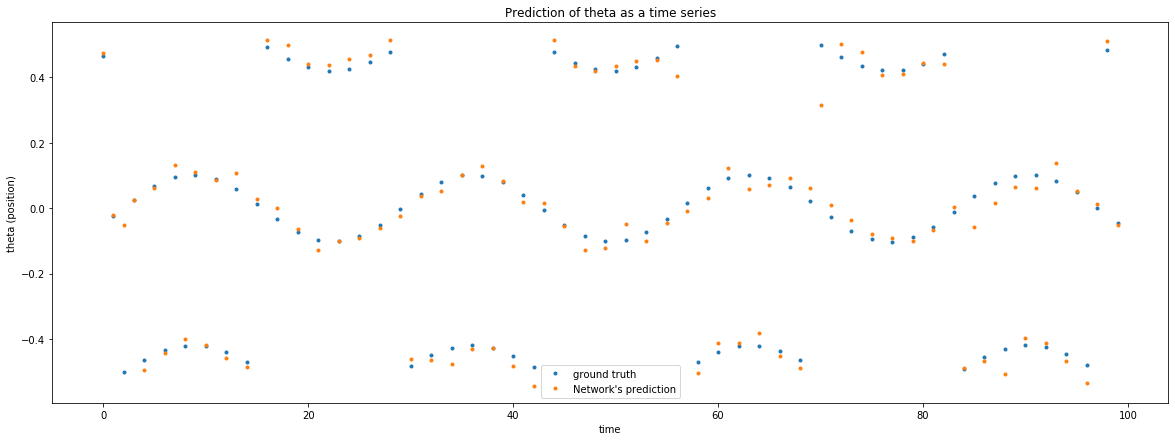

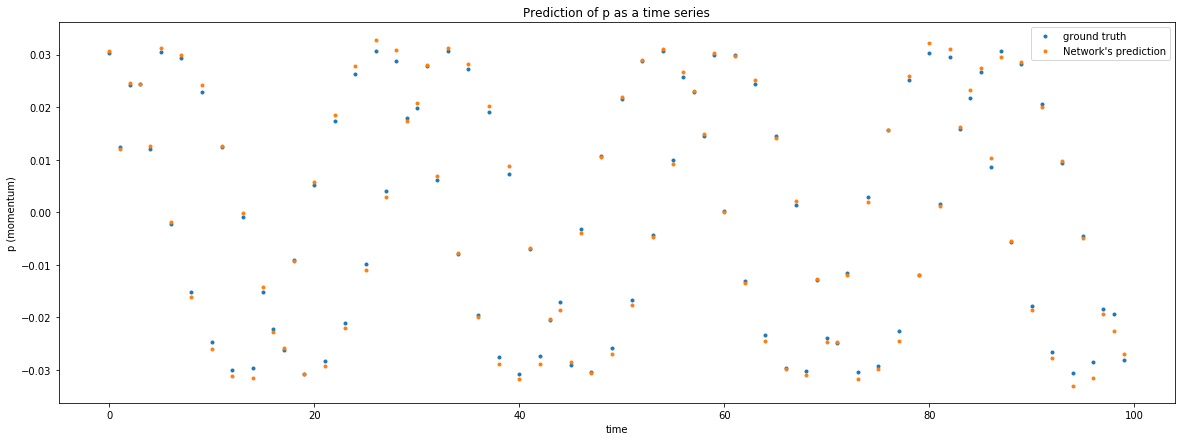

The test MSE for the 1-th dimension is 0.0032292601262791294
The test MSE for the 2-th dimension is 1.074708489059641e-06
The 84 NRMSE for the 1-th dimension is 3.233016118035348
The 84 NRMSE for the 2-th dimension is 2.3617667893852246

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 0.0006188183556046953
The training MSE for the 2-th dimension is 4.966473850756743e-08


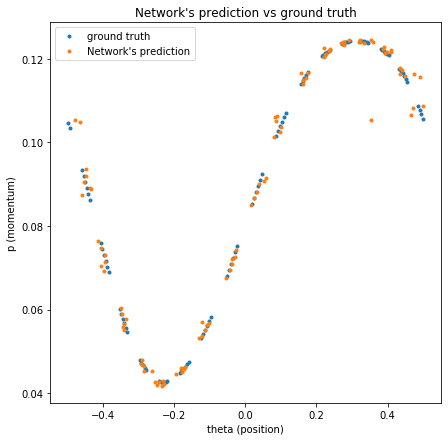

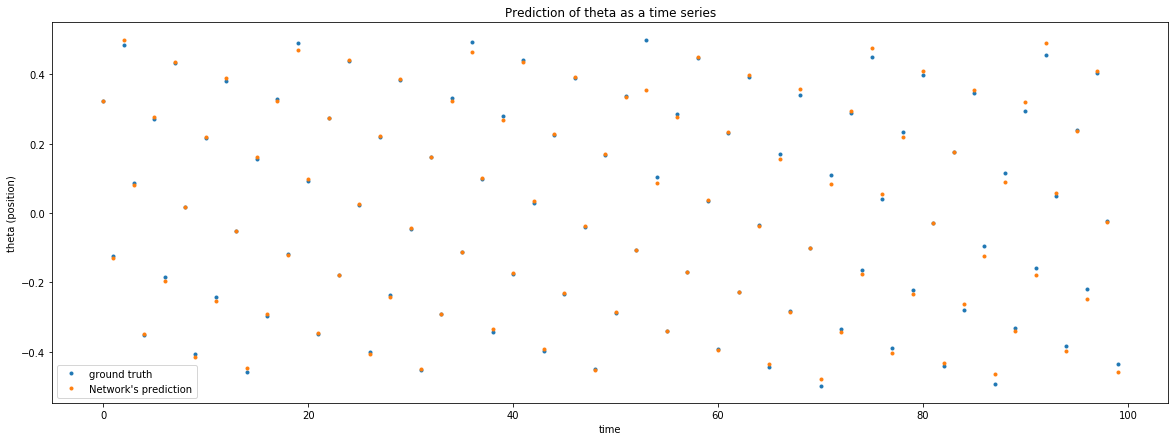

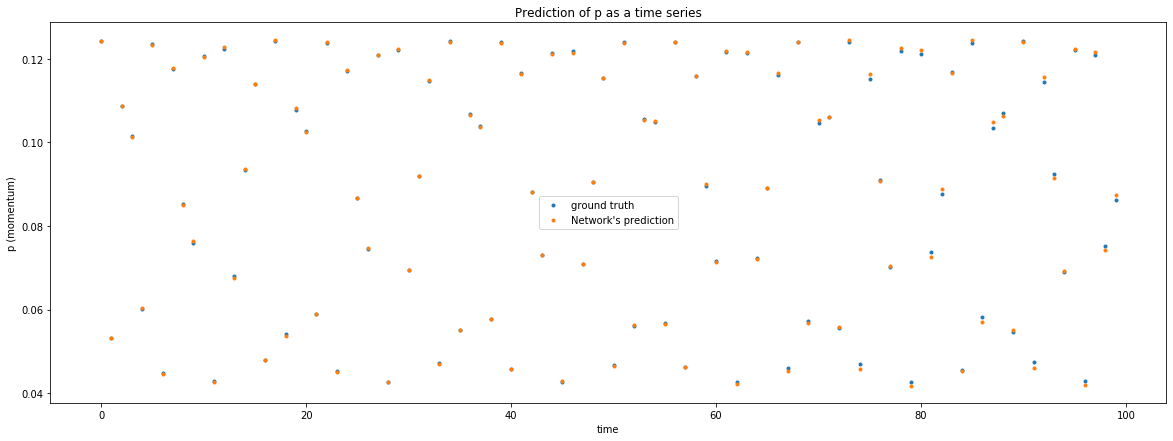

The test MSE for the 1-th dimension is 0.00034147102373511417
The test MSE for the 2-th dimension is 2.621891179034729e-07
The 84 NRMSE for the 1-th dimension is 2.9489771985542945
The 84 NRMSE for the 2-th dimension is 1.1488159495099188

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.0007679605412993044
The training MSE for the 2-th dimension is 3.4998256852099976e-07


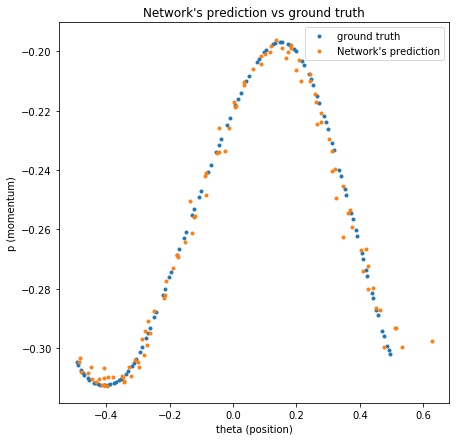

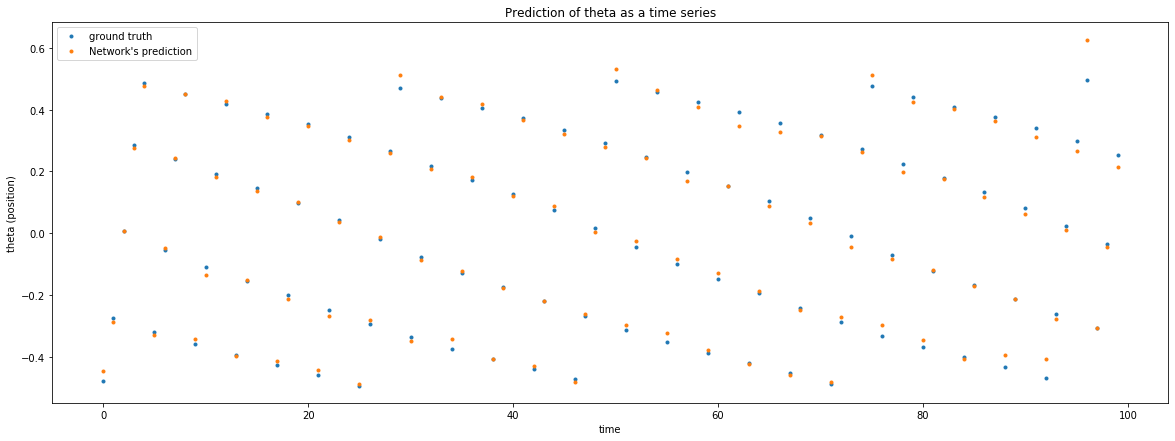

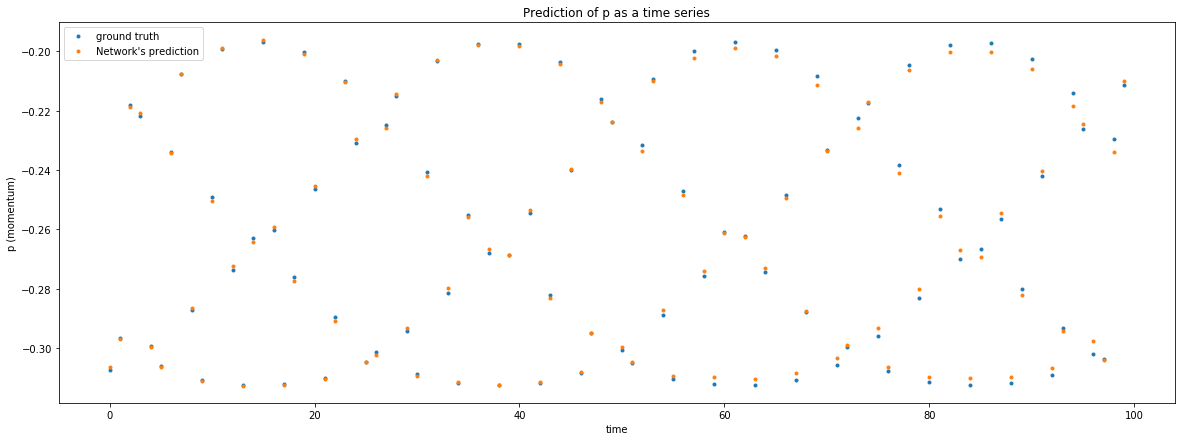

The test MSE for the 1-th dimension is 0.0005025381342386312
The test MSE for the 2-th dimension is 2.755783327254023e-06
The 84 NRMSE for the 1-th dimension is 2.4437160800461184
The 84 NRMSE for the 2-th dimension is 1.7395060007502685


In [35]:
#K=0.5
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.5, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


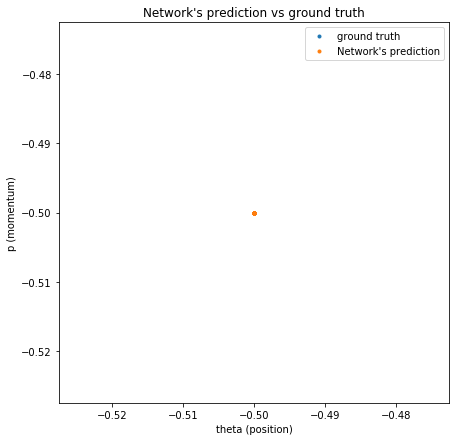

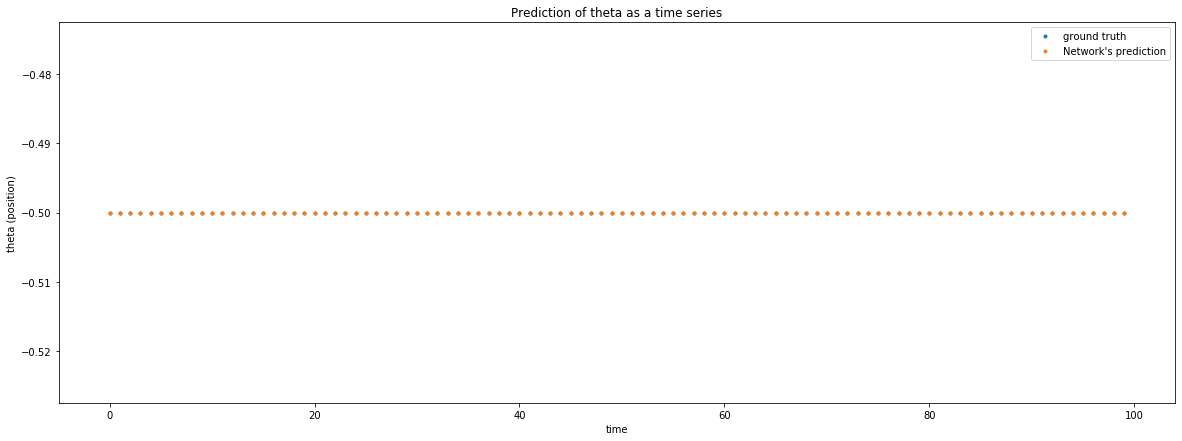

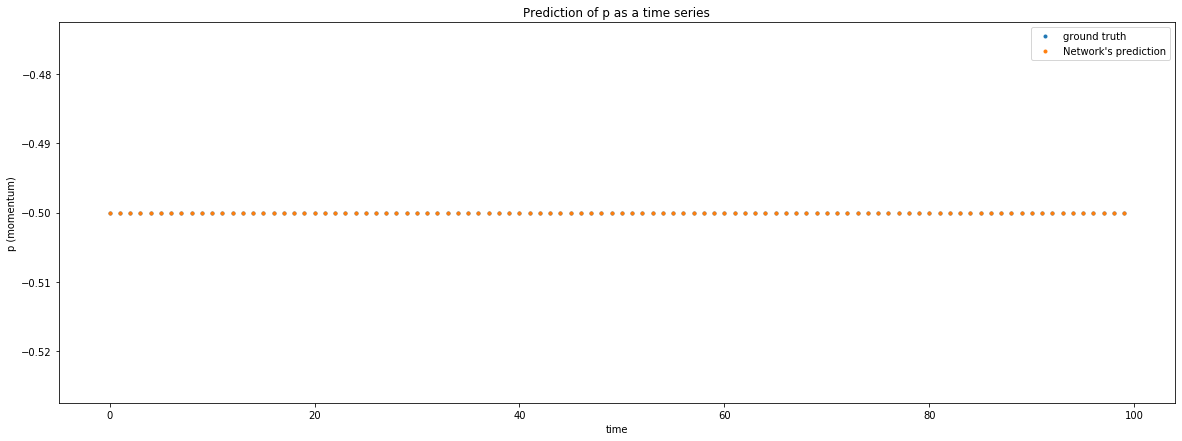

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 0.0020555514747690544
The training MSE for the 2-th dimension is 2.068130883918408e-06


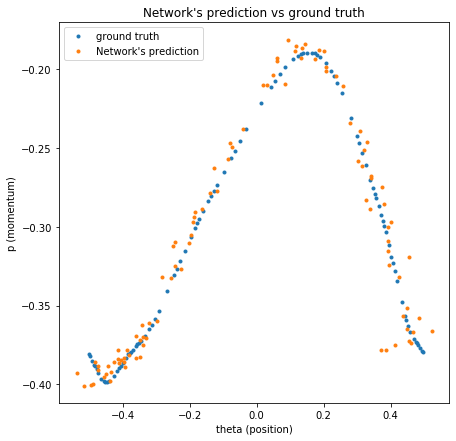

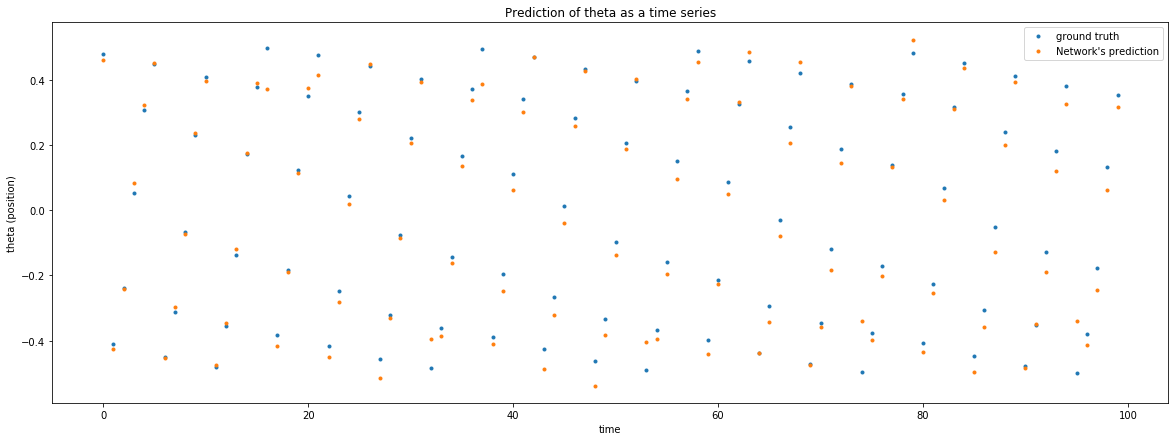

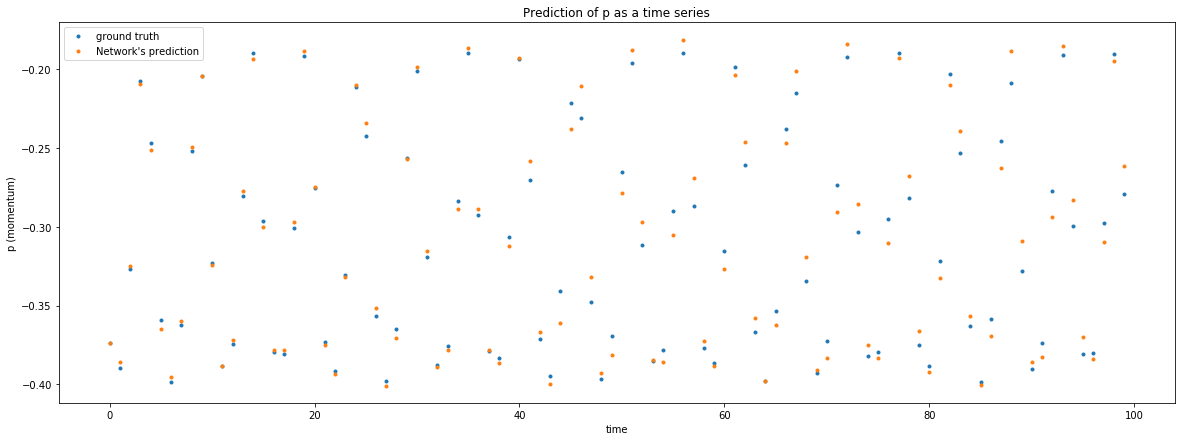

The test MSE for the 1-th dimension is 0.0020962698442332705
The test MSE for the 2-th dimension is 8.535131547943364e-05
The 84 NRMSE for the 1-th dimension is 6.065989343486877
The 84 NRMSE for the 2-th dimension is 13.231886304084894

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.0014603361190853826
The training MSE for the 2-th dimension is 3.925172539063103e-07


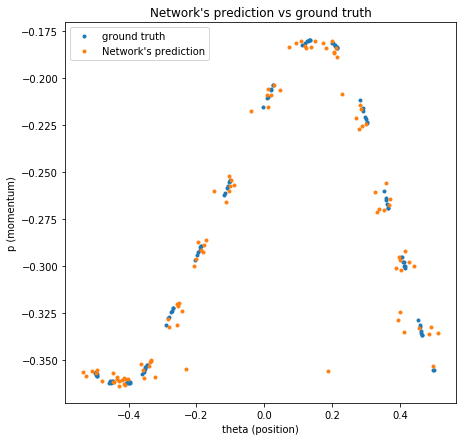

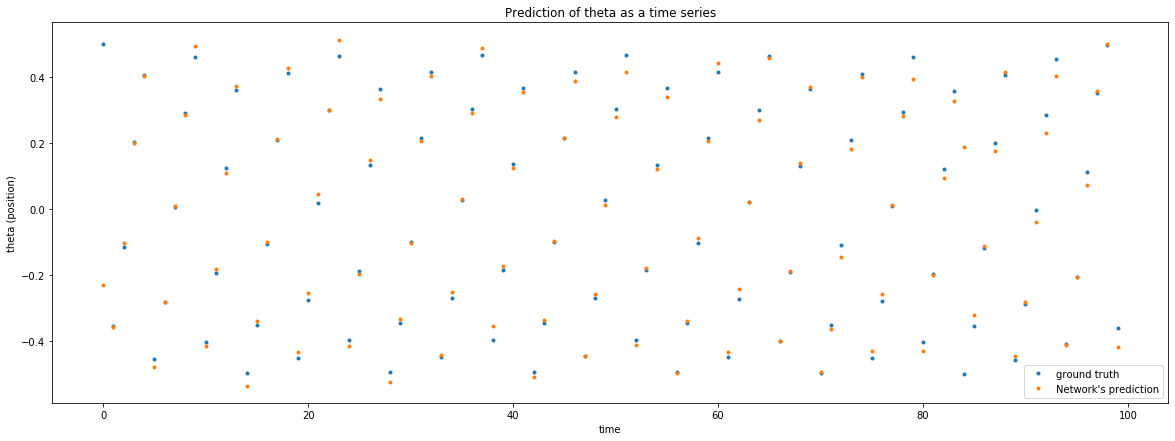

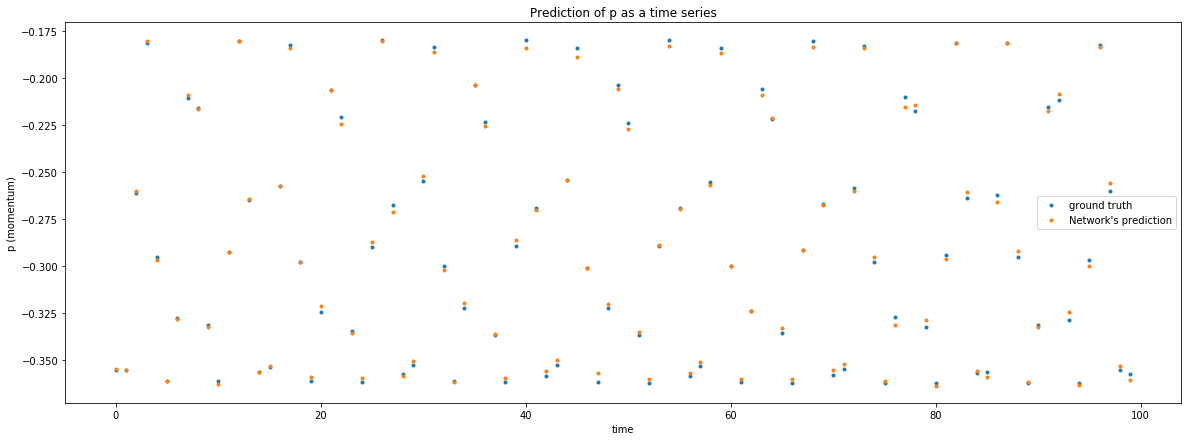

The test MSE for the 1-th dimension is 0.010534124792932071
The test MSE for the 2-th dimension is 4.968649065917042e-06
The 84 NRMSE for the 1-th dimension is 2.9496153633308078
The 84 NRMSE for the 2-th dimension is 1.6867701141304174

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 7.641342056855137e-07
The training MSE for the 2-th dimension is 0.0018405731973812546


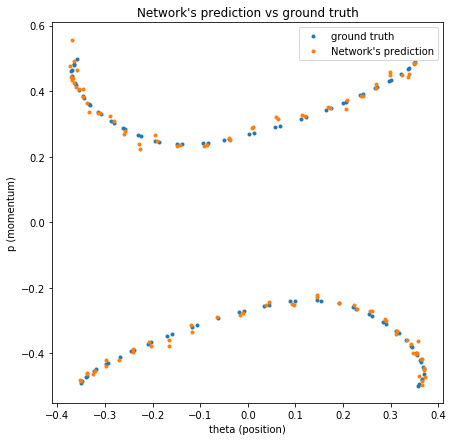

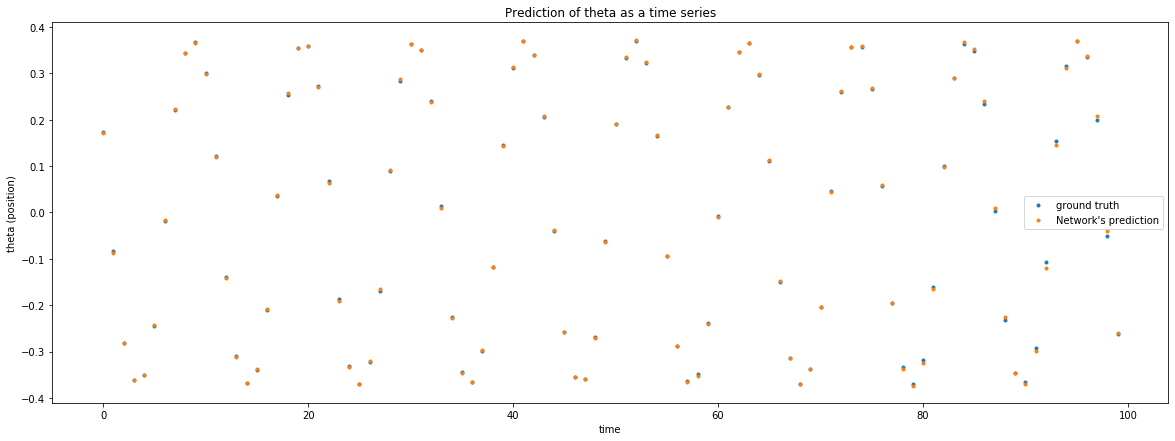

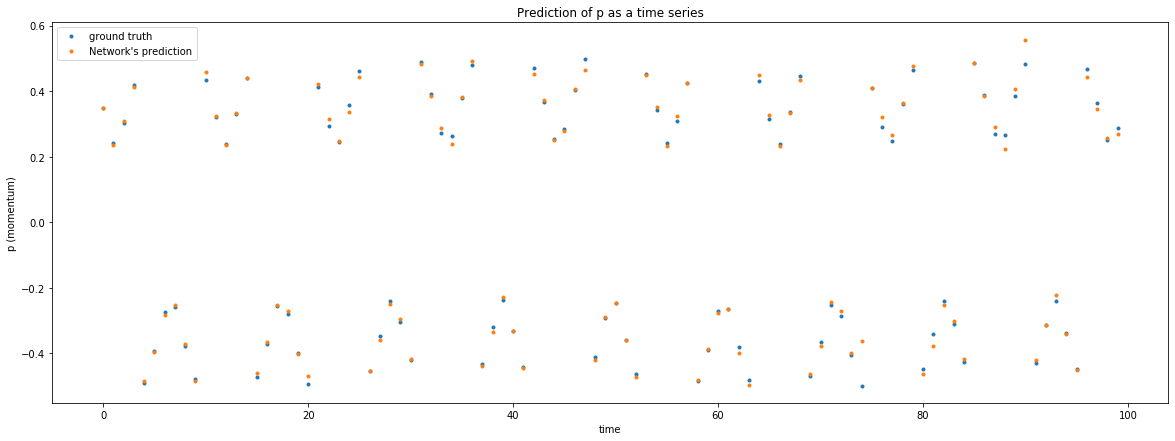

The test MSE for the 1-th dimension is 1.0685022901663866e-05
The test MSE for the 2-th dimension is 0.00040782956927554154
The 84 NRMSE for the 1-th dimension is 0.9842956231416211
The 84 NRMSE for the 2-th dimension is 8.385389866560013

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.0010167664179123572
The training MSE for the 2-th dimension is 3.7835165459772994e-07


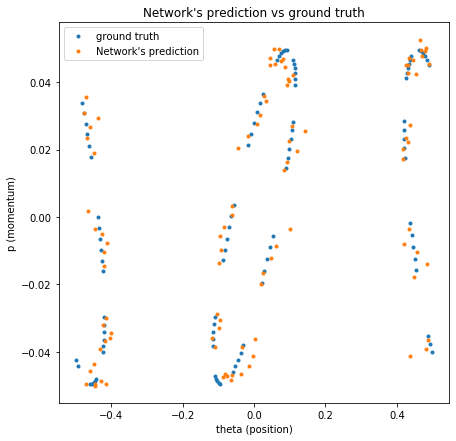

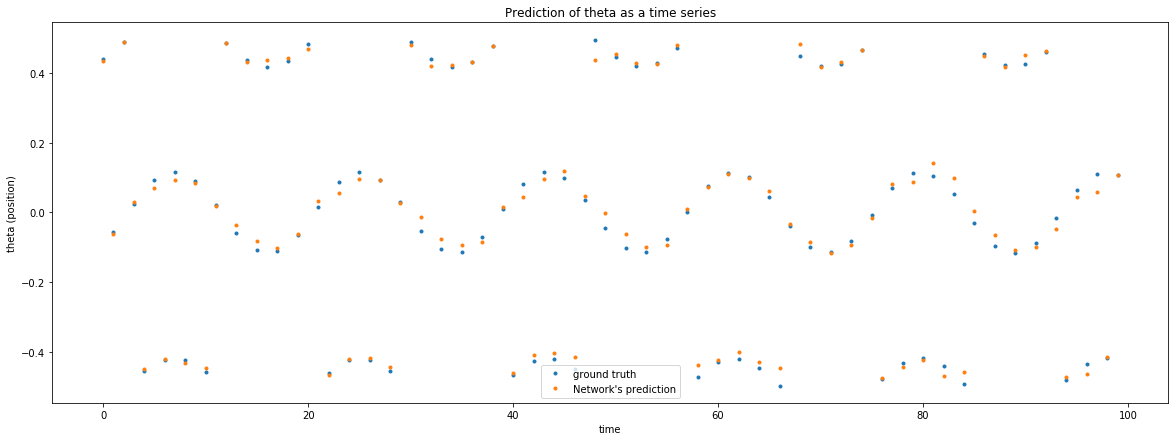

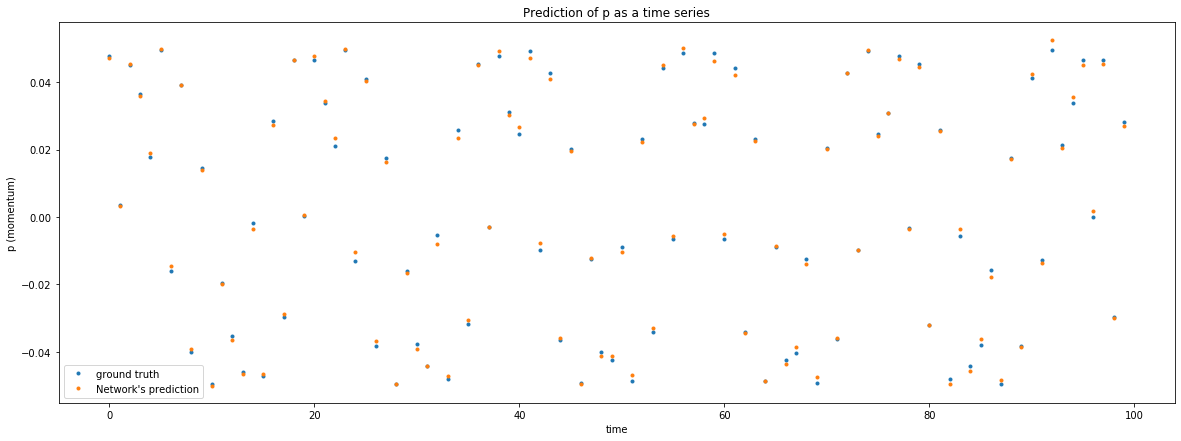

The test MSE for the 1-th dimension is 0.0004179464372508361
The test MSE for the 2-th dimension is 1.5386393850124853e-06
The 84 NRMSE for the 1-th dimension is 3.204253396989625
The 84 NRMSE for the 2-th dimension is 2.4992695359420063

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 0.001203171047479552
The training MSE for the 2-th dimension is 1.0884571797720668e-07


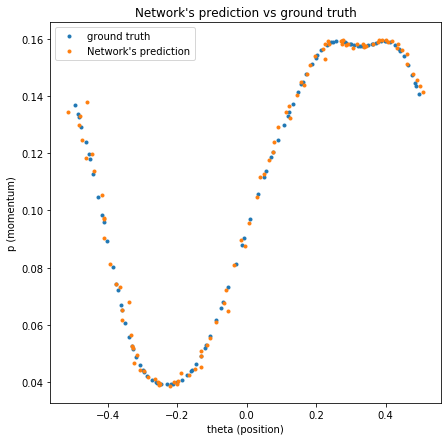

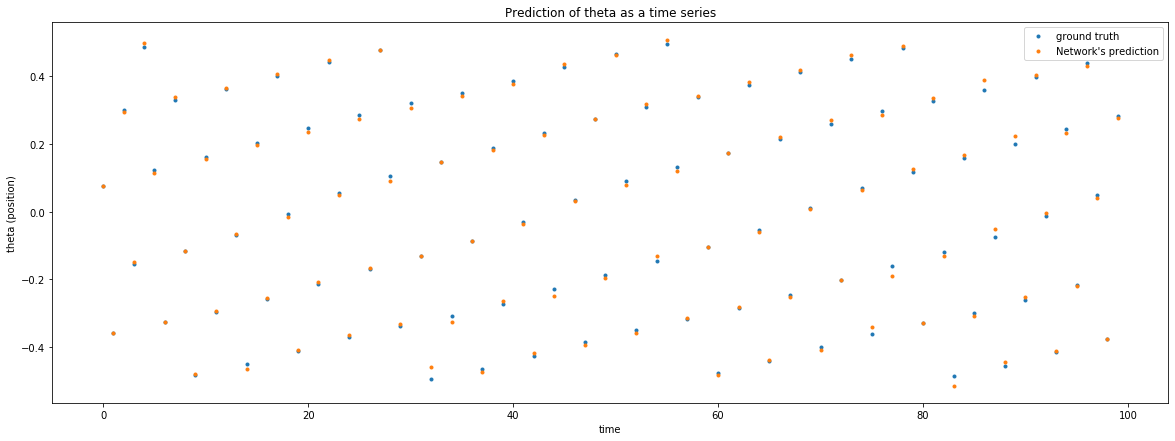

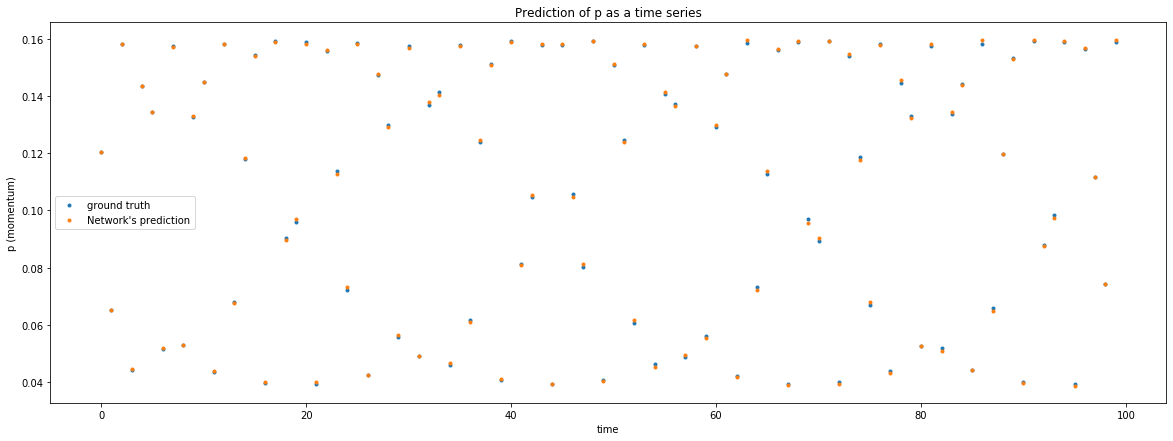

The test MSE for the 1-th dimension is 0.00011122419182326447
The test MSE for the 2-th dimension is 4.168754002055791e-07
The 84 NRMSE for the 1-th dimension is 4.716544736290808
The 84 NRMSE for the 2-th dimension is 1.6048017536085368

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.0007186801094735962
The training MSE for the 2-th dimension is 3.5923257091646194e-07


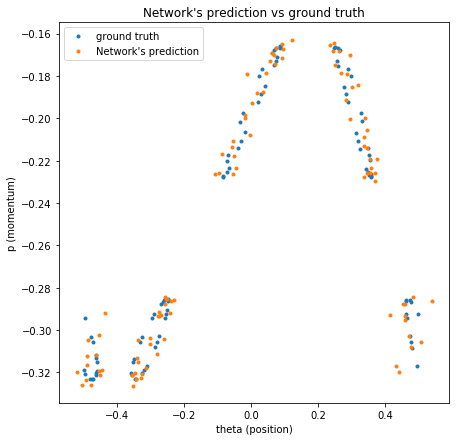

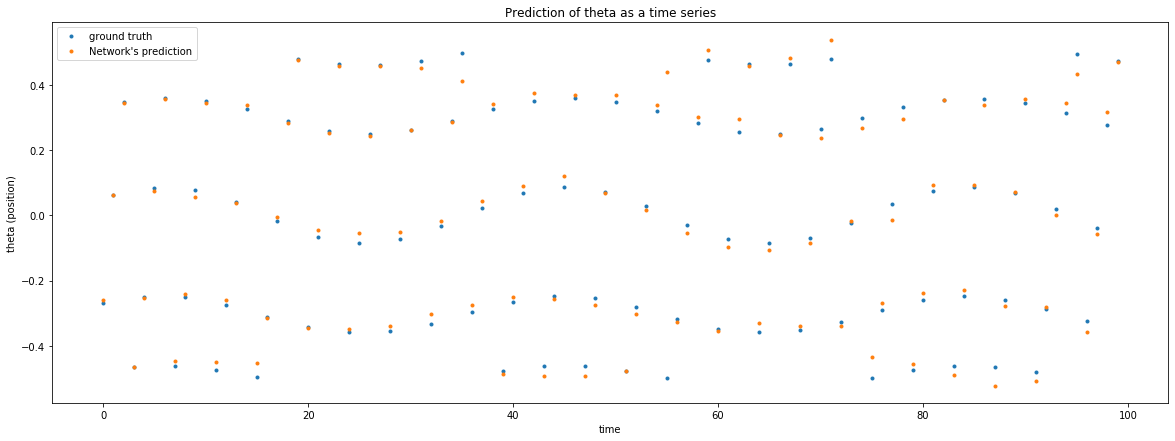

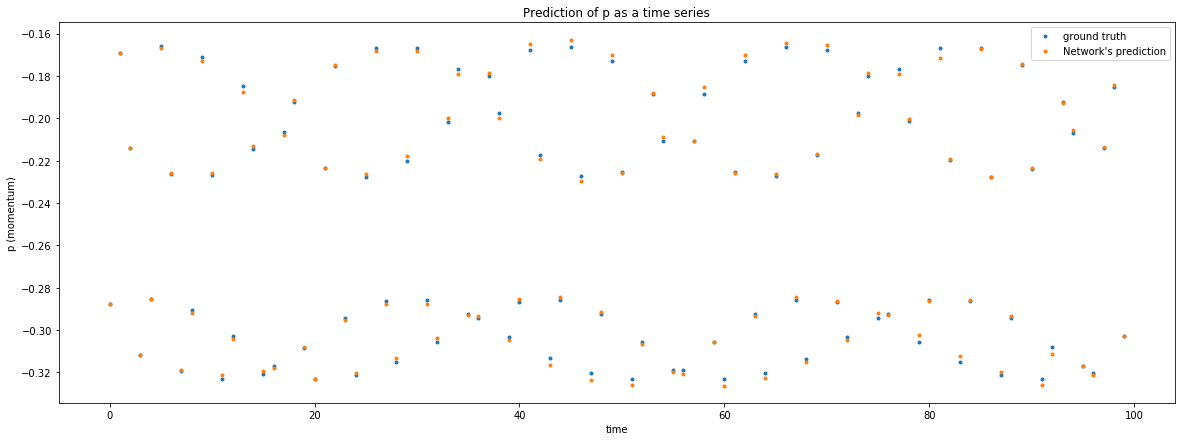

The test MSE for the 1-th dimension is 0.009413690781160012
The test MSE for the 2-th dimension is 2.7341920548465783e-06
The 84 NRMSE for the 1-th dimension is 8.30981615518106
The 84 NRMSE for the 2-th dimension is 2.5557473760872202


In [36]:
#K=0.75
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.75, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


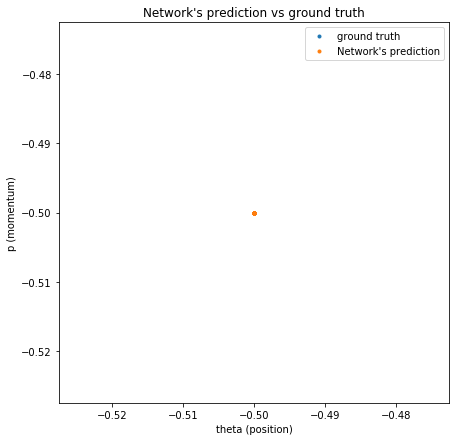

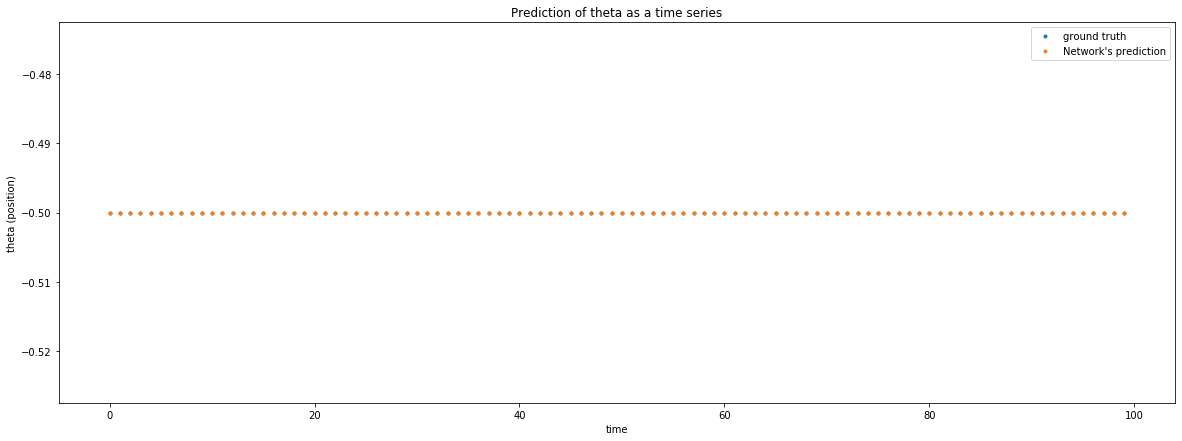

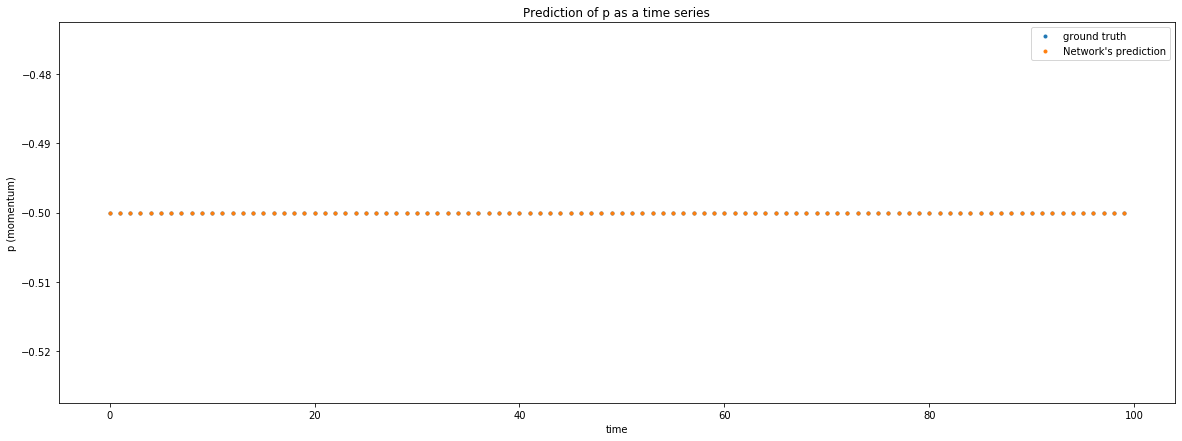

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 0.012046310926568958
The training MSE for the 2-th dimension is 0.011855467531882534


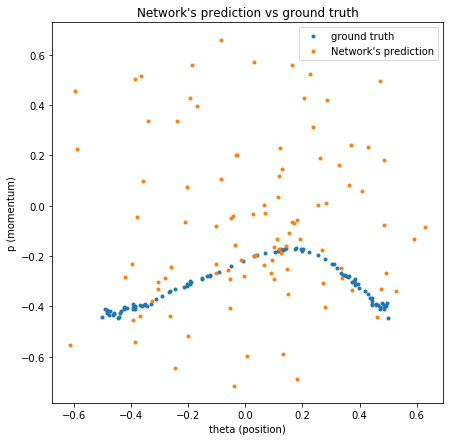

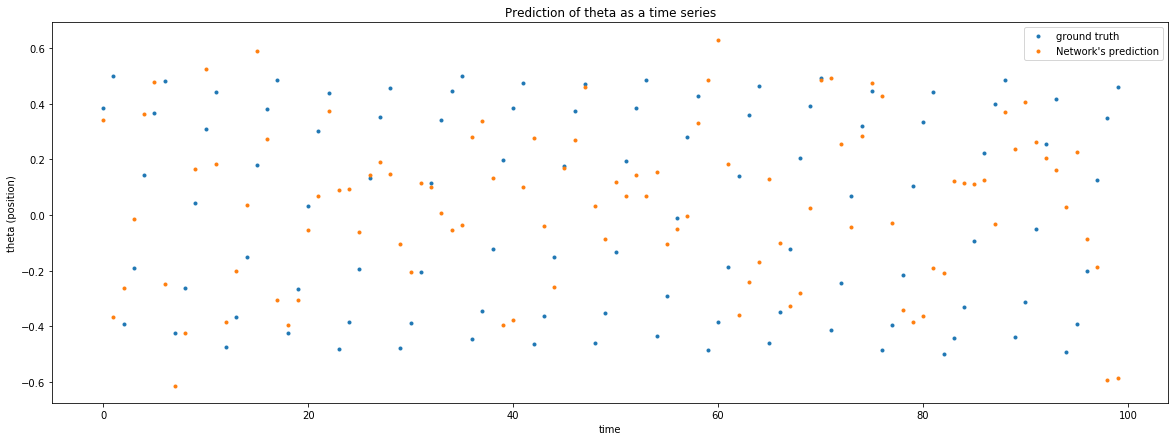

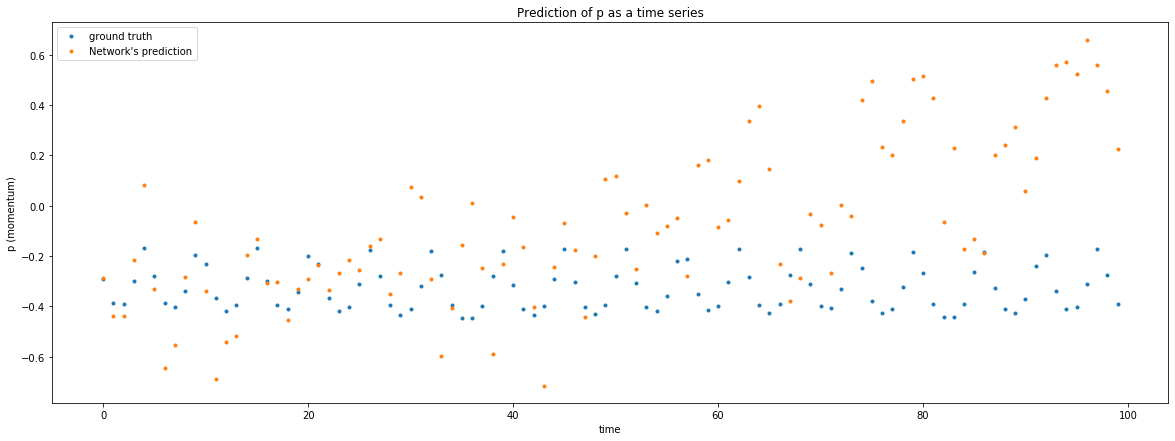

The test MSE for the 1-th dimension is 0.19870590596917542
The test MSE for the 2-th dimension is 0.16911977658107413
The 84 NRMSE for the 1-th dimension is 59.96111261449644
The 84 NRMSE for the 2-th dimension is 53.44747030145422

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.017118731972703898
The training MSE for the 2-th dimension is 0.00888227358005125


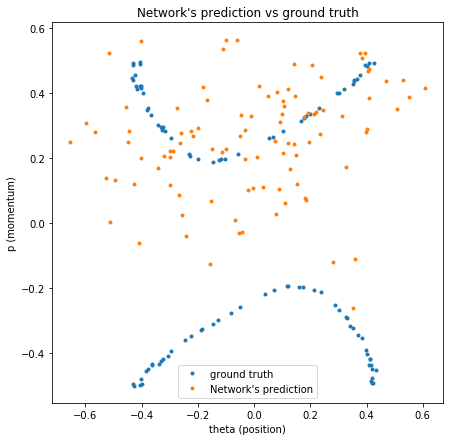

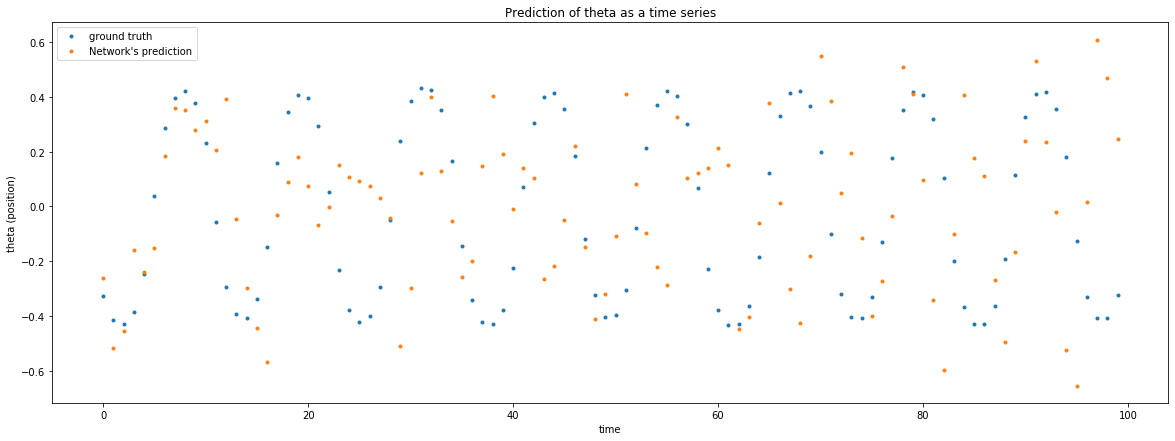

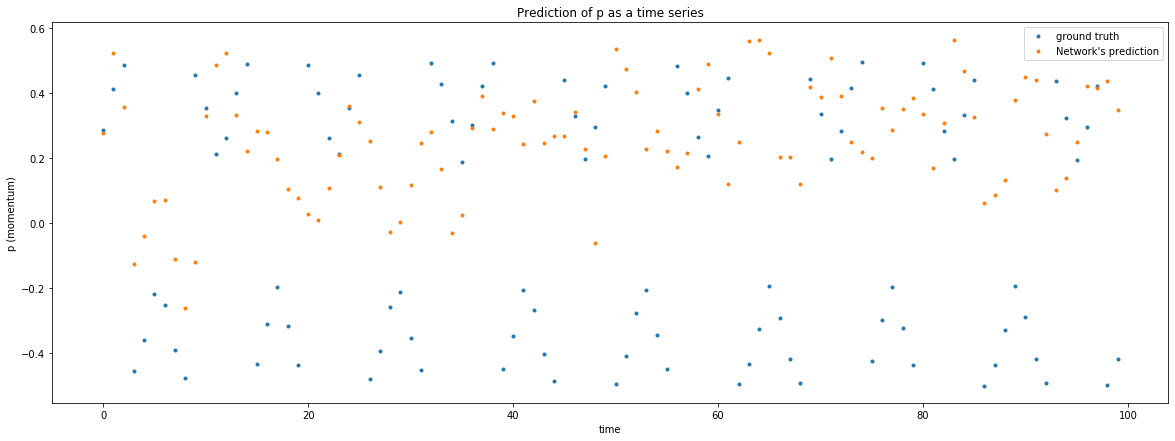

The test MSE for the 1-th dimension is 0.169432881838672
The test MSE for the 2-th dimension is 0.22507354558131973
The 84 NRMSE for the 1-th dimension is 54.476314368228365
The 84 NRMSE for the 2-th dimension is 52.11876307069245

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 1.0939628211186062e-06
The training MSE for the 2-th dimension is 0.0015120182723870525


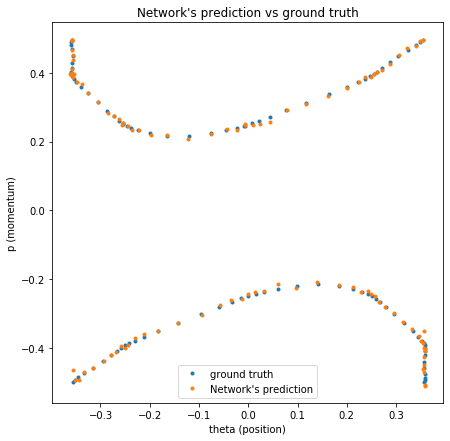

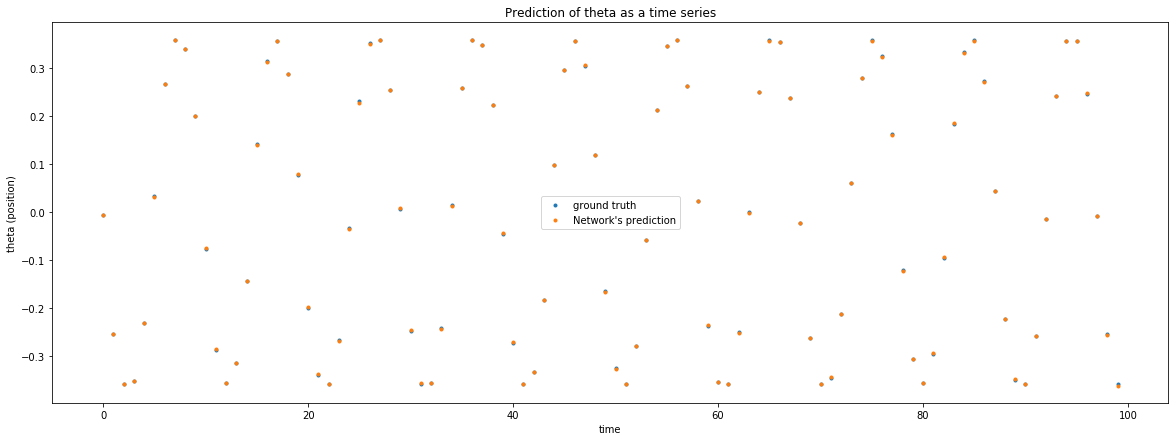

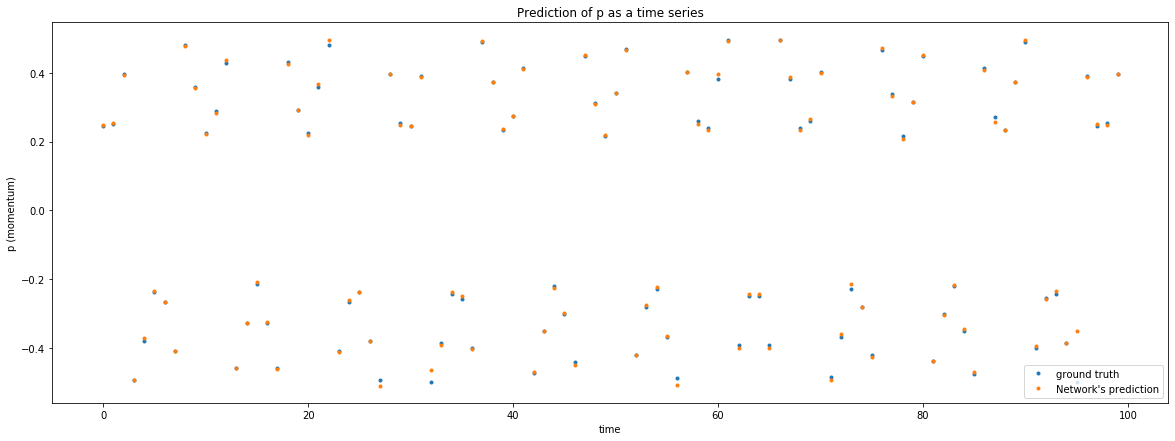

The test MSE for the 1-th dimension is 1.4106182974751229e-06
The test MSE for the 2-th dimension is 0.0002690275536875985
The 84 NRMSE for the 1-th dimension is 0.5241398073904492
The 84 NRMSE for the 2-th dimension is 1.5455407905491587

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.001170940179087236
The training MSE for the 2-th dimension is 5.119103477781406e-07


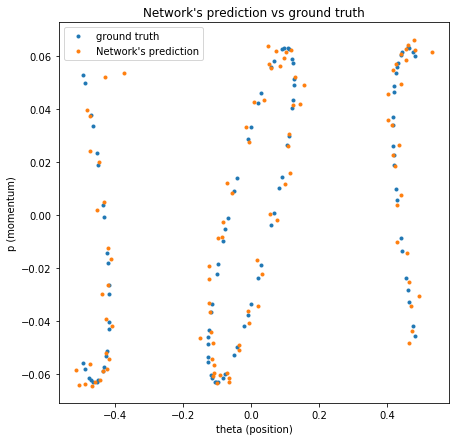

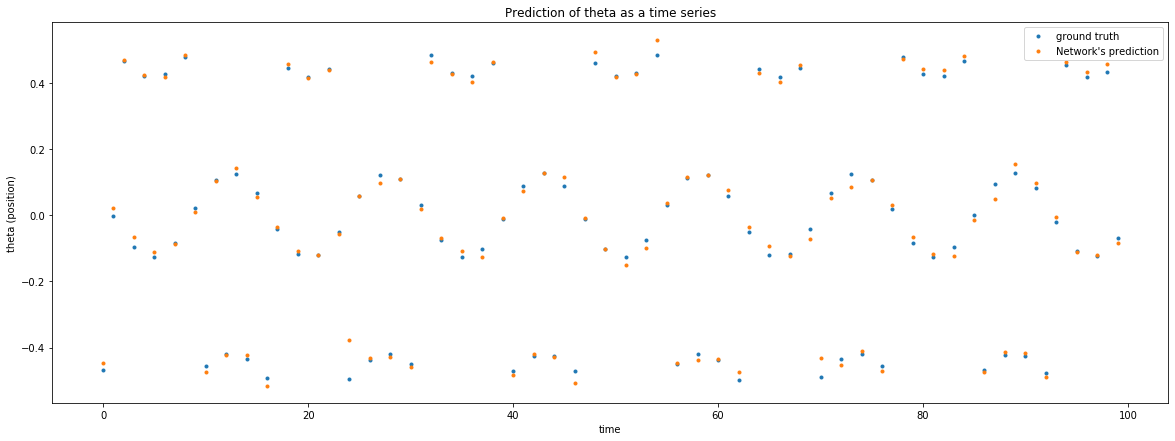

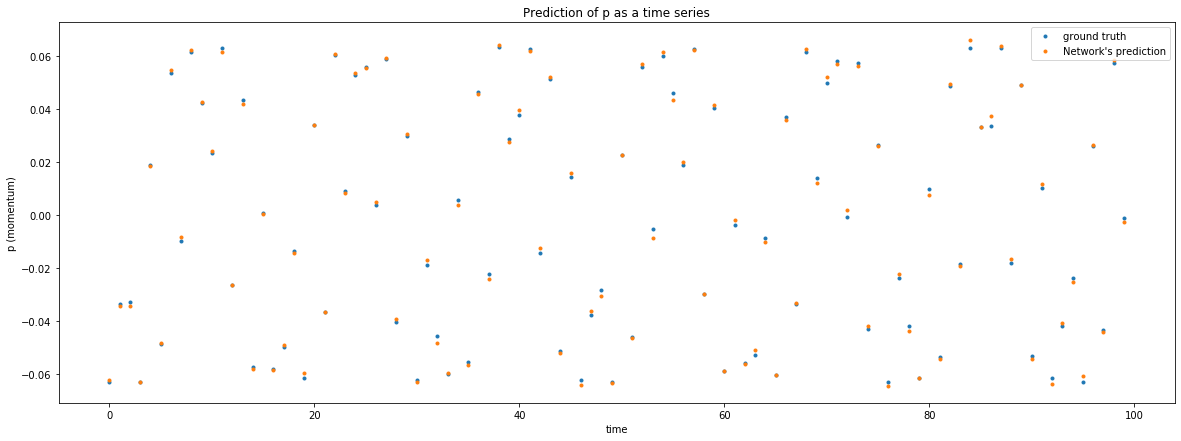

The test MSE for the 1-th dimension is 0.00045269169881905137
The test MSE for the 2-th dimension is 1.8553776170812845e-06
The 84 NRMSE for the 1-th dimension is 2.6029669009430503
The 84 NRMSE for the 2-th dimension is 1.4568104762240968

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 5.131773199368038e-06
The training MSE for the 2-th dimension is 2.5464641772484007e-07


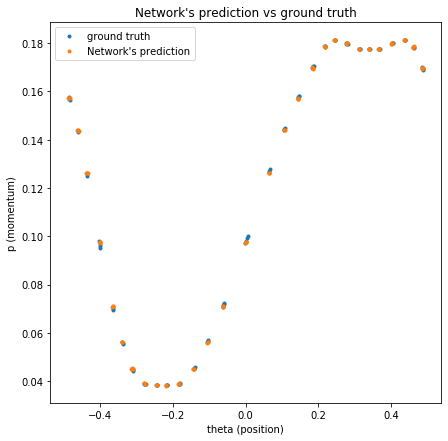

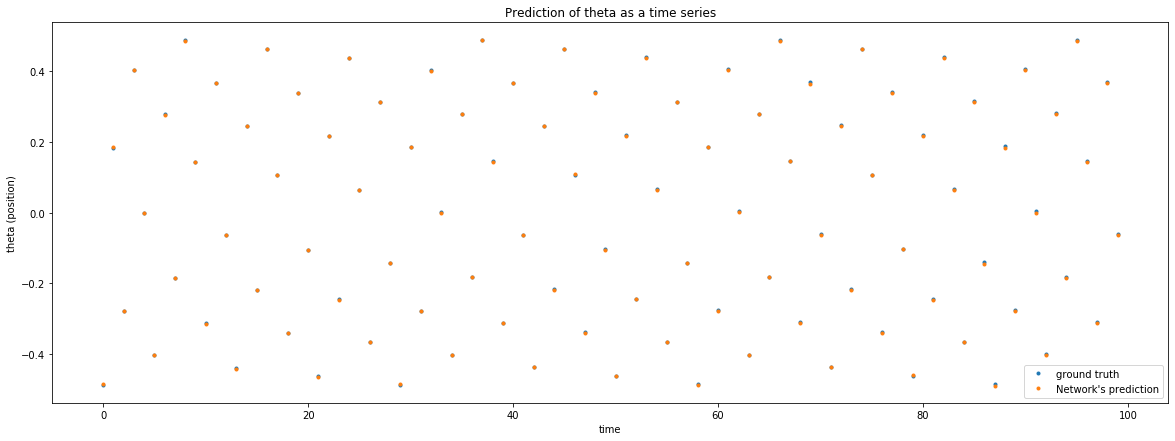

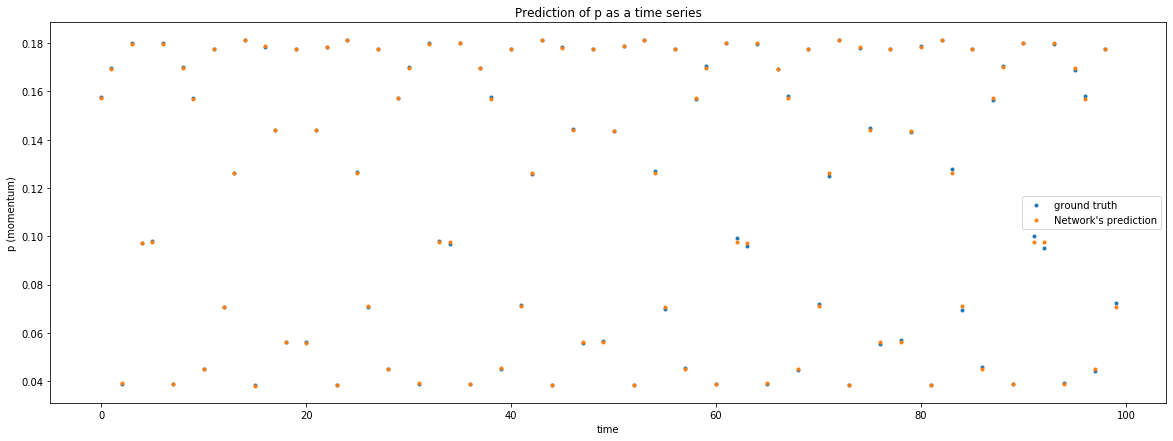

The test MSE for the 1-th dimension is 3.611853080492796e-06
The test MSE for the 2-th dimension is 4.0817444053626465e-07
The 84 NRMSE for the 1-th dimension is 0.3773349468735035
The 84 NRMSE for the 2-th dimension is 0.6095337310473808

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.01257806484934707
The training MSE for the 2-th dimension is 0.00783674526592082


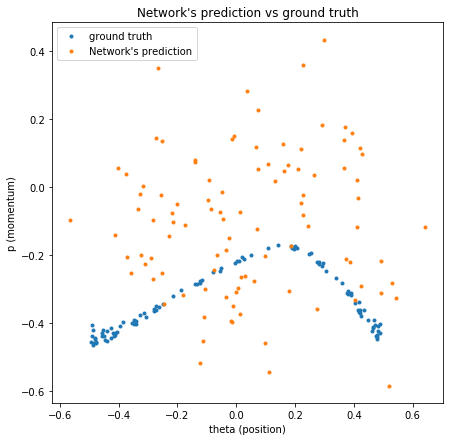

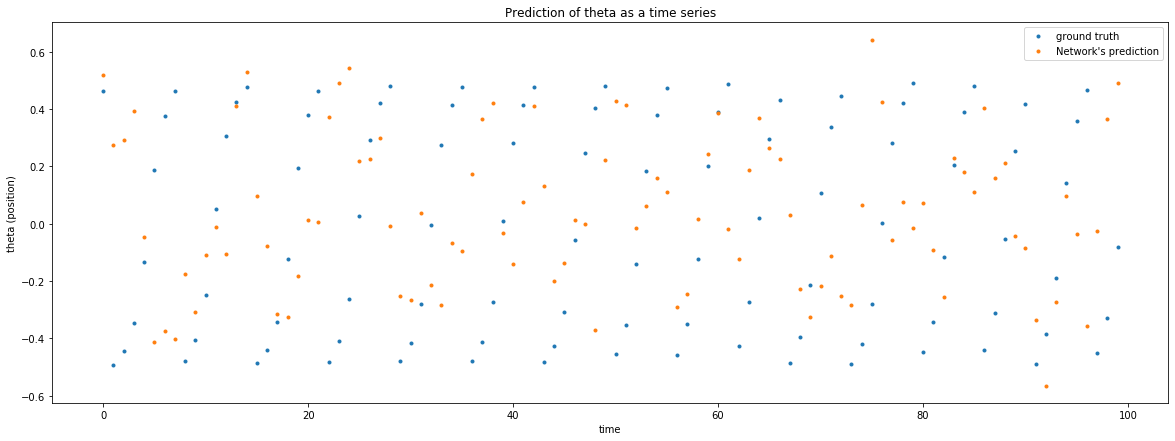

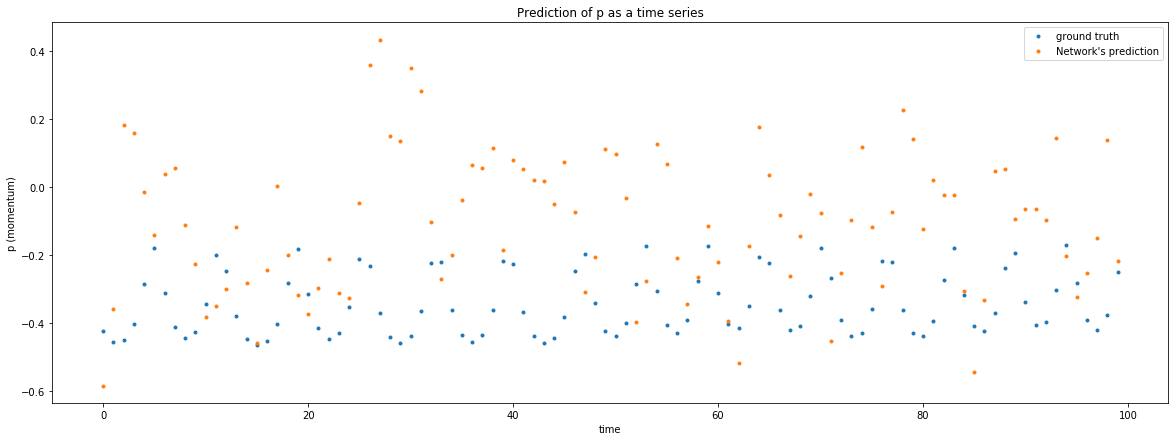

The test MSE for the 1-th dimension is 0.20297206370723253
The test MSE for the 2-th dimension is 0.11029213754462205
The 84 NRMSE for the 1-th dimension is 53.2678157106577
The 84 NRMSE for the 2-th dimension is 48.83919073234938


In [37]:
#K=0.9
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.9, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Notice that, for $K=0.9$, there are some dynamics that the network has not been capable of learning, like the ones regarding the initial conditions of $(2\pi/7,2\pi/8)$ or (0,0.9). 

# 2.5 Chaotic behavior <a name="Kchaos" ></a>

# K=1.2

In [52]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Initial condition ic=[0, 0]

The training MSE for the 1-th dimension is 1.232595164407831e-32
The training MSE for the 2-th dimension is 1.232595164407831e-32


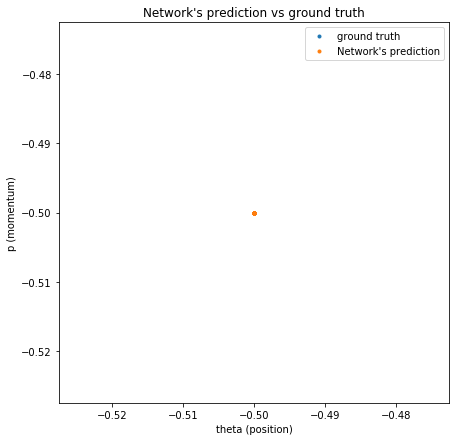

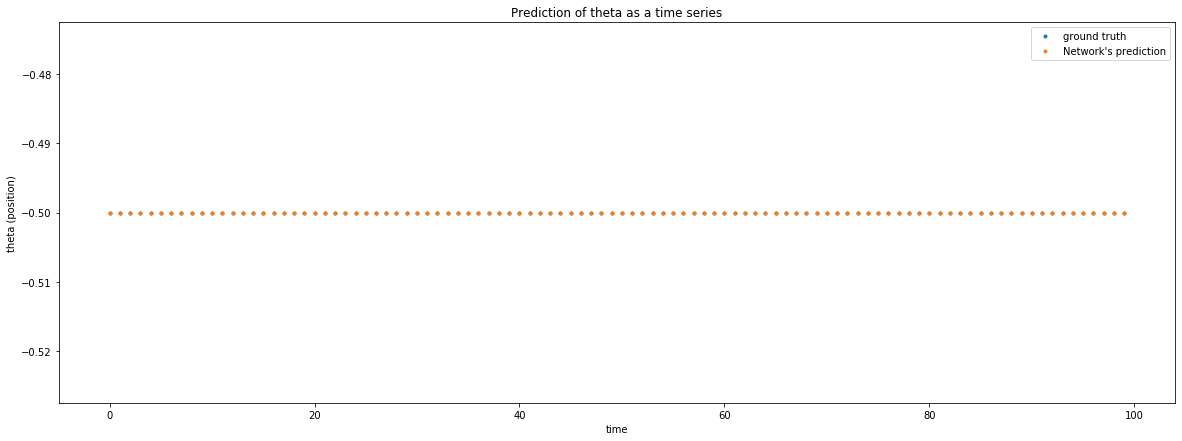

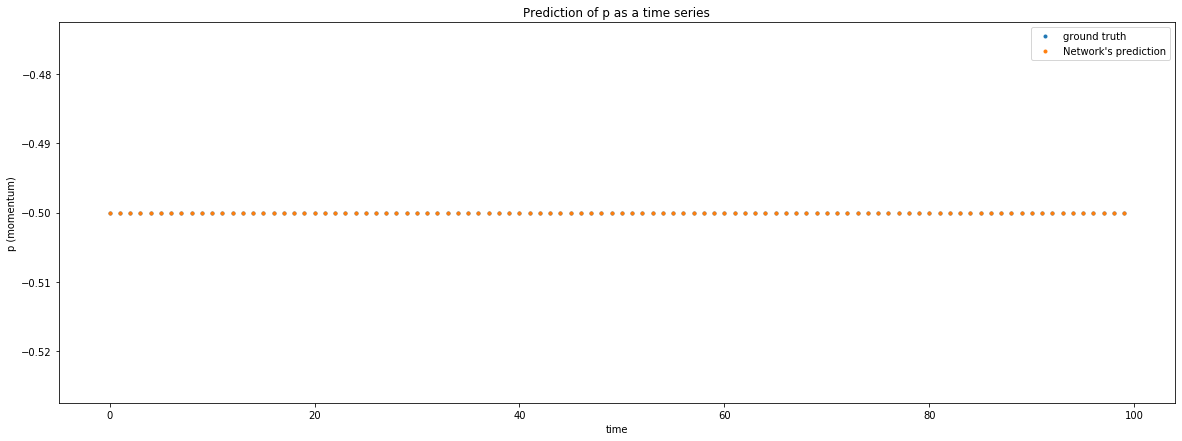

The test MSE for the 1-th dimension is 2.7733391199176196e-32
The test MSE for the 2-th dimension is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE for the 1-th dimension is inf
The 84 NRMSE for the 2-th dimension is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE for the 1-th dimension is 0.024328336977686625
The training MSE for the 2-th dimension is 0.009802285188311374


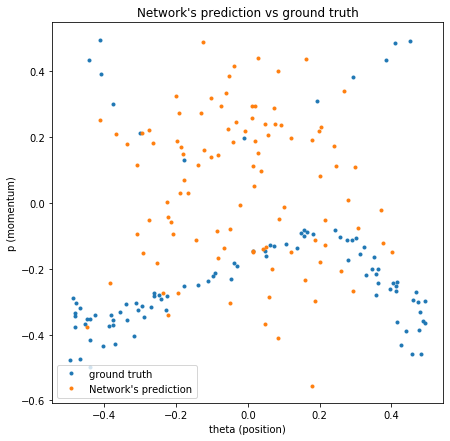

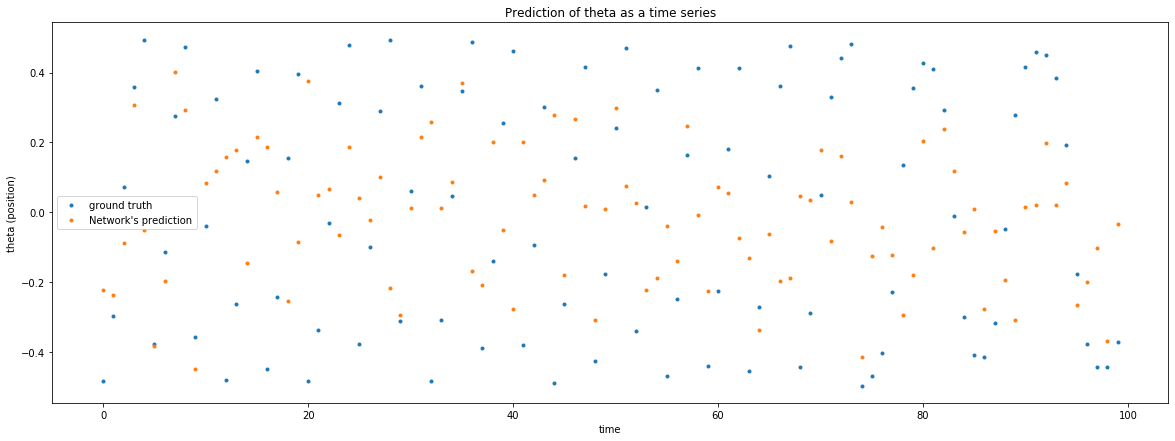

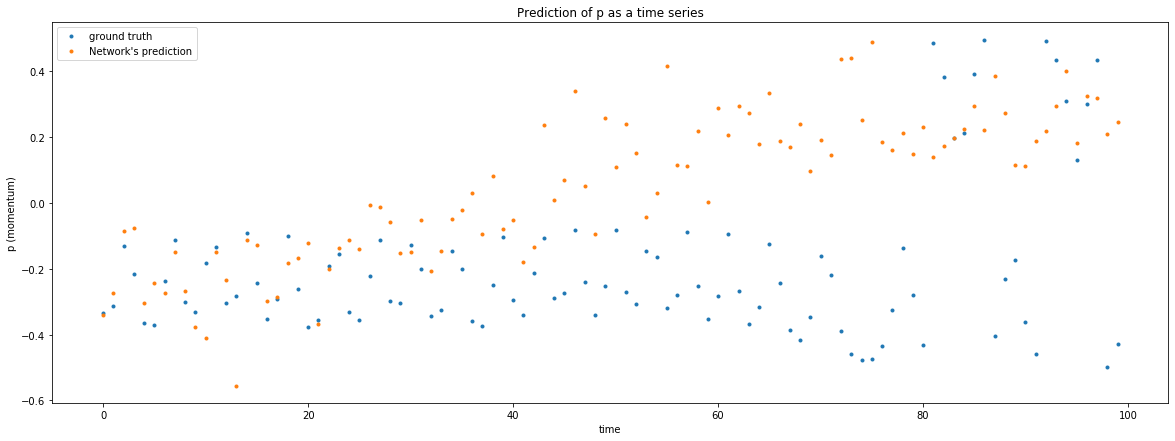

The test MSE for the 1-th dimension is 0.12789775010241783
The test MSE for the 2-th dimension is 0.13814565306827065
The 84 NRMSE for the 1-th dimension is 57.060588726262885
The 84 NRMSE for the 2-th dimension is 56.57176334243303

Initial condition ic=[0, 0.9]

The training MSE for the 1-th dimension is 0.024672301370892675
The training MSE for the 2-th dimension is 0.008624074021638896


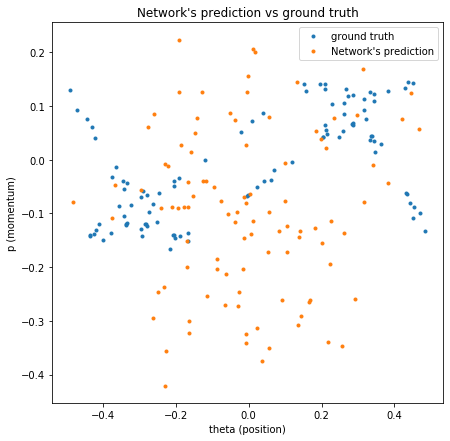

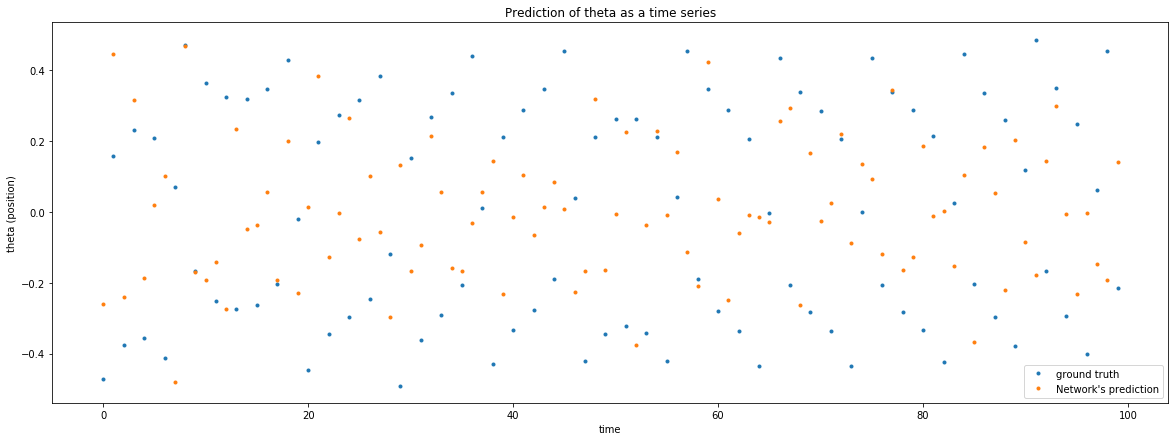

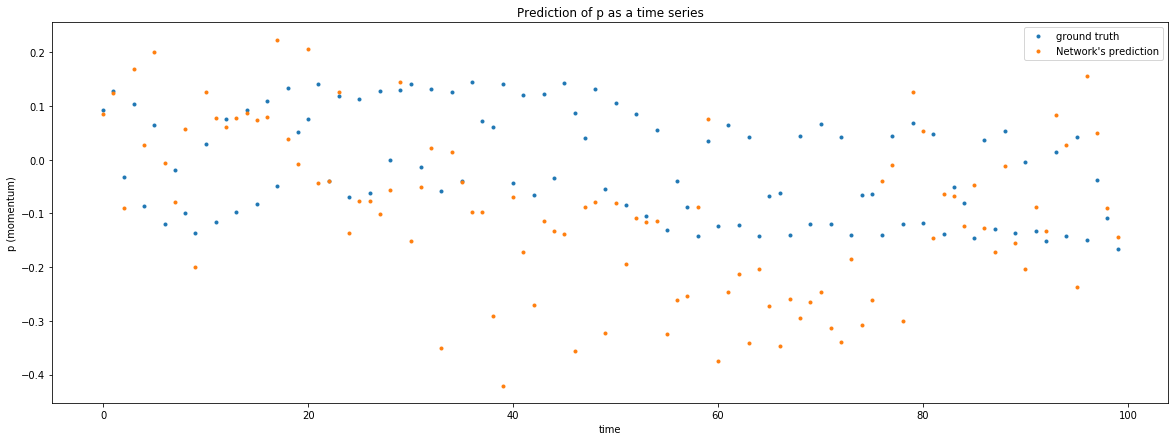

The test MSE for the 1-th dimension is 0.12292470084862045
The test MSE for the 2-th dimension is 0.03370843298954234
The 84 NRMSE for the 1-th dimension is 55.91561536477714
The 84 NRMSE for the 2-th dimension is 54.6232510777002

Initial condition ic=[0.9, 0]

The training MSE for the 1-th dimension is 3.4574966076120724e-06
The training MSE for the 2-th dimension is 0.002754831320064456


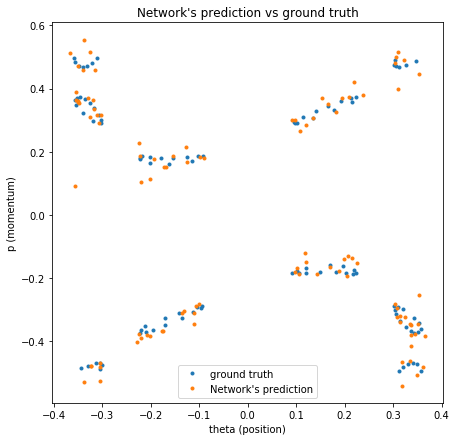

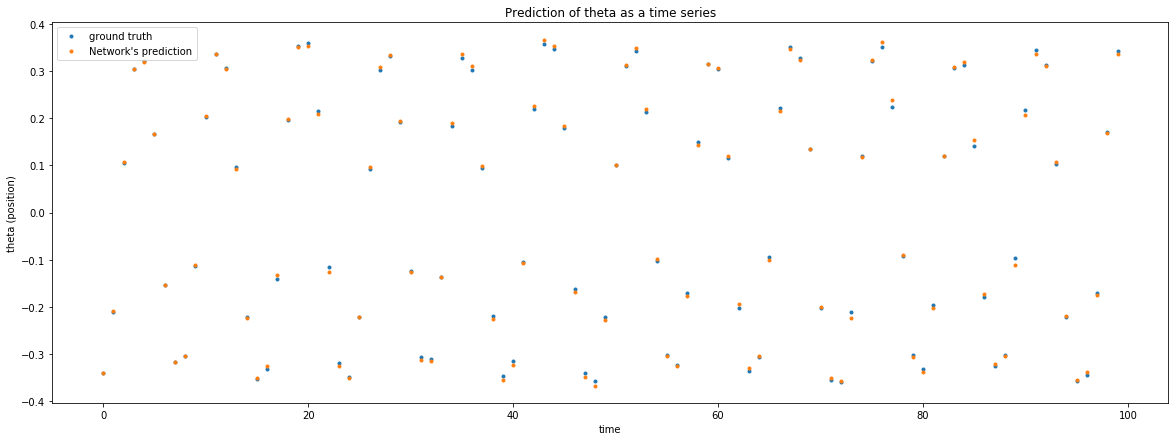

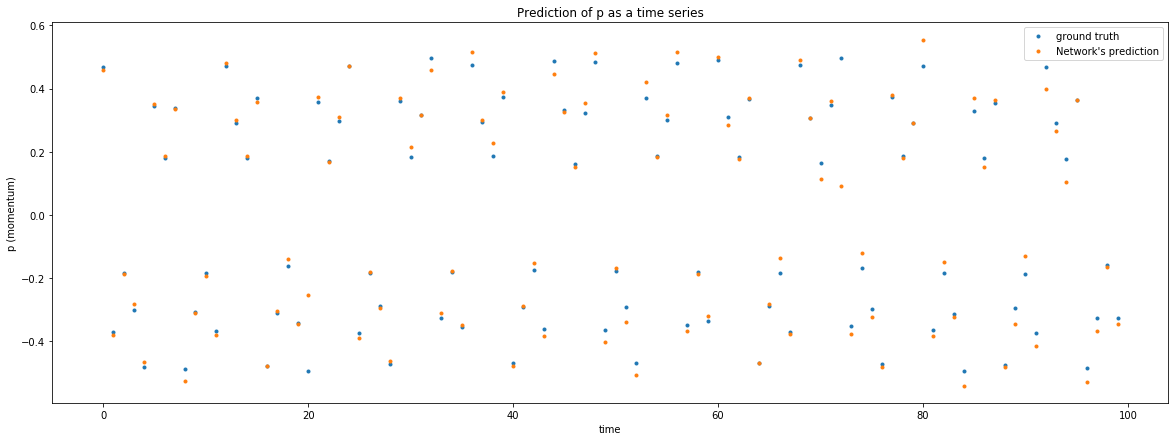

The test MSE for the 1-th dimension is 3.368085721394297e-05
The test MSE for the 2-th dimension is 0.002926900831901081
The 84 NRMSE for the 1-th dimension is 1.0326499422122002
The 84 NRMSE for the 2-th dimension is 3.8374244658134917

Initial condition ic=[0.5, 3]

The training MSE for the 1-th dimension is 0.0027939674099665395
The training MSE for the 2-th dimension is 1.0065348683177541e-06


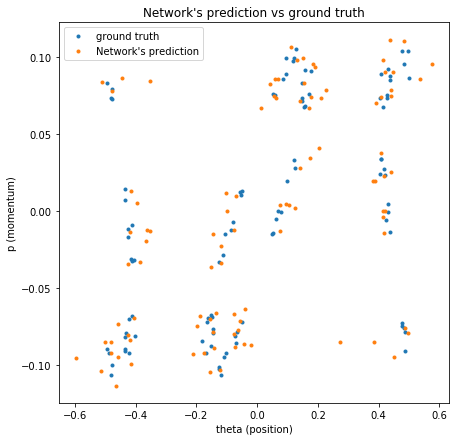

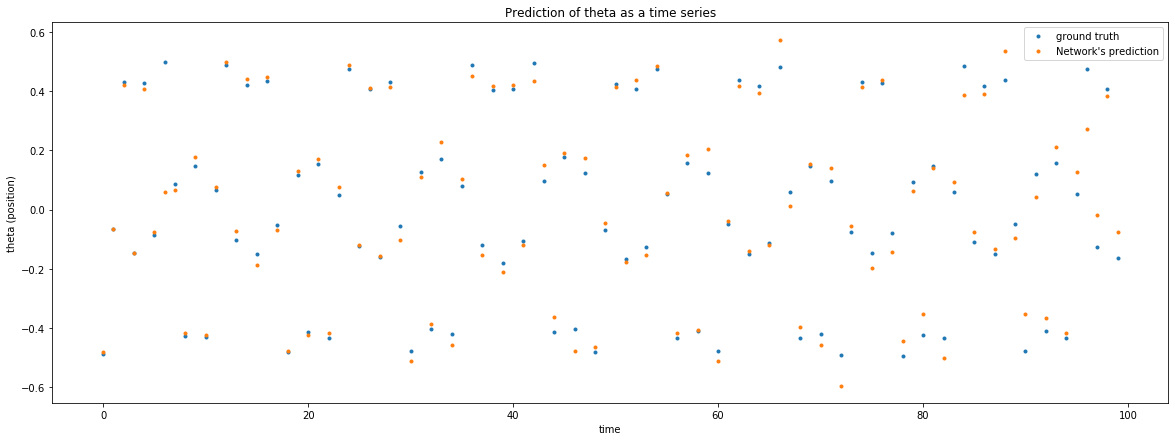

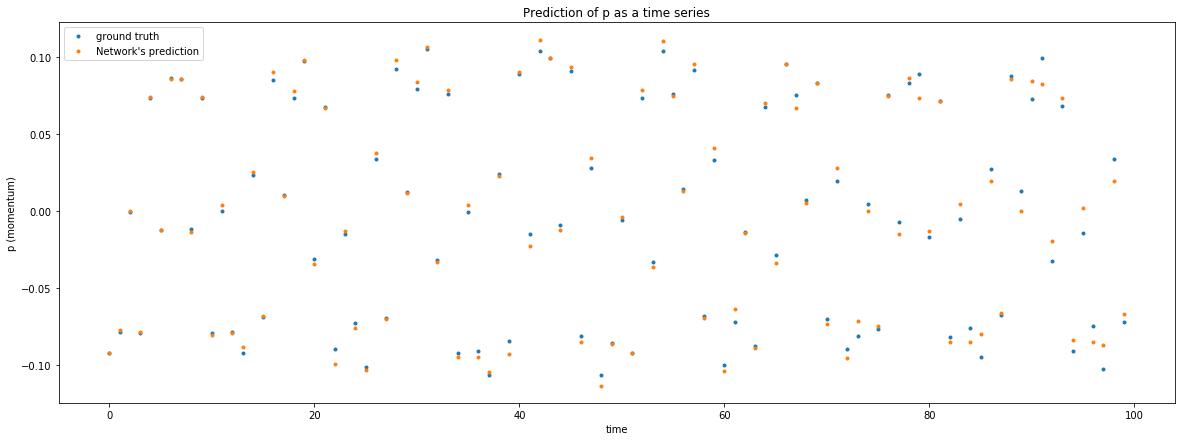

The test MSE for the 1-th dimension is 0.004121507315970373
The test MSE for the 2-th dimension is 3.7681813444368376e-05
The 84 NRMSE for the 1-th dimension is 5.667214655285277
The 84 NRMSE for the 2-th dimension is 2.8871704574558588

Initial condition ic=[1, 3.5]

The training MSE for the 1-th dimension is 4.290763120169354e-06
The training MSE for the 2-th dimension is 2.828225807856056e-06


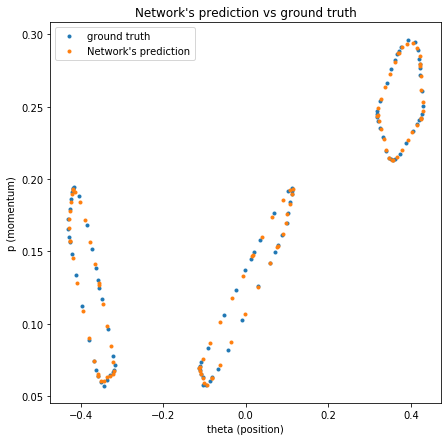

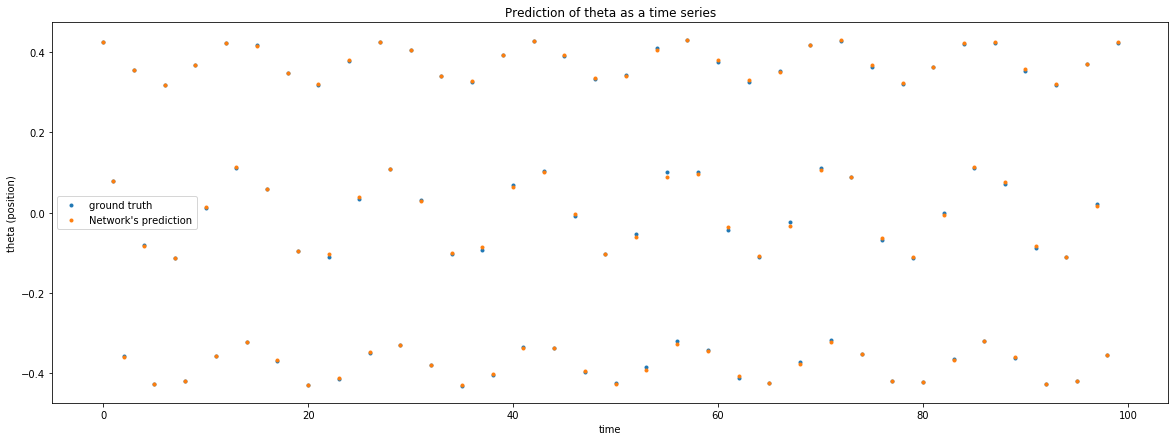

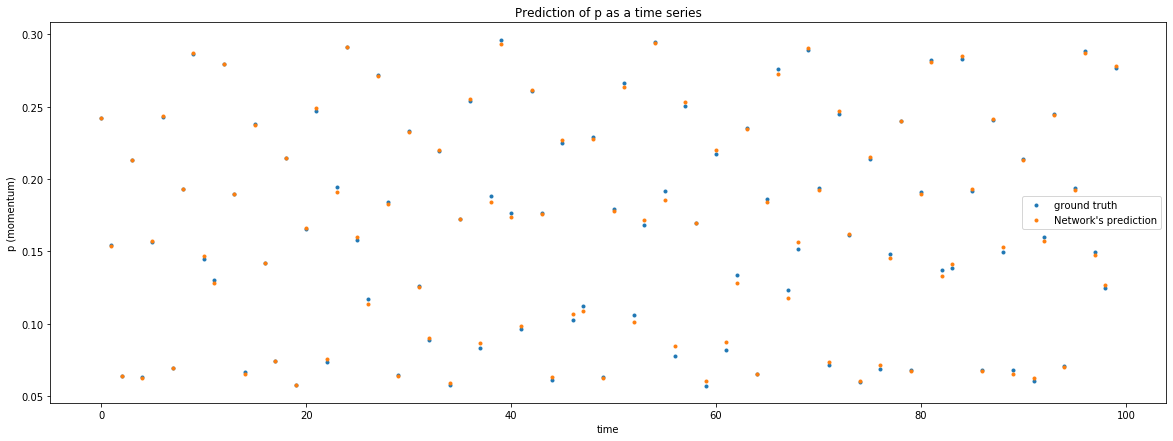

The test MSE for the 1-th dimension is 1.0623181465291676e-05
The test MSE for the 2-th dimension is 5.417543638805193e-06
The 84 NRMSE for the 1-th dimension is 1.269698882870698
The 84 NRMSE for the 2-th dimension is 4.440540782132073

Initial condition ic=[1, 1.2]

The training MSE for the 1-th dimension is 0.025289829030039256
The training MSE for the 2-th dimension is 0.013606234541624237


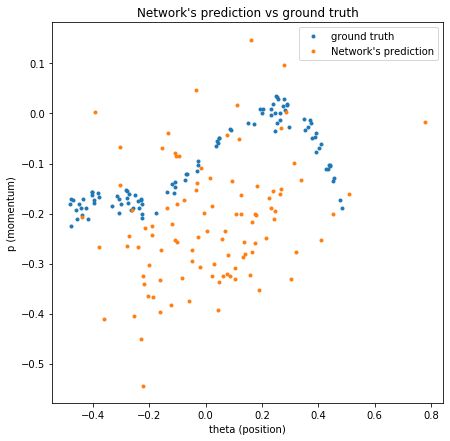

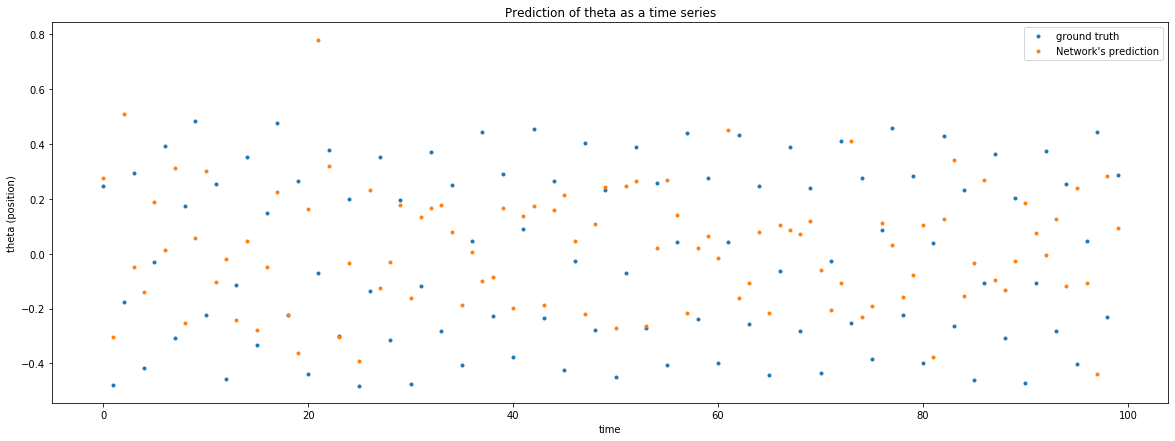

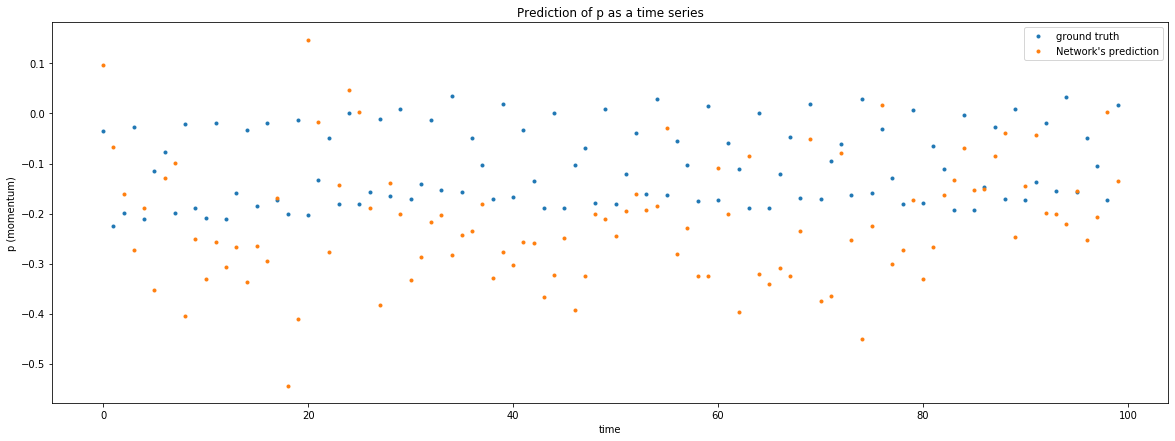

The test MSE for the 1-th dimension is 0.1412682510547339
The test MSE for the 2-th dimension is 0.03517538339849122
The 84 NRMSE for the 1-th dimension is 52.76542176878215
The 84 NRMSE for the 2-th dimension is 65.06130589243901


In [42]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=1.2, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

In this case, we took $K=1.2$, which entails a chaotic behavior. However, notice that the network has been able of properly predicting some dynamics whereas it failed in some other. In addition, for the former type of trajectories, the $\text{NRMSE}_{84}$ is not that large.

## Fix the initial condition and increase the value of K

Let us now modify the value of $K$ while the initial condition remains fixed at (0.9,0).

In [54]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [55]:
Network.non_null_matrices = ["W_back", "W_in"]


Kick value K=1.2

The training MSE for the 1-th dimension is 3.131915468390186e-06
The training MSE for the 2-th dimension is 0.002279752818334106


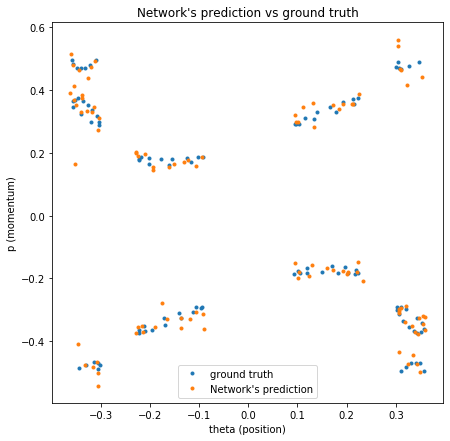

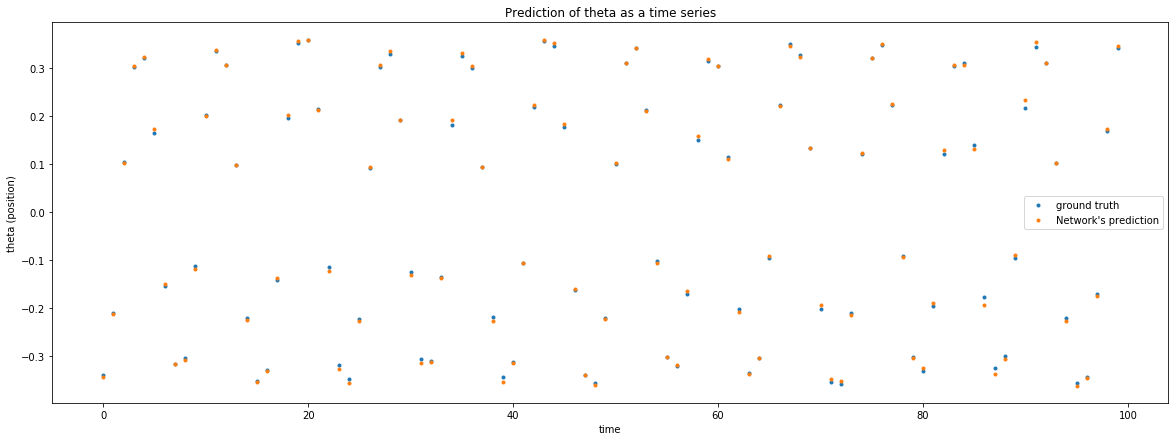

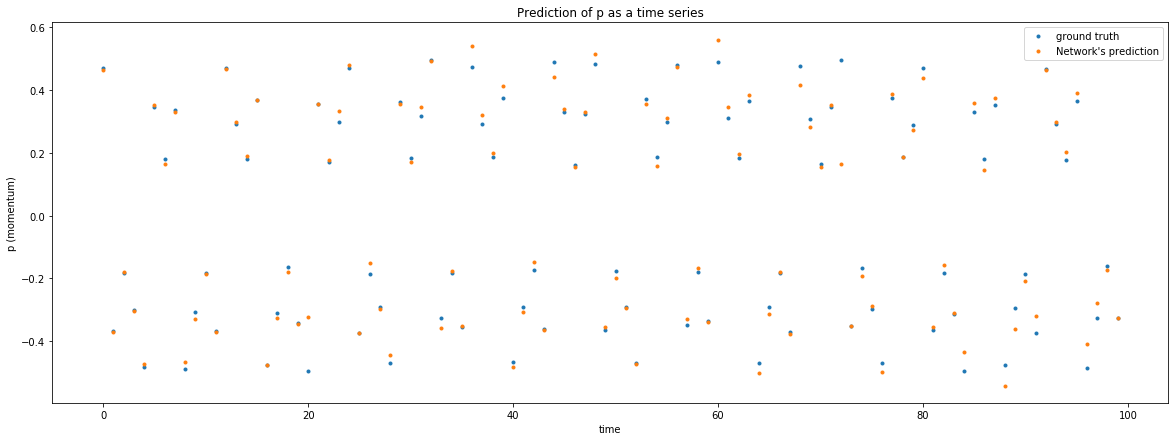

The test MSE for the 1-th dimension is 2.8364926661575593e-05
The test MSE for the 2-th dimension is 0.0020457198083210265
The 84 NRMSE for the 1-th dimension is 1.1027493173970822
The 84 NRMSE for the 2-th dimension is 3.662650839965176

Kick value K=1.5

The training MSE for the 1-th dimension is 0.029007901536996717
The training MSE for the 2-th dimension is 0.014094387597289423


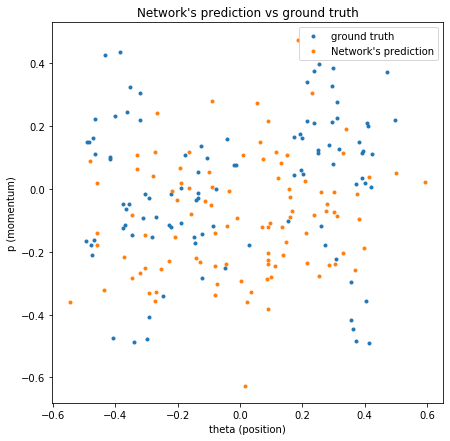

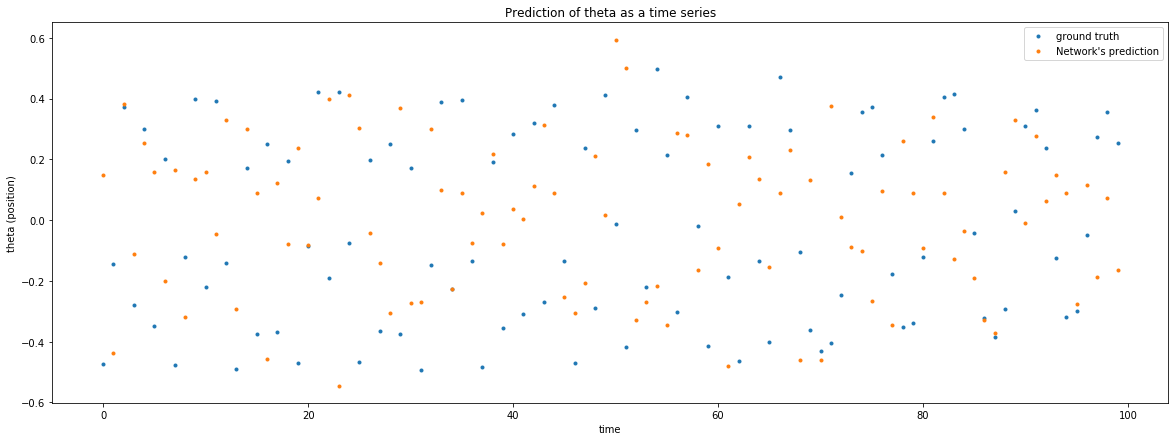

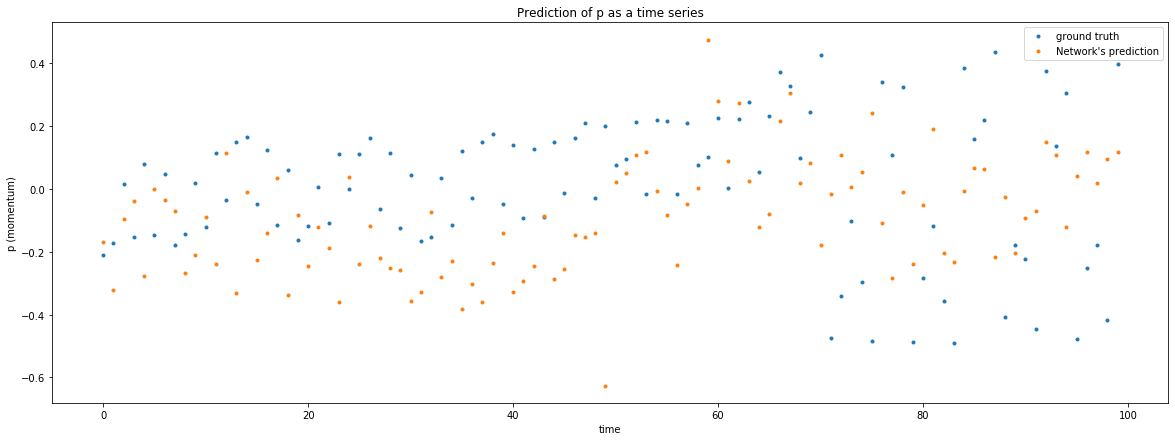

The test MSE for the 1-th dimension is 0.17021938605336798
The test MSE for the 2-th dimension is 0.09110780468521748
The 84 NRMSE for the 1-th dimension is 57.343713171175054
The 84 NRMSE for the 2-th dimension is 64.57193344594856

Kick value K=2

The training MSE for the 1-th dimension is 0.04401758070973852
The training MSE for the 2-th dimension is 0.024951047267484365


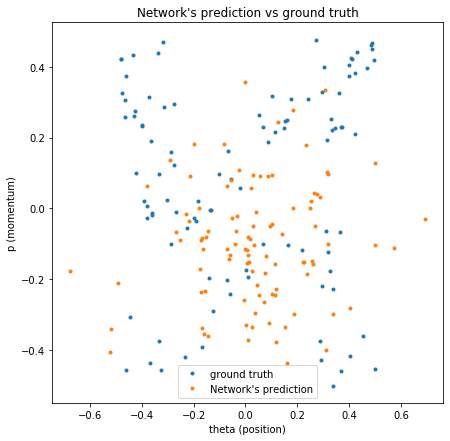

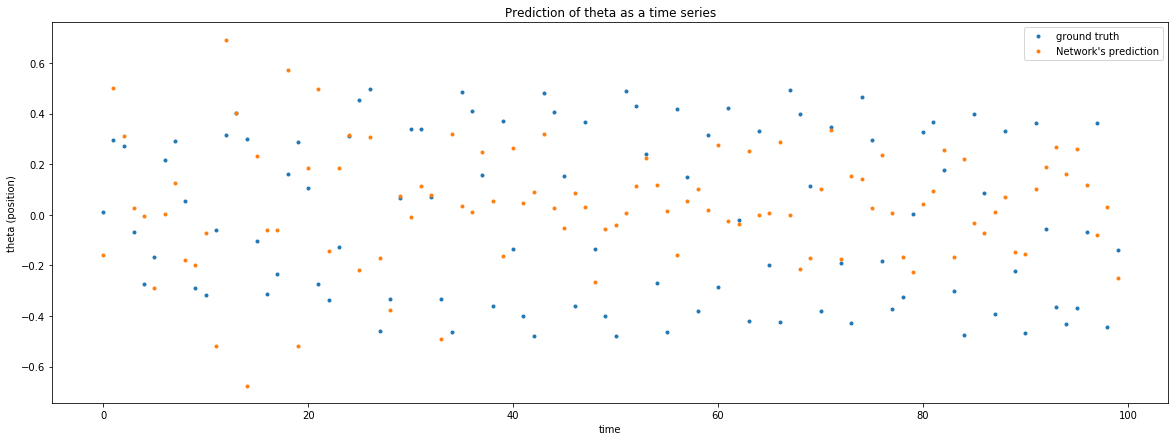

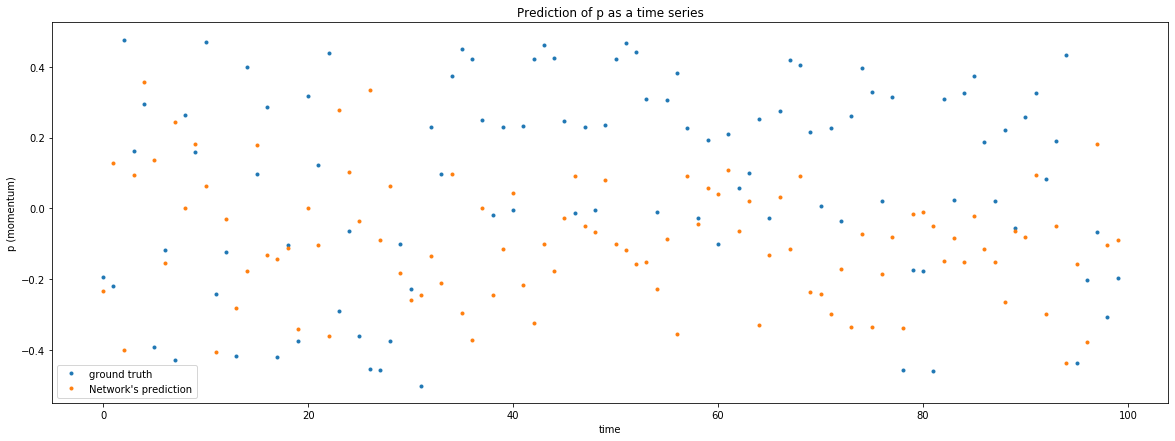

The test MSE for the 1-th dimension is 0.14967203125898818
The test MSE for the 2-th dimension is 0.15215695110443817
The 84 NRMSE for the 1-th dimension is 47.88372411433907
The 84 NRMSE for the 2-th dimension is 54.1480912477509

Kick value K=3

The training MSE for the 1-th dimension is 0.04263534308317985
The training MSE for the 2-th dimension is 0.03971275411052888


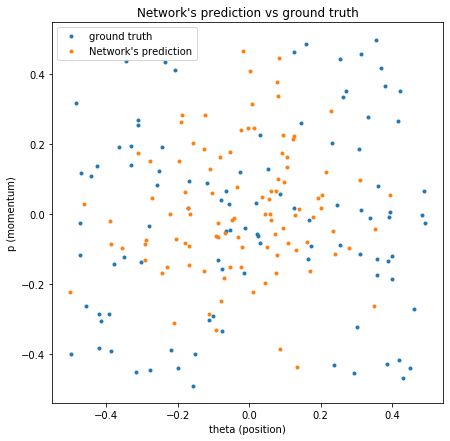

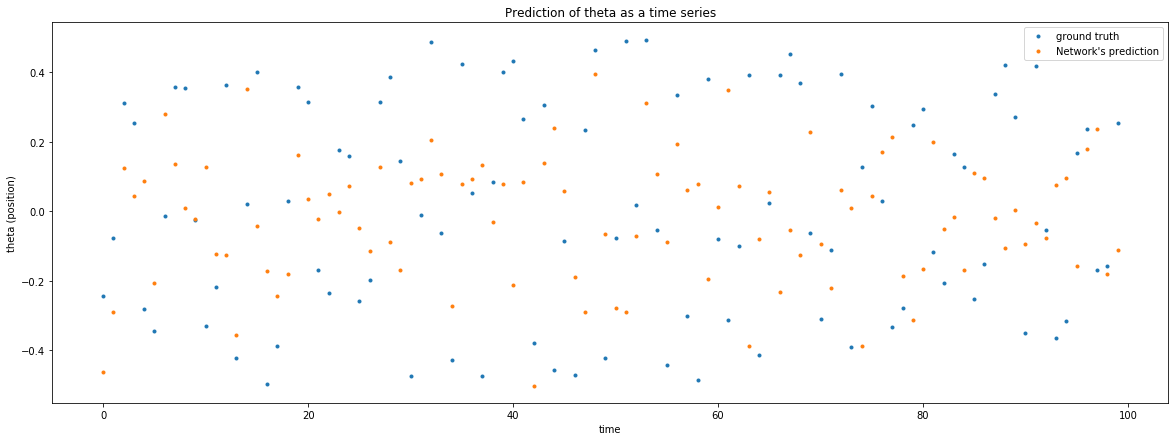

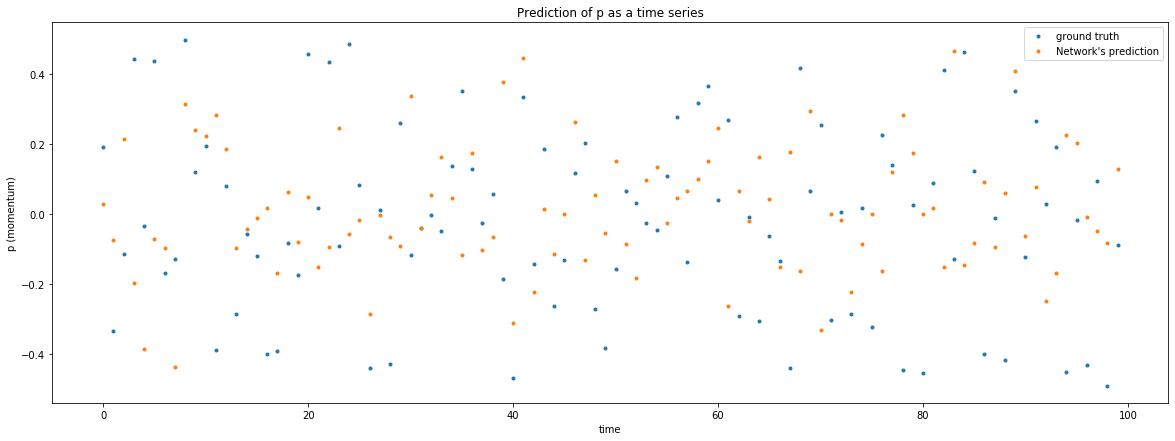

The test MSE for the 1-th dimension is 0.11974920592735556
The test MSE for the 2-th dimension is 0.10394000026710686
The 84 NRMSE for the 1-th dimension is 58.158760311567924
The 84 NRMSE for the 2-th dimension is 52.39615264260074

Kick value K=5

The training MSE for the 1-th dimension is 0.04819364678757778
The training MSE for the 2-th dimension is 0.04843844529552134


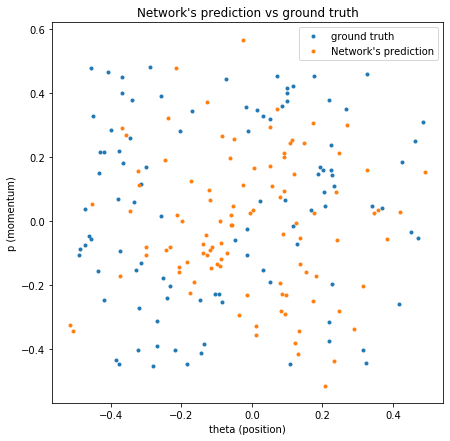

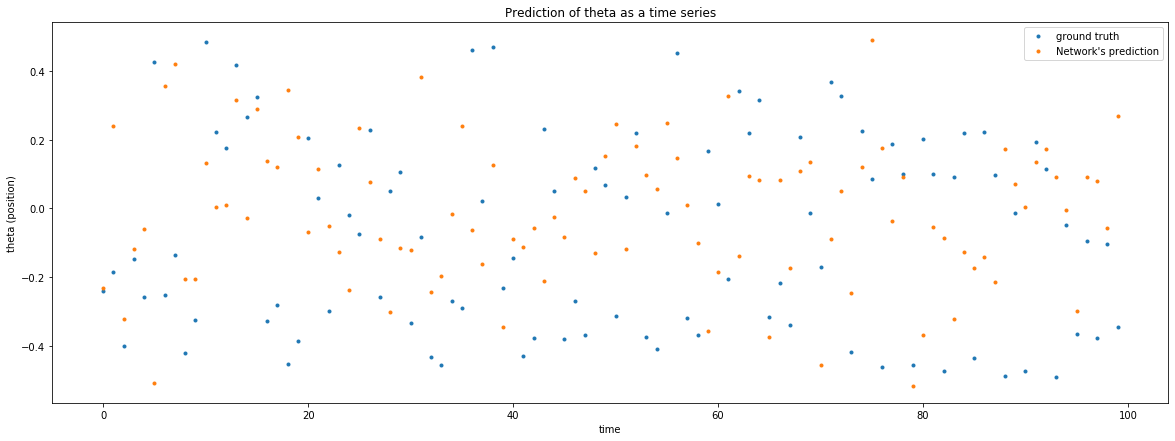

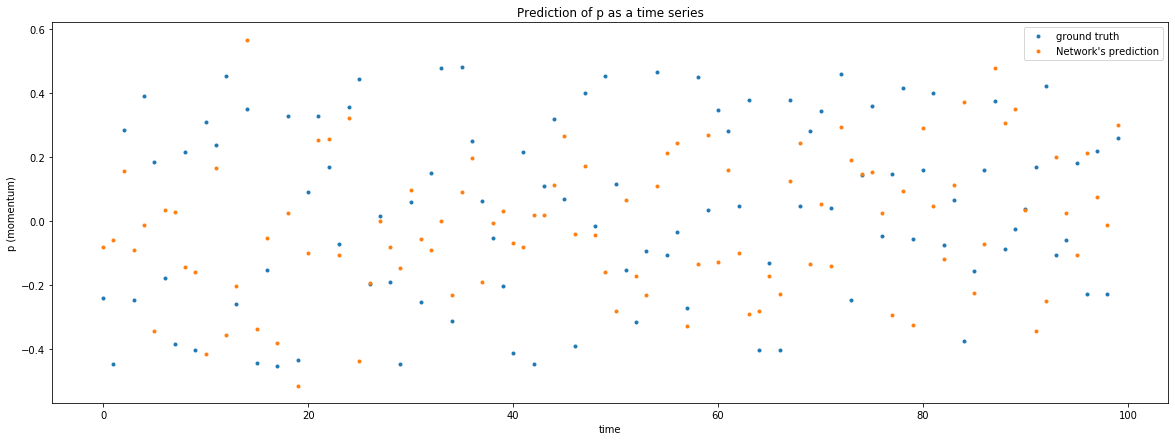

The test MSE for the 1-th dimension is 0.12037325334747084
The test MSE for the 2-th dimension is 0.09937398637273073
The 84 NRMSE for the 1-th dimension is 53.2619185263153
The 84 NRMSE for the 2-th dimension is 50.39272911685036

Kick value K=7

The training MSE for the 1-th dimension is 0.05108156430668484
The training MSE for the 2-th dimension is 0.049102795771074896


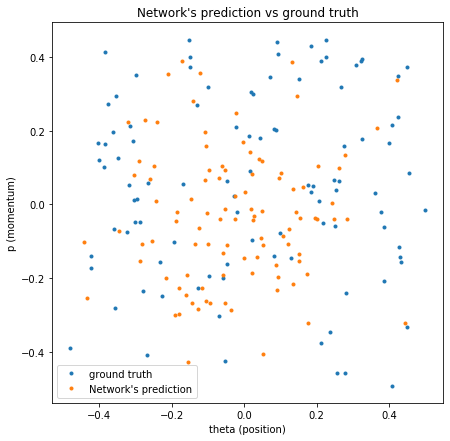

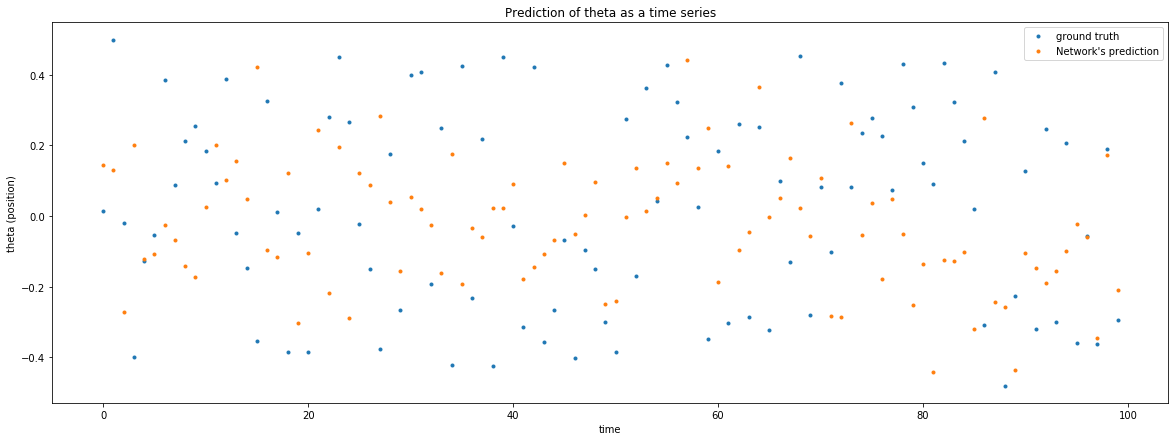

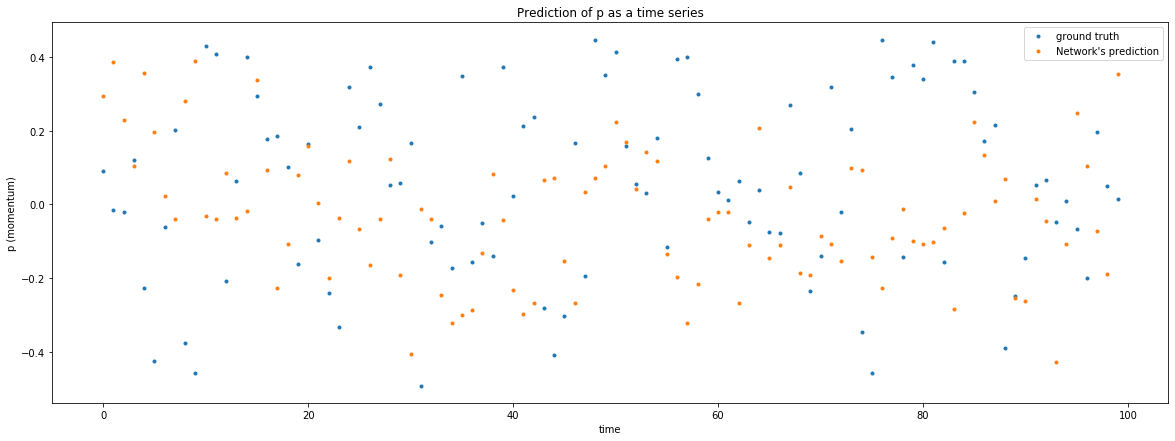

The test MSE for the 1-th dimension is 0.11735676934963157
The test MSE for the 2-th dimension is 0.1142510409310933
The 84 NRMSE for the 1-th dimension is 48.52579535568766
The 84 NRMSE for the 2-th dimension is 41.86886791737926


In [58]:
Network.train_test_k(ic=[0.9,0], k_list=[1.2, 1.5, 2, 3, 5, 7], t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Notice that, for K=1.2, the network properly predicted the dynamics with a quite small value of $\text{NRMSE}_{84}$ the metrics.

# 3. Other trials with poor performance or too much computational cost <a name="FailedTrials" ></a>

As already mentioned, the network parameters and the training formulas where chosen by us. OF COURSE, SUCH CHOICES WERE DONE ACCORDING TO PROCEDURES SEEN IN OTHER PAPERS RELATED WITH THE RESERVOIR COMPUTING TOPIC. Before getting to the proper strategy implemented in [Section 2](#TrainingNetwork), we had to carry out some trial and error. In this section, we show some of the approaches that did not produce the desired output or produced an output that was not as good as the one displayed in [Section 2](#TrainingNetwork) but they are still worthy to be shown since they belong to the set of typical tunning strategies. In addition, we discuss the role played by the number of nodes of the reservoir.

The following experiments are going to be performed for the initial condition $(\theta_0,p_0)= \left(0.5, 3\right)$ or $(\theta_0,p_0)= \left(1, 3.5\right)$ and always regarding $K=0.25$. Such initial conditions are taken in order to properly illustrate the role played by the different parameters.

## 3.1 Parameters of the reservoir <a name="Params" ></a>

Let us begin by checking the performance when the number of nodes and the spectral radius of the reservoir is changed. Recall that, in [Section 2](#TrainingNetwork), we took 3000 nodes and the largest eigenvalue of the adjacency matrix took value 1.35 (in module).

### 3.1.1 Spectral radius <a name="SpectralRadius" ></a>

**Let us begin by considering an spectral radius of 0.6.**

In [8]:
#rescale Network.W in order to get an SPECTRAL RADIUS EQUAL TO 0.6
alpha = 0.6/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)

The maximum eigenvalue (in module) is 0.5999999999999986



Kick value K=0.25

The training MSE for the 1-th dimension is 0.024632442255228853
The training MSE for the 2-th dimension is 1.526983012734552e-05


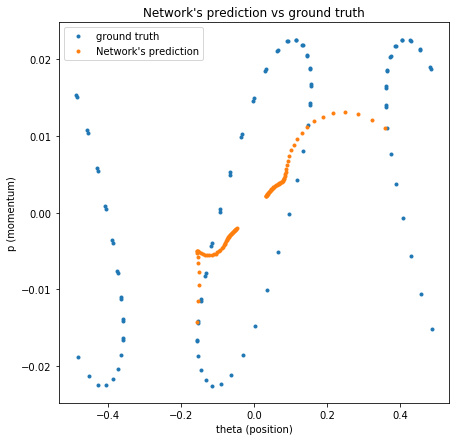

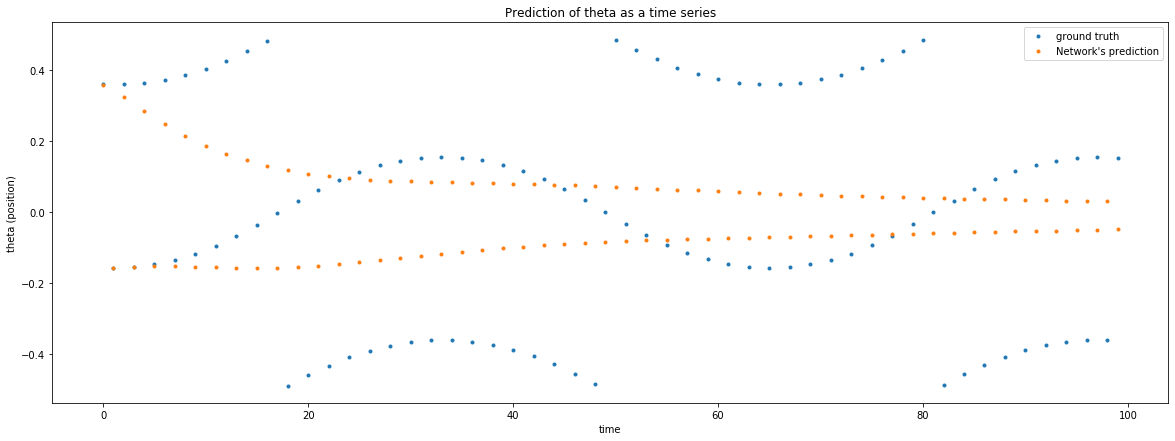

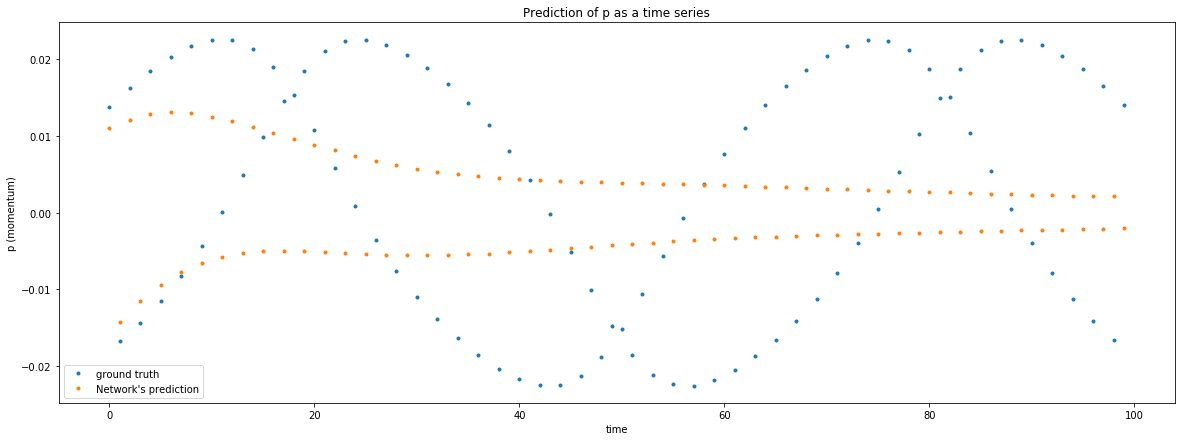

The test MSE for the 1-th dimension is 0.0934762922195777
The test MSE for the 2-th dimension is 0.0002536205970038191


In [10]:
#TRAINING AND TESTING
Network.train_test_k(ic=[0.5,3], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

**Let us now take it equal to 0.99.**

In [11]:
#rescale Network.W in order to get an SPECTRAL RADIUS EQUAL TO 0.99
alpha = 0.99/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)

The maximum eigenvalue (in module) is 0.9900000000000093



Kick value K=0.25

The training MSE for the 1-th dimension is 0.018058813078357792
The training MSE for the 2-th dimension is 1.8242916717605441e-06


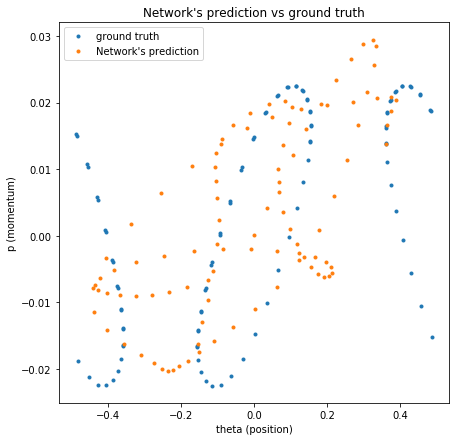

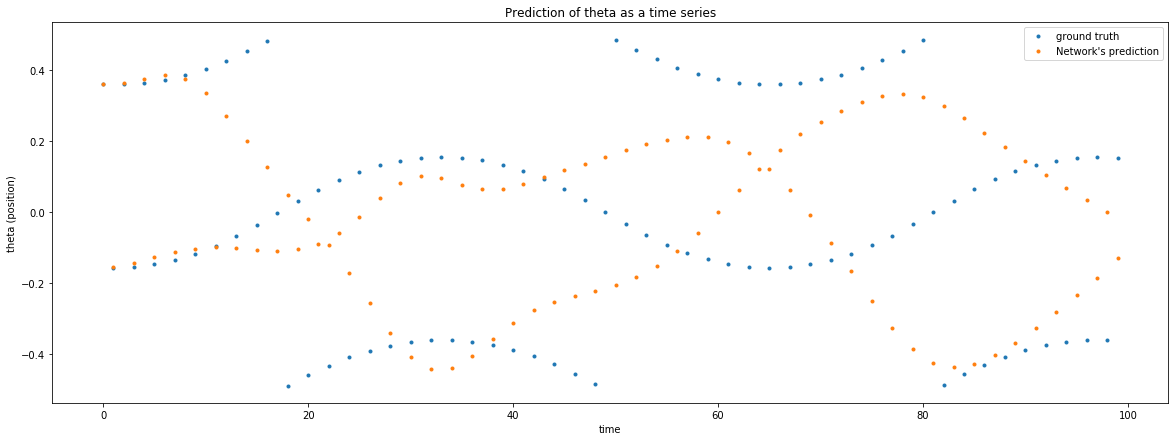

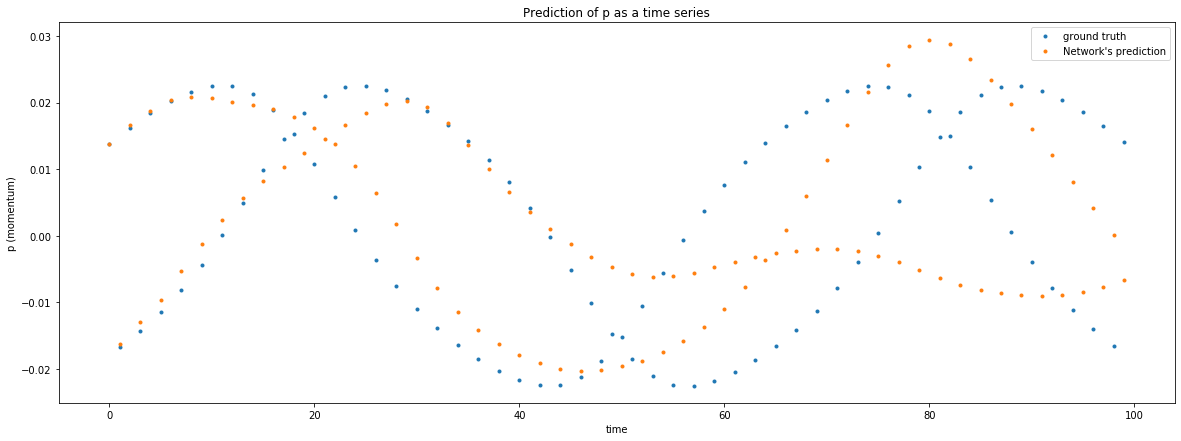

The test MSE for the 1-th dimension is 0.09132921884552823
The test MSE for the 2-th dimension is 0.0001632443735291801


In [12]:
#TRAINING AND TESTING
Network.train_test_k(ic=[0.5,3], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

**Take it now to be equal to 2.**

In [13]:
#rescale Network.W in order to get an SPECTRAL RADIUS EQUAL TO 2
alpha = 2/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)

The maximum eigenvalue (in module) is 1.9999999999999813



Kick value K=0.25

The training MSE for the 1-th dimension is 0.01248713265306246
The training MSE for the 2-th dimension is 2.4285854064046253e-05


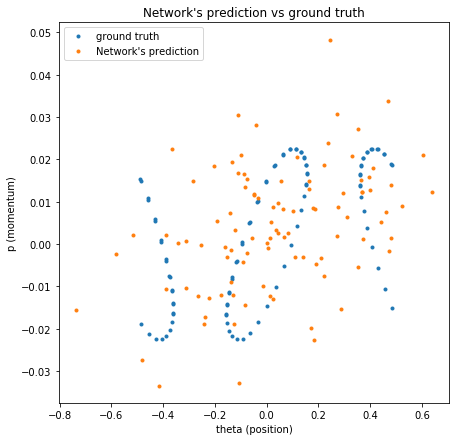

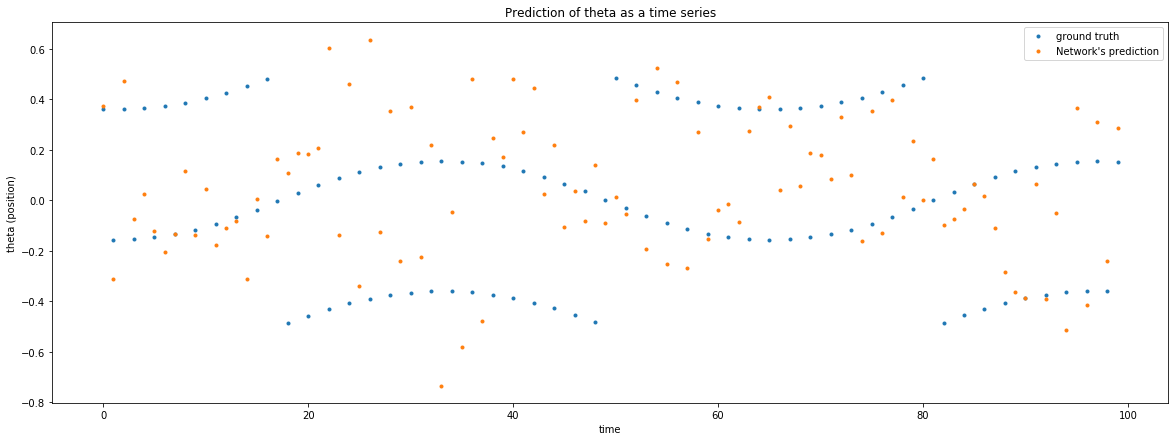

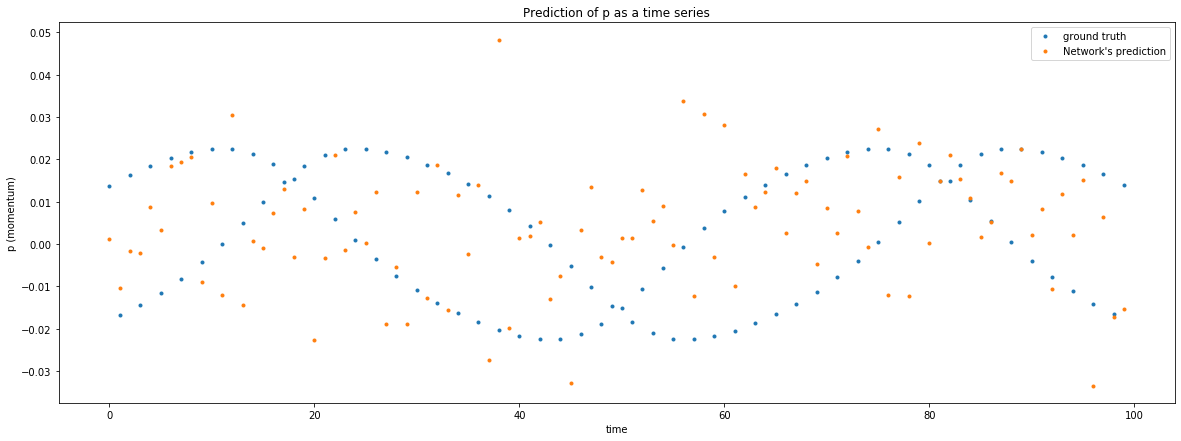

The test MSE for the 1-th dimension is 0.17698404890343988
The test MSE for the 2-th dimension is 0.0004238270382168197


In [14]:
#TRAINING AND TESTING
Network.train_test_k(ic=[0.5,3], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

**Finally, take it to be equal to 3.**

In [15]:
#rescale Network.W in order to get an SPECTRAL RADIUS EQUAL TO 3
alpha = 3/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)

The maximum eigenvalue (in module) is 2.9999999999999902



Kick value K=0.25

The training MSE for the 1-th dimension is 0.01732819826981341
The training MSE for the 2-th dimension is 4.444393397430206e-05


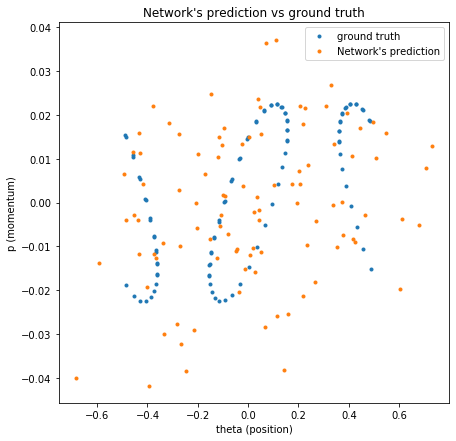

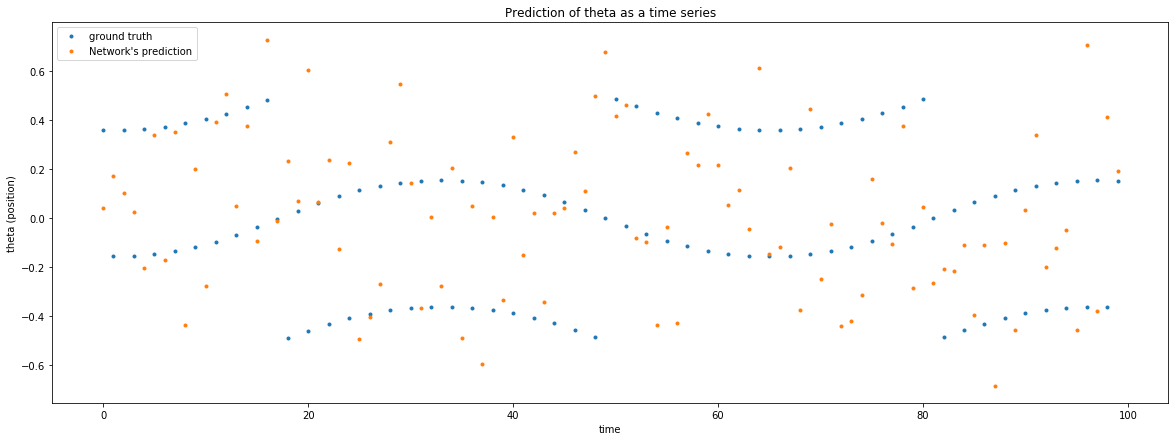

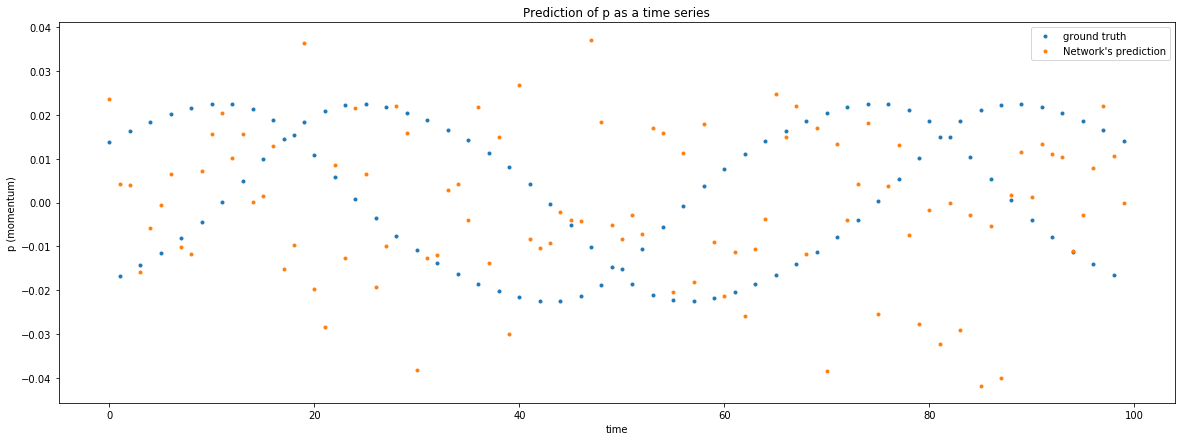

The test MSE for the 1-th dimension is 0.2309587570468999
The test MSE for the 2-th dimension is 0.0006221509231380321


In [16]:
#TRAINING AND TESTING
Network.train_test_k(ic=[0.5,3], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Notice that if the spectral radius is low, like 0.6 or 0.99, the network learns some continuous dynamics but not the desired one. On the other hand, if it is too big, like 2 or 3, then it appears that the network is not learning any particular dynamics but a quite random cloud of points.

### 3.1.2 Number of nodes <a name="NumNodes" ></a>

Notice that, if we want to change the number of nodes, then we need to run again the commands defining all the weight matrices, since their sizes will be different.

Recall that in [Section 2](#TrainingNetwork) we took $N=3000$ nodes.

**Take N=400**.

In [35]:
Network.N = 400 
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Kick value K=0.25

The training MSE for the 1-th dimension is 0.005762278152672383
The training MSE for the 2-th dimension is 1.8231469522524355e-06


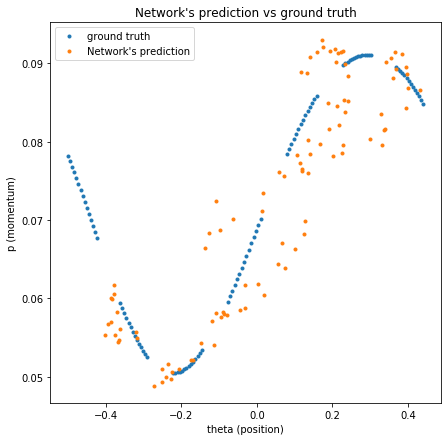

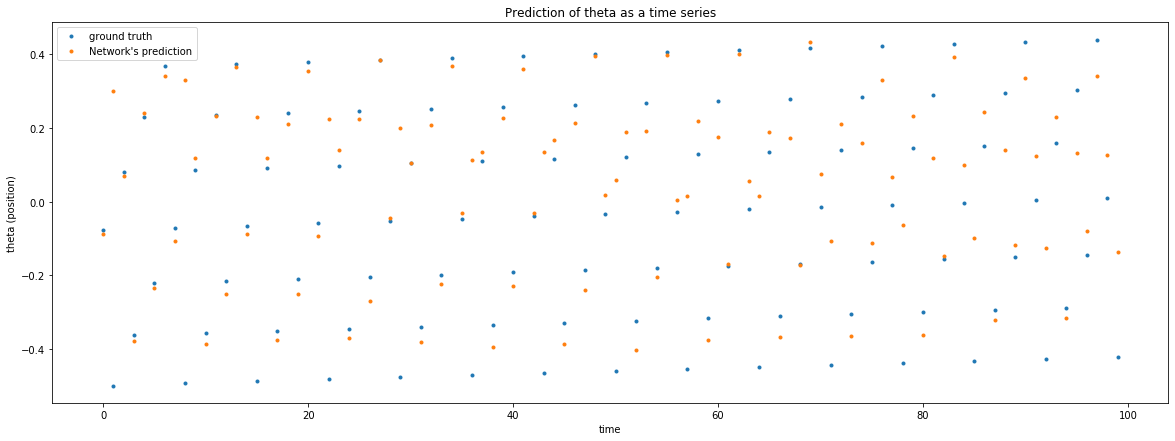

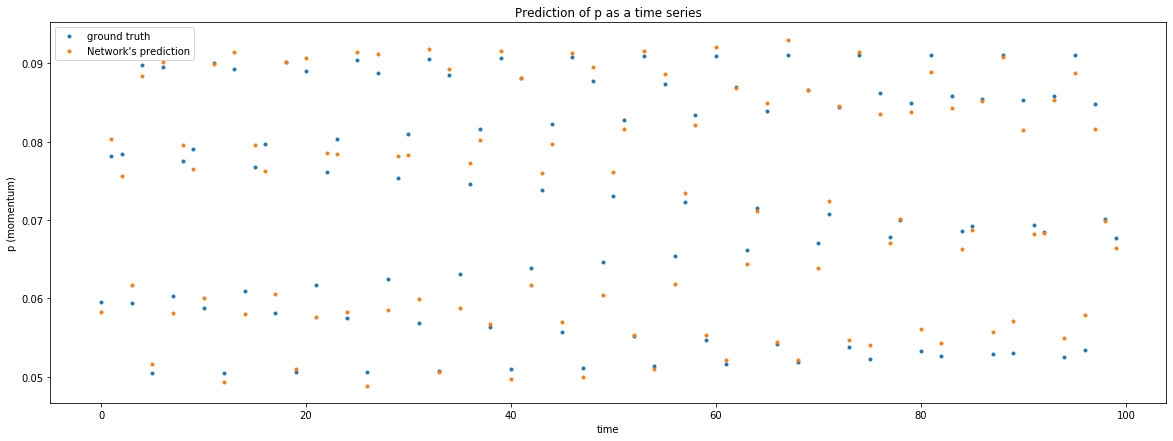

The test MSE for the 1-th dimension is 0.05079285489999879
The test MSE for the 2-th dimension is 4.038859022600573e-06


In [36]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Notice that the predictions are not as bad as one would expect. Notice that the predictions lie on a reasonable neighborhood of the ground truth. However, this result is not as accurate as when N=3000.

**Take N=1000**.

In [37]:
Network.N = 1000
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0024875693431175537
The training MSE for the 2-th dimension is 6.426186912273886e-07


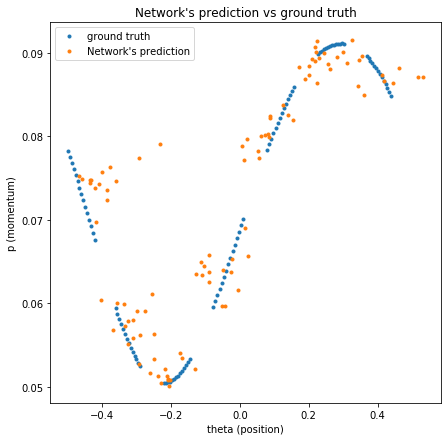

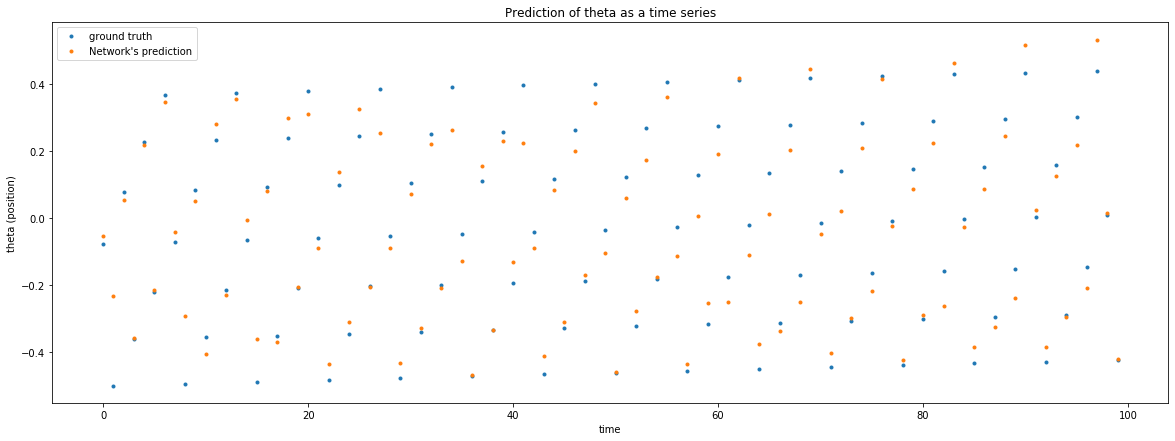

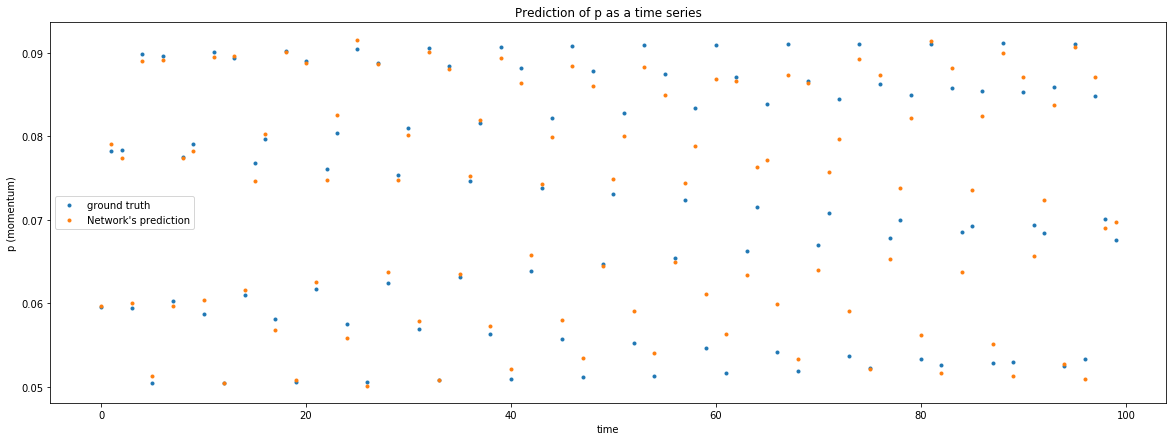

The test MSE for the 1-th dimension is 0.004558591968254051
The test MSE for the 2-th dimension is 5.905225290445113e-06


In [38]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

The general behavior is quite similar to the former case.

**Take N=2000**.

In [39]:
Network.N = 2000
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0009185428747275878
The training MSE for the 2-th dimension is 2.1401437433423882e-08


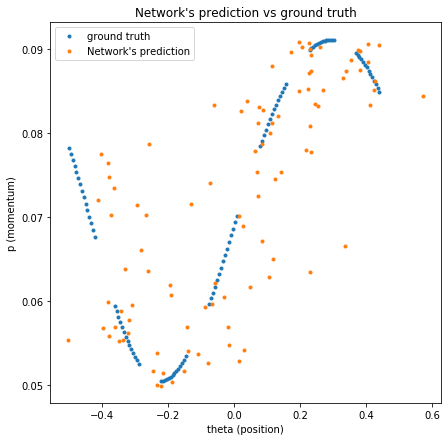

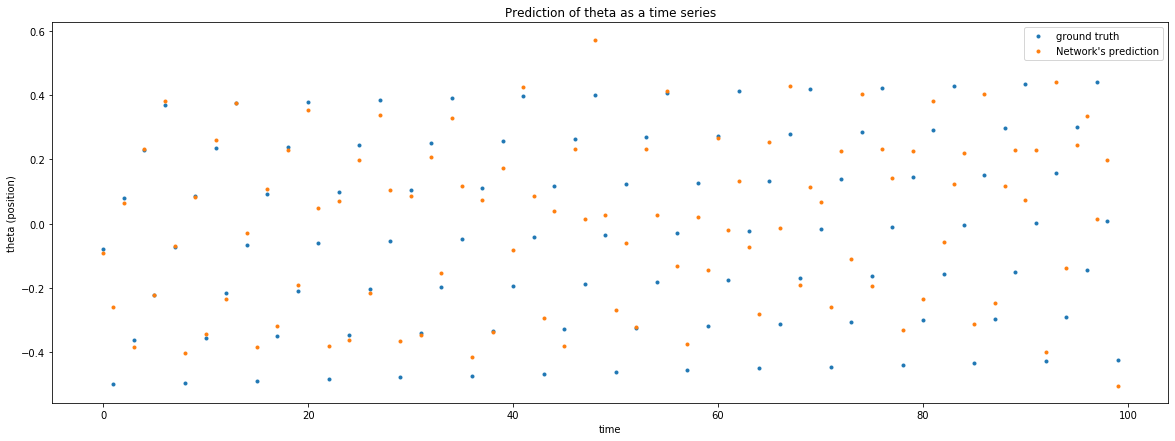

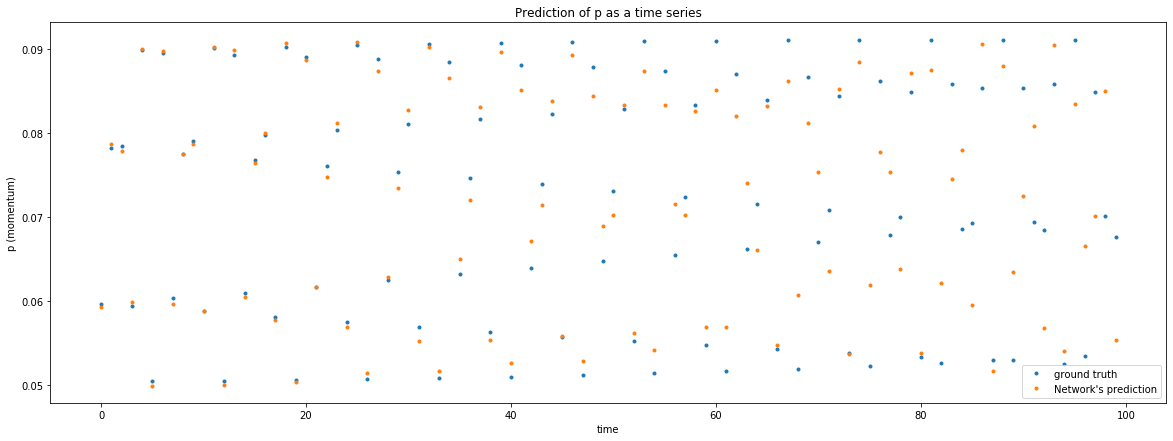

The test MSE for the 1-th dimension is 0.02205894353323259
The test MSE for the 2-th dimension is 2.7423178210392198e-05


In [40]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Now, the first predictions are quite as desired but it then degenerates quite fast.

**Take N=5000**.

In [41]:
Network.N = 5000
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0004975762283629925
The training MSE for the 2-th dimension is 2.6205082135940615e-09


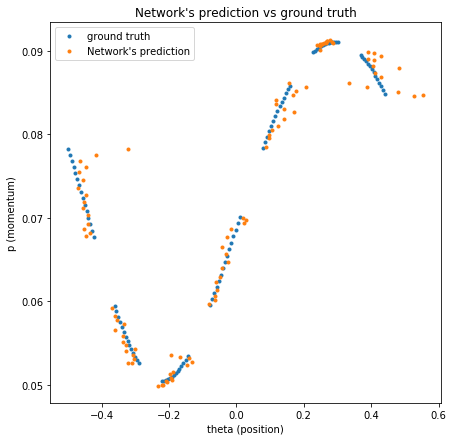

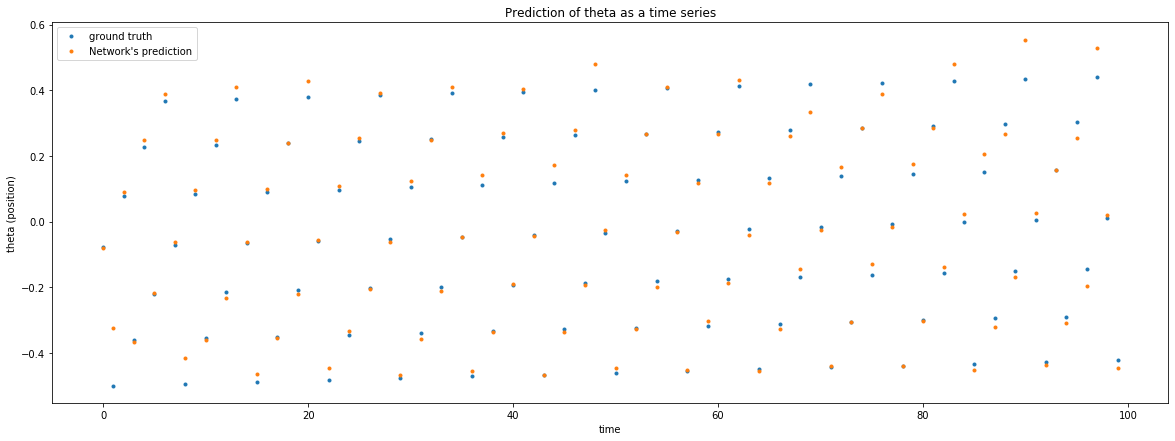

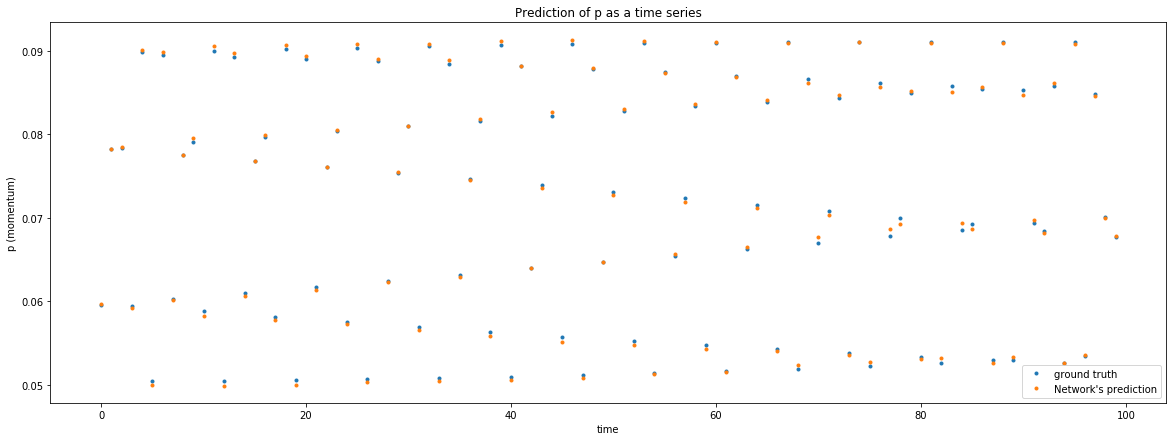

The test MSE for the 1-th dimension is 0.0011012255569374022
The test MSE for the 2-th dimension is 1.3133920879049823e-07
The 84 NRMSE for the 1-th dimension is 1.9638223245452093
The 84 NRMSE for the 2-th dimension is 0.7748664382935557


In [42]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

In this case, the predictions are quite accurate although not as much as when N=3000. This leads us to think that a huge number of nodes does not guarantee a good performance. On the other hand, notice that $\text{NRMSE}_{84}$ of the $p$ variable has decreased a little bit, which implies an improvement on the long term predictions.

Let us now recover $N=3000$ in order to be consistent in the following experiments.

In [43]:
Network.N = 3000
Network.L = 2
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

## 3.2 Role played by the input <a name="AddInput" ></a>

Recall that in [Section 2](#TrainingNetwork) we considered a constant input equal to 0.5 in order to encourage a wider variety of trajectories. Let us now empirically check what happens when taking other input values, including the 0 value.

**Take u(n)=0. That is, remove the input.**

In [48]:
Network.u = np.array([[0]])


Kick value K=0.25

The training MSE for the 1-th dimension is 0.003965809145734339
The training MSE for the 2-th dimension is 1.4735094981744088e-06


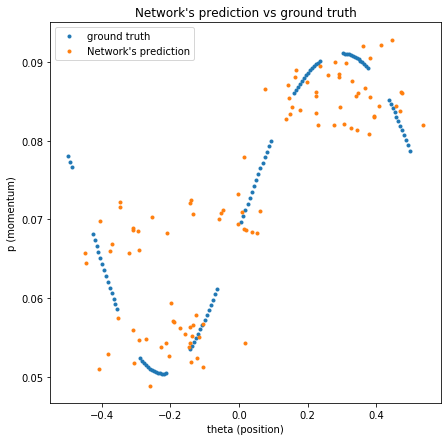

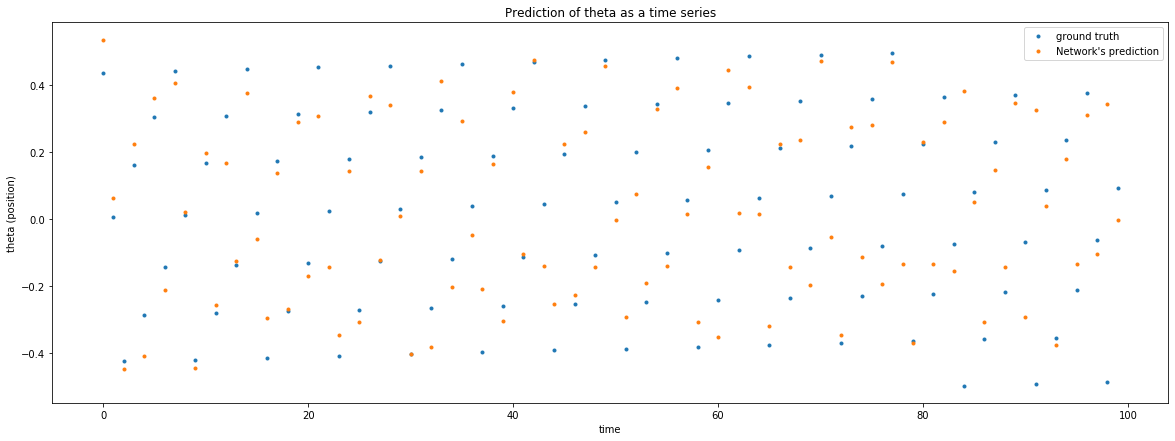

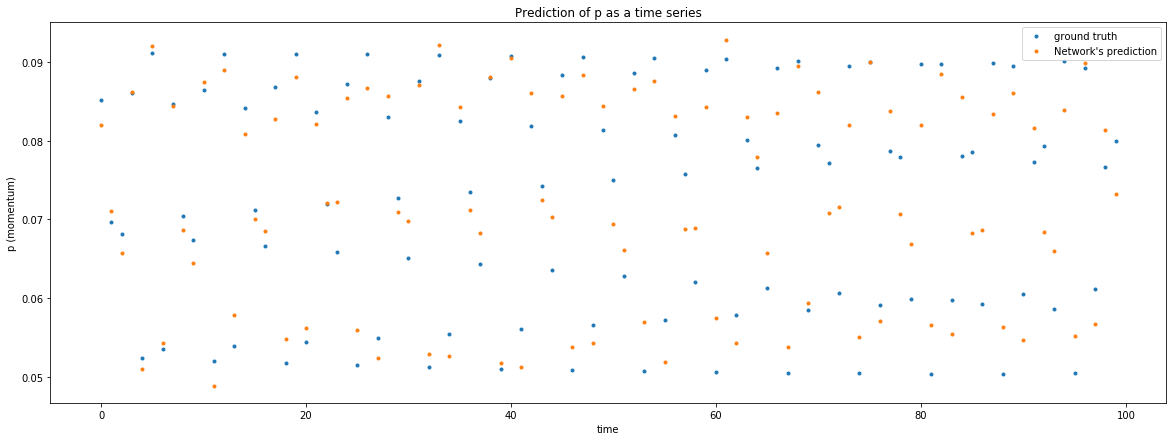

The test MSE for the 1-th dimension is 0.02807082882482782
The test MSE for the 2-th dimension is 2.0383311210089e-05


In [57]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

**Take u(n)=0.2**.

In [44]:
Network.u = np.array([[0.2]])


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0037258687312422974
The training MSE for the 2-th dimension is 1.5057985379407941e-06


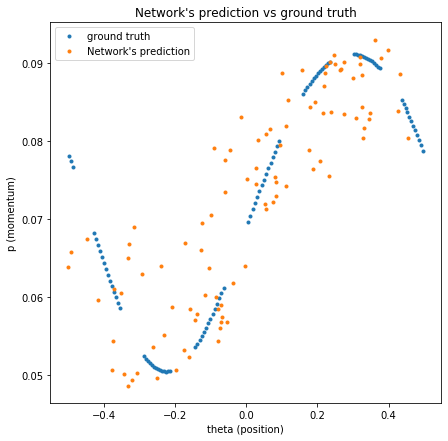

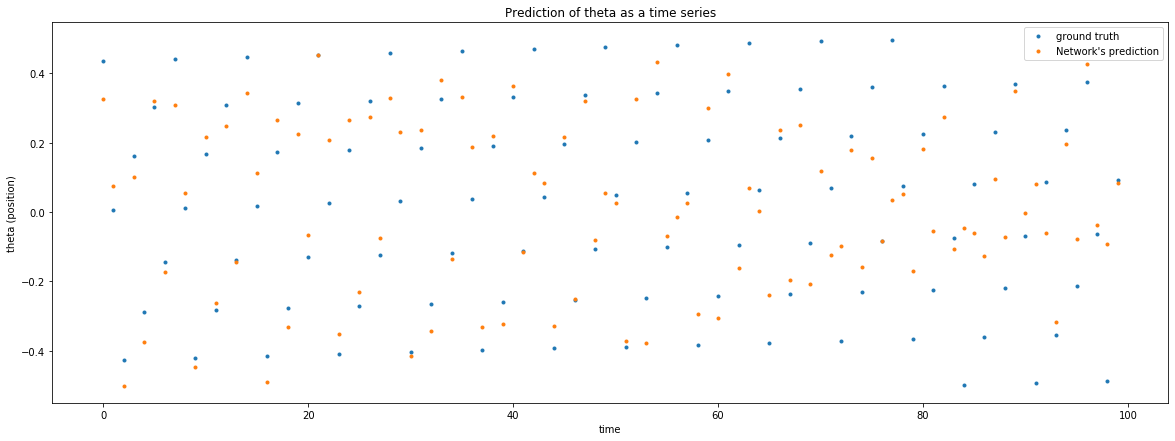

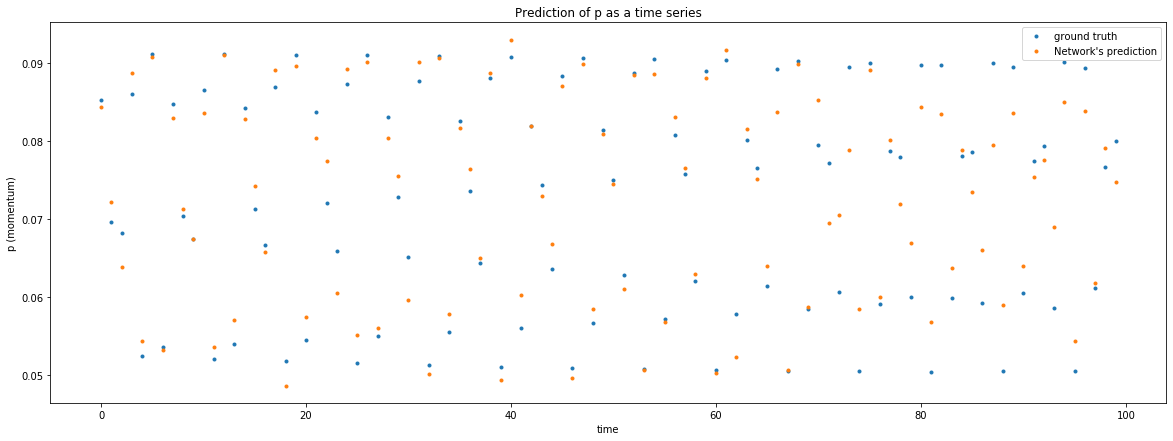

The test MSE for the 1-th dimension is 0.02575028306654295
The test MSE for the 2-th dimension is 1.4887383212431768e-05


In [60]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

**Take u(n)=0.7**.

In [46]:
Network.u = np.array([[0.7]])


Kick value K=0.25

The training MSE for the 1-th dimension is 0.004955941572333692
The training MSE for the 2-th dimension is 1.665127809622282e-08


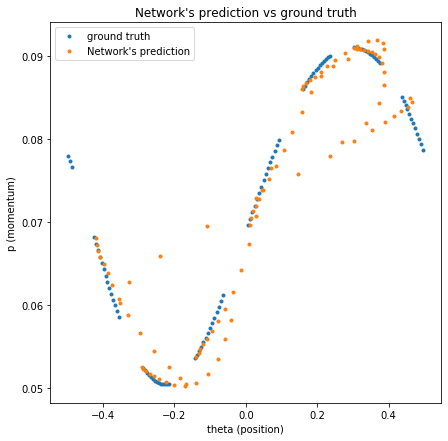

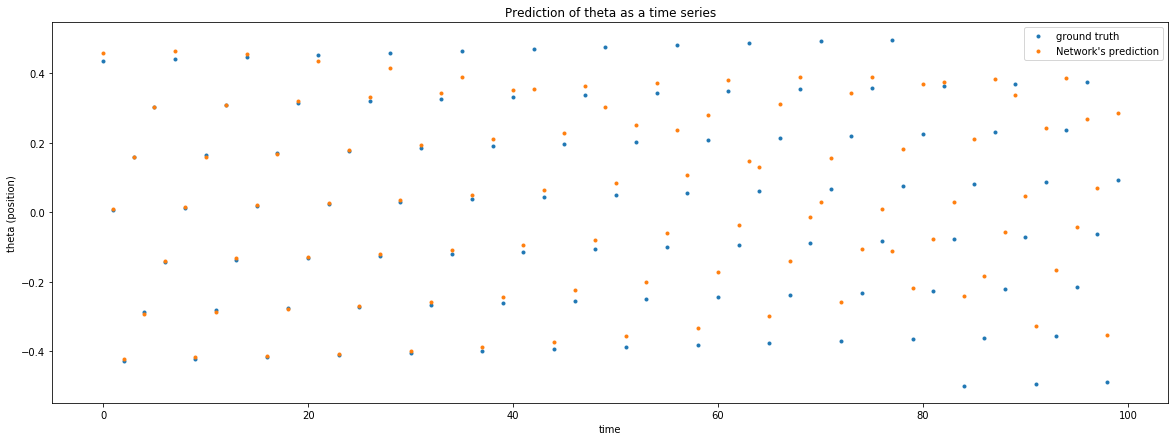

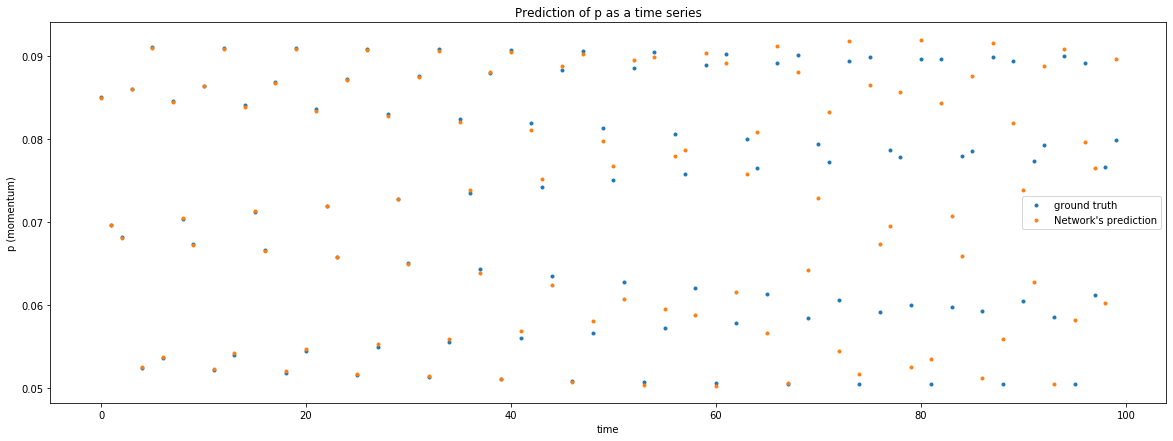

The test MSE for the 1-th dimension is 0.014307817506462421
The test MSE for the 2-th dimension is 2.4233838647682803e-05


In [63]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

In [50]:
#RECOVER THE ORIGINAL INPUT
Network.u = np.array([[0.5]])

By looking at the results of these experiments, we may infer that the introduction of some input increases the networks' predicting capability. However, it is important to properly determine the value of such input, since a too lower or too higher value may not provide the desired result.

## 3.3 Role played by the noise <a name="AddNoise" ></a>

In [Section 2](#TrainingNetwork), a centered Gaussian noise with standard deviation equal to 0.001 was introduced during training. Let us now see what happens when such parameters are changed, when we regard uniformly distributed noise instead of Gaussian or when the noise is removed.

**Remove the noise**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.004422407728413994
The training MSE for the 2-th dimension is 7.602897464703142e-09


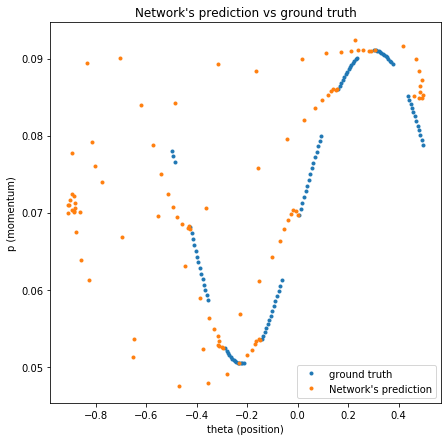

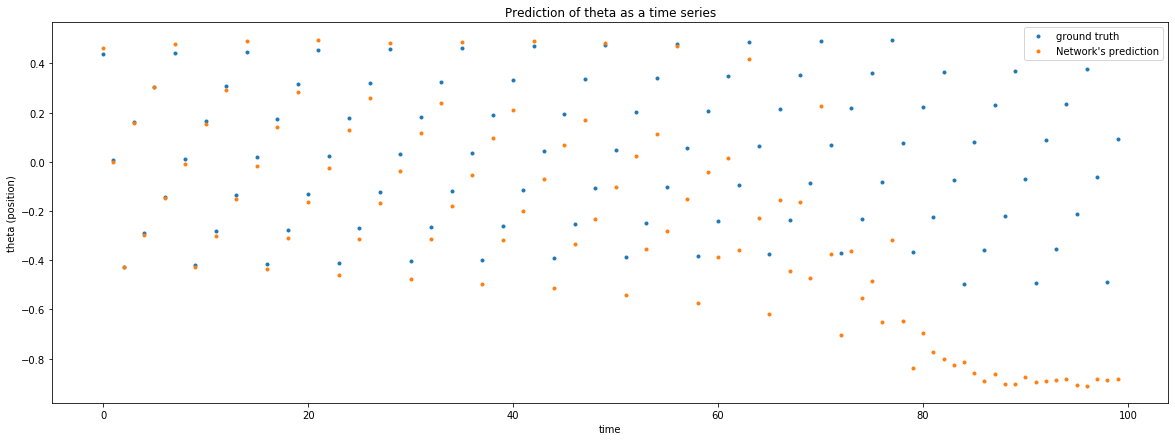

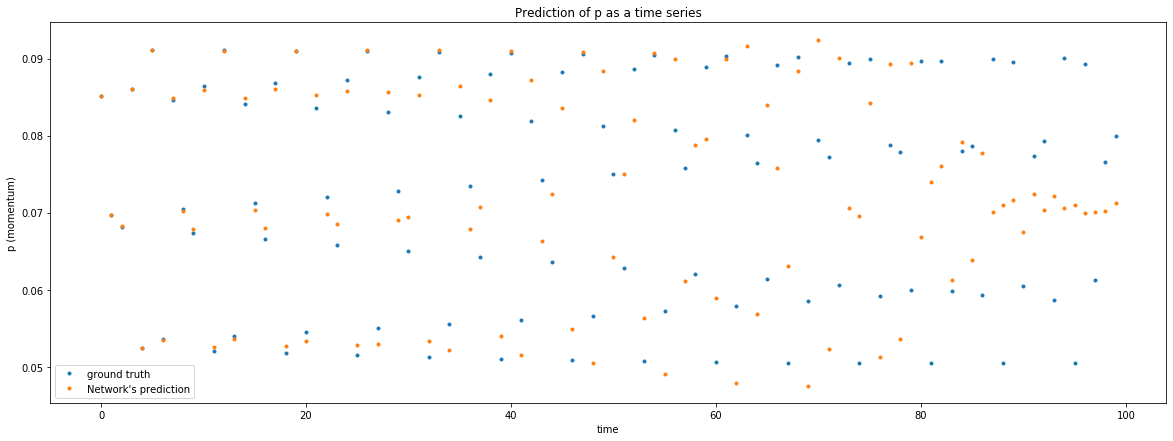

The test MSE for the 1-th dimension is 0.19569194184620123
The test MSE for the 2-th dimension is 0.00011967756192302089


In [69]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=False, stDev=0.001, regression_type='Ridge', regression_param=10)

Notice that the very first predictions are quite accurate. However, the lack of noise makes the predictions quickly degenerate. As we already saw when dealing with the Mackey Glass system (*MackeyGlass.ipynb*), the lack of noise leads the predictions to degenerate in the sense of ending up being constant or spiking between -1 and 1.

**Gaussian noise with std=0.1**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.004137029342938157
The training MSE for the 2-th dimension is 2.3337439047440174e-06


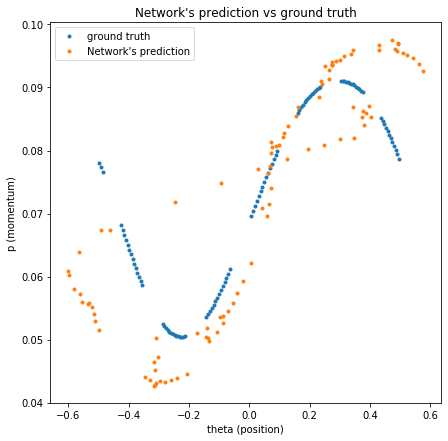

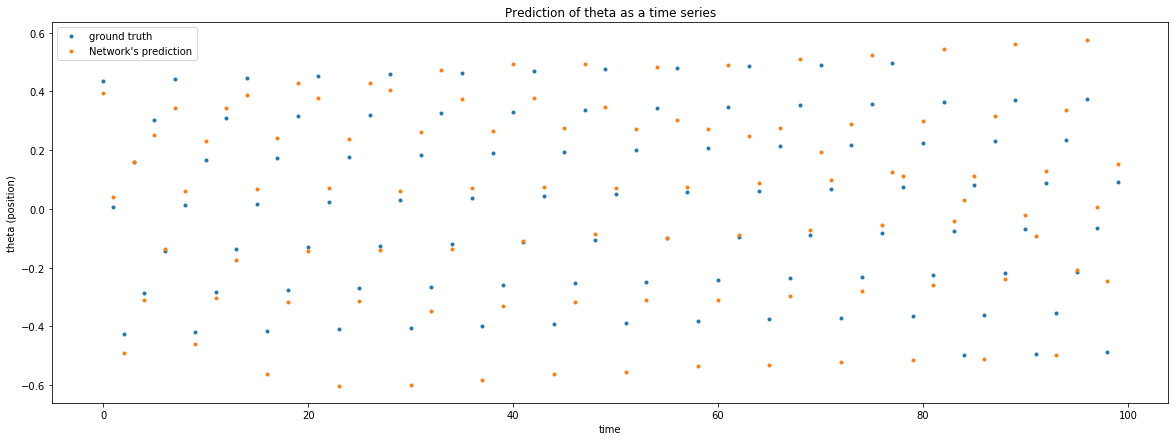

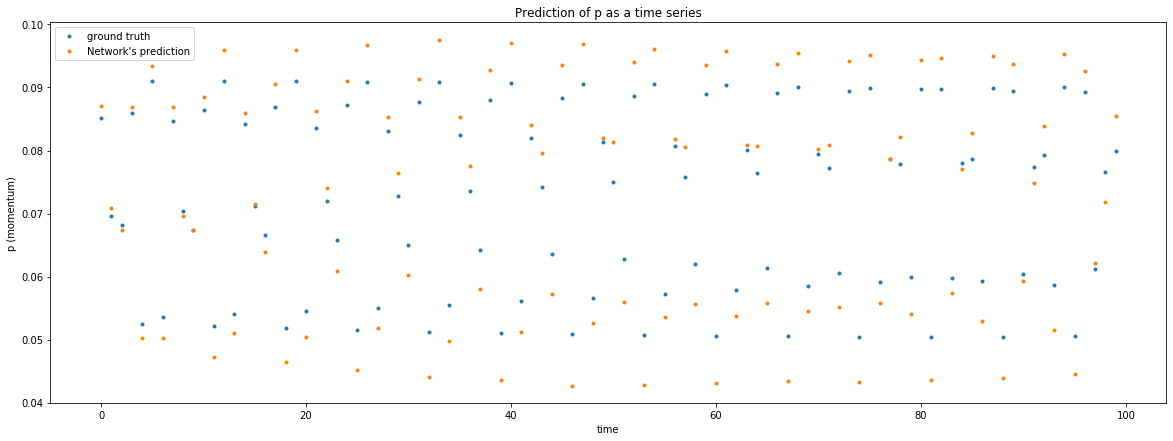

The test MSE for the 1-th dimension is 0.01638584279304322
The test MSE for the 2-th dimension is 2.180333059969495e-05


In [70]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.1, regression_type='Ridge', regression_param=10)

In this case, the influence of the noise is too big so as to properly learn the desired dynamics.

**Gaussian noise with std=0.00001**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0044223501159212615
The training MSE for the 2-th dimension is 7.603698238800016e-09


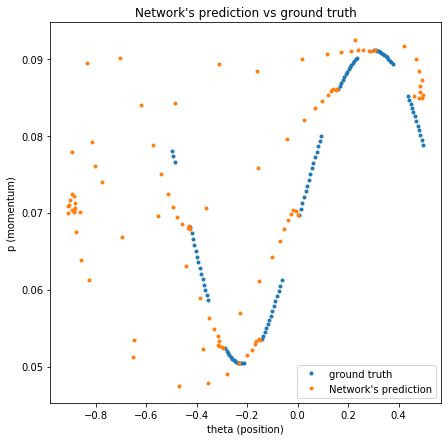

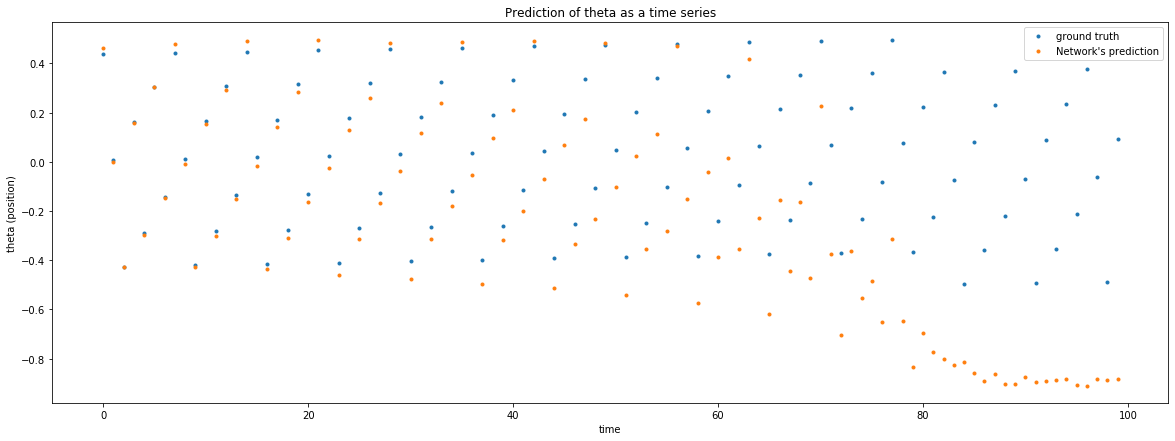

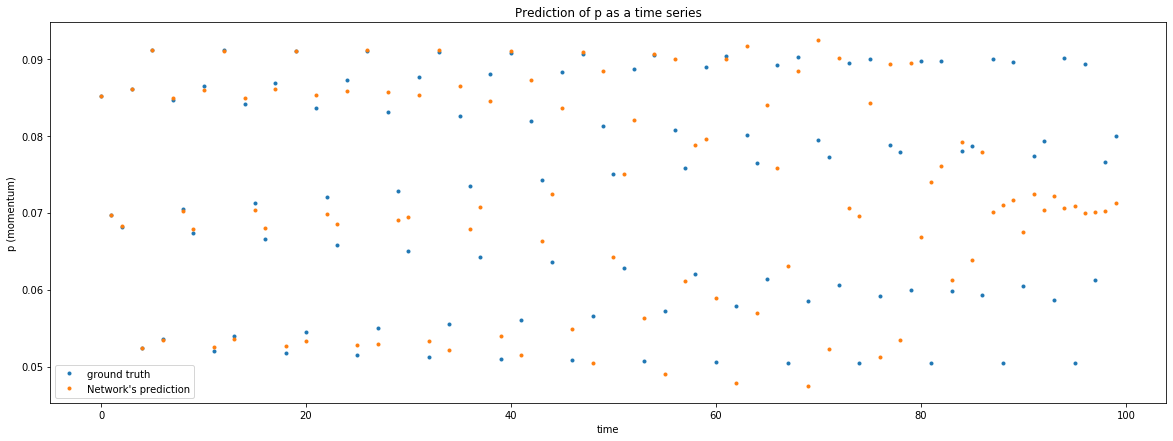

The test MSE for the 1-th dimension is 0.19536981489653124
The test MSE for the 2-th dimension is 0.00011967385171259098


In [71]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.00001, regression_type='Ridge', regression_param=10)

In this case, the noise was to subtle, thus the predictions behave similarly than in the case when no noise was inserted.

**Uniformly distributed noise within [-0.001,0.001]**

The main *Network* class is constructed in order to regard Gaussian noise. However, within the method *compute_nodes_trajectories* (in its second block of code), we can see the line were the Gaussian noise is defined. In the line above, there is a commented line regarding uniformly distributed noise. Therefore, we just need to comment the Gaussian noise line and uncomment the uniformly distributed noise line. The parameter *stDev* will give the upper boundary of the symmetrical interval from which the noise is going to be uniformly sampled.


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0035225145759350154
The training MSE for the 2-th dimension is 6.7708729447594526e-09


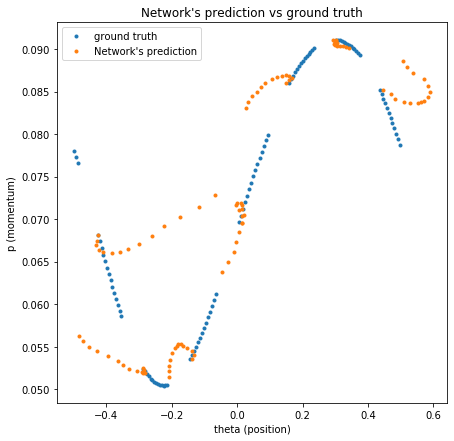

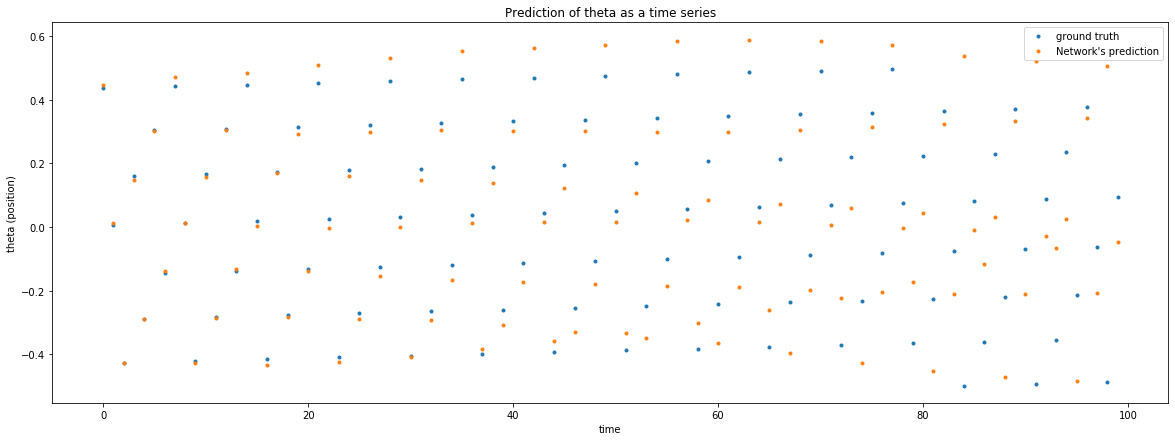

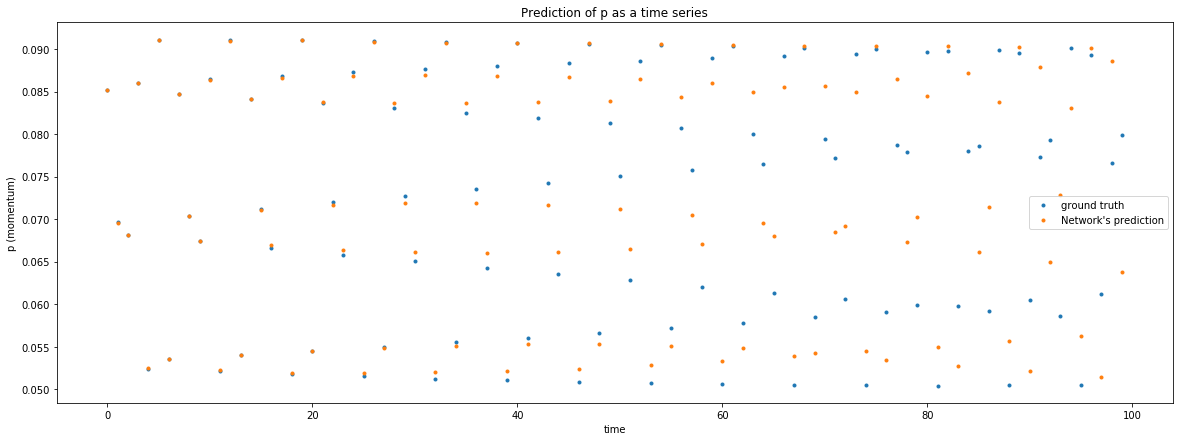

The test MSE for the 1-th dimension is 0.040481728393515395
The test MSE for the 2-th dimension is 2.6014936599503034e-05


In [7]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

At first, the predictions are quite accurate but, afterwards, they degenerate. This leads us to think that the influence of the noise is too subtle. Thus, we need to narrow a little bit the interval.

**Uniformly distributed noise within [-0.01,0.01]**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.002059312379744441
The training MSE for the 2-th dimension is 3.062217803923432e-08


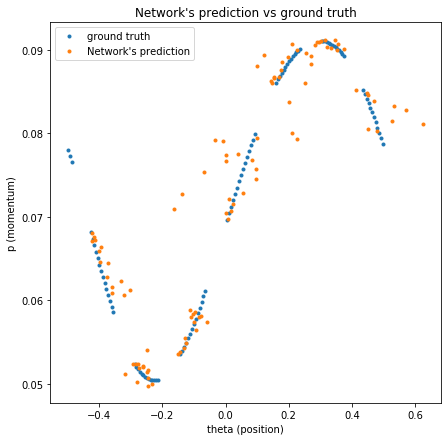

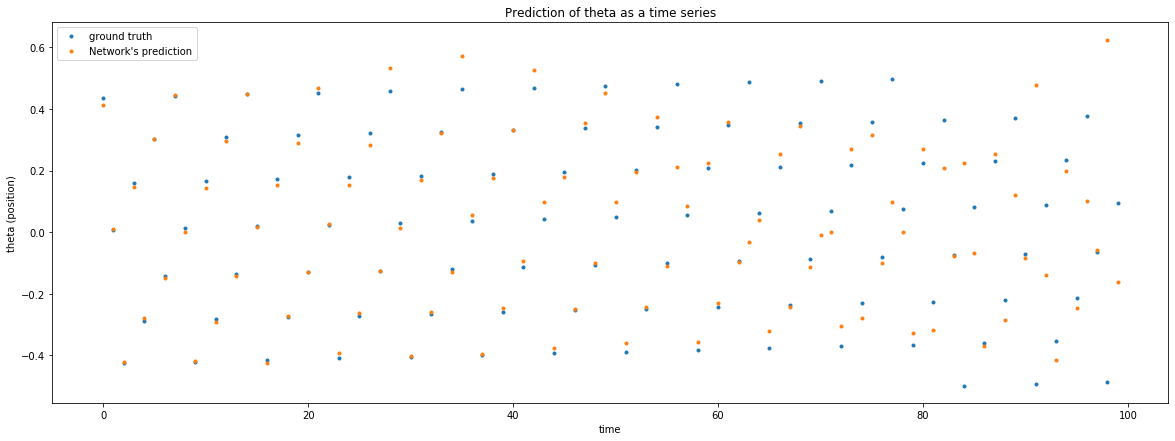

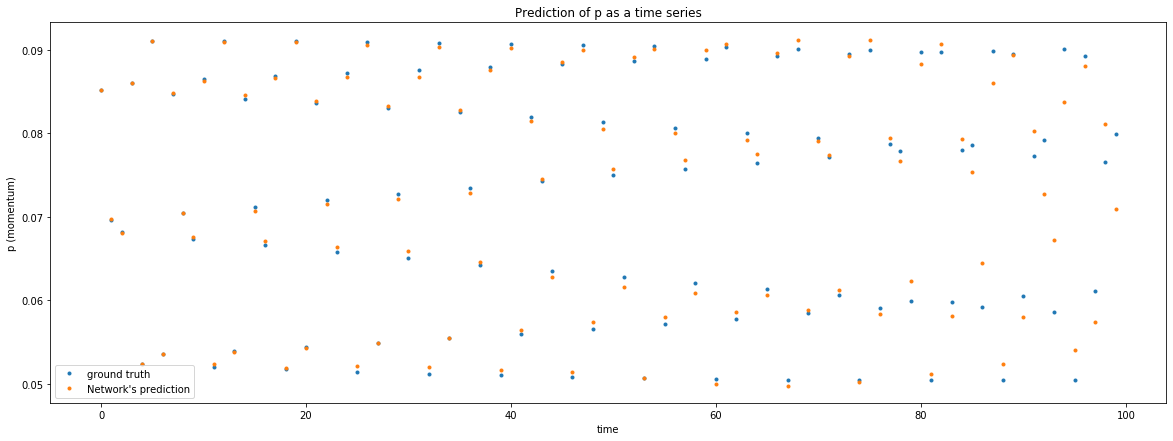

The test MSE for the 1-th dimension is 0.03840348633013815
The test MSE for the 2-th dimension is 4.009011776619317e-06


In [10]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.01, regression_type='Ridge', regression_param=10)

The results are better than the previous ones but they are not good enough. The uniformly distributed noise do not appear to be a good choice.

Therefore, the introduction of the appropriate noise may prevent the predictions from degenerating. Its influence do not have to be too suble nor too strong.

## 3.4 Formula for updating the reservoir <a name="UpdRes" ></a>

In [Section 2](#TrainingNetwork), we updated the reservoir by means of the following equation

$$
x(n+1)=\tanh\left(W^\text{in}u(n)+Wx(n)+W^\text{back}y^\text{teach}[:,n]+\nu[:,n]\right)
$$

where $y_\text{teach}$ is replaced by the output of the network ($y$) during testing time. This strategy, which is the most common one, was already implemented when coping with other tasks (*Periodic_Spiking_Dynamics.ipynb*). However, recall that when dealing with the Mackey-Glass system, the updating was done as follows

$$
x(n+1)=(1-\delta Ca)x(n)+\delta C\tanh\left(Wx(n)+W^\text{back}y^\text{teach}[:,n]\right),
$$

where $\delta$=1, $C$=0.49 and $a$=0.9. Notice that, when $\delta=C=a=1$, the second formula reduces to the first one. 

Let us now see the behavior of the network when the updating is performed in this second way. Since we have already checked the importance of inserting some noise, the update is going to be as follows:

$$
x(n+1)=(1-\delta Ca)x(n)+\delta C\tanh\left(Wx(n)+W^\text{back}y^\text{teach}[:,n]+\nu[:,n]\right),
$$

where $\nu$ is going to be a centered Gaussian noise.

In [7]:
Network.delta = 1
Network.C = 0.49
Network.a = 0.9


Kick value K=0.25

The training MSE for the 1-th dimension is 0.01958832810145098
The training MSE for the 2-th dimension is 2.9005402786815383e-05


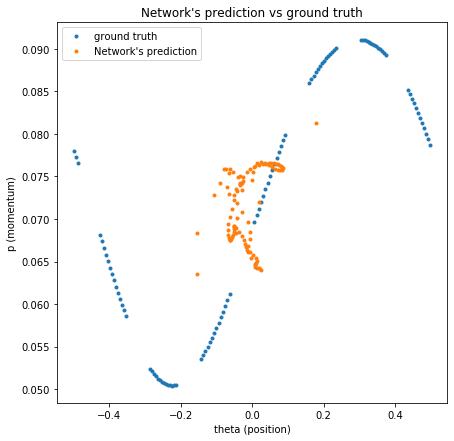

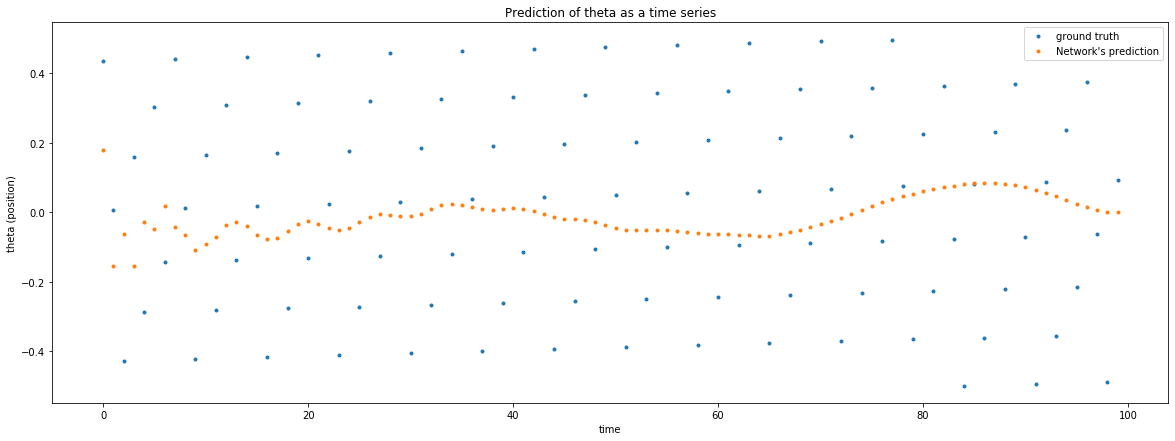

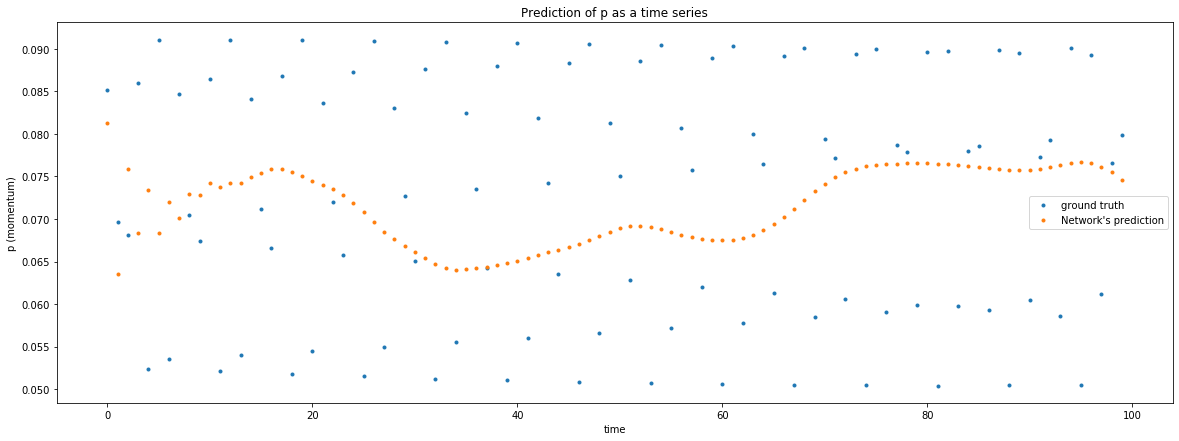

The test MSE for the 1-th dimension is 0.09062891630935525
The test MSE for the 2-th dimension is 0.00022677107962415437


In [8]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

Notice the poor performance of this approach.

In [9]:
#UNDO THE CHANGE IN ORDER TO RECOVER THE ORIGINAL VALUES
Network.delta = 1
Network.C = 1
Network.a = 1

## 3.5 Formula for obtaining the output <a name="ObtOut" ></a>

In [Section 2](#TrainingNetwork), the output is computed from the internal states of the reservoir as follows

$$
y(n) = W^\text{out}\tilde{x}(n),
$$

where 

$$
\tilde{x}(n):=\begin{pmatrix}x(n)_{1:\frac{N}{2}}\\x(n)^2_{\frac{N}{2}+1:N}\end{pmatrix}
$$

stands for the vertical concatenation of vectors $x(n)_{1:\frac{N}{2}}$ and $x(n)^2_{\frac{N}{2}+1:N}$. However, this was not the first strategy that we tried. Let us now develop the different approaches we tried as well as the different performances they gave.

### 3.5.1 Output as a linear combination <a name="LinComb" ></a>

At first, we tried to compute $y$ as a linear combination of the states of the reservoir. That is,

$$
y(n) = W^\text{out}x(n).
$$

Let us now see the behavior of this approach. In order to run this procedure, we need to modify the *augmented_x*  method (within the *Network* class). That is, the function should perform an identity:
```python
def augmented_x(self, M):
    return M
```


Kick value K=0.25

The training MSE for the 1-th dimension is 0.002680178827129921
The training MSE for the 2-th dimension is 5.5351826301414366e-09


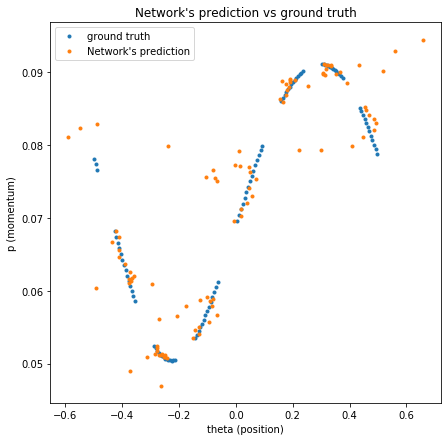

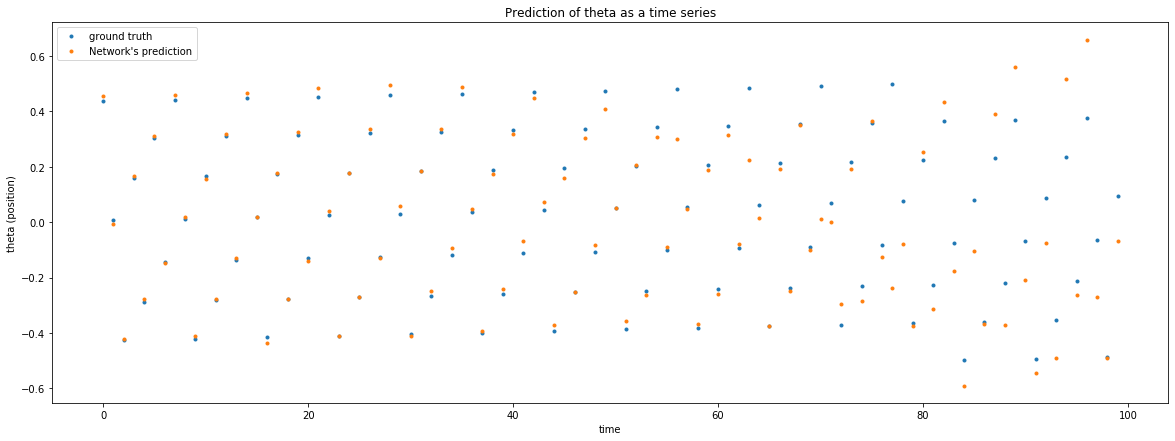

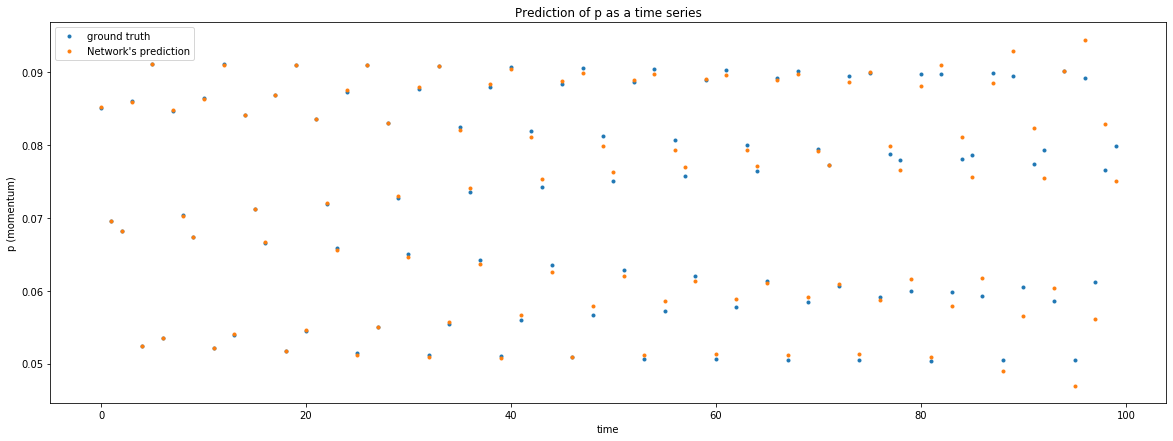

The test MSE for the 1-th dimension is 0.01384128121808511
The test MSE for the 2-th dimension is 2.6517459338279205e-06
The 84 NRMSE for the 1-th dimension is 21.577370411445138
The 84 NRMSE for the 2-th dimension is 6.336271750699035


In [7]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

The predictions degenerate faster. Both $\text{NRMSE}_{84}$ are too large.

### 3.5.2 Output as a polynomial of degree 3 <a name="Poly3" ></a>

We have just seen that computing $y$ as a linear combination of the internal states of the reservoir is not a good idea. On the other hand, we already saw in [Section 2](#TrainingNetwork) that the performance of the network is much improved by obtaining $y$ as a polynomial of degree 2 of the states. Let us now see what happens if we try to compute it as a ploynomial of degree 3. In other words,

$$
y(n) = W^\text{out}\tilde{x}(n),
$$

where 

$$
\tilde{x}(n):=\begin{pmatrix}x(n)_{1:\frac{N}{3}}\\x(n)^2_{\frac{N}{3}+1:\frac{2N}{3}}\\x(n)^3_{\frac{2N}{3}+1:N}\end{pmatrix}
$$

stands for the vertical concatenation of the three vectors.

Let us now see the behavior of this approach. In order to run this procedure, we need to modify the *augmented_x*  method (within the *Network* class). That is, the function should perform an identity:
```python
def augmented_x(self, M):
    aux1 = M[:,:int(self.N/3)]
    aux2 = M[:,int(self.N/3):int(2*self.N/3)]
    aux3 = M[:,int(2*self.N/3):]    
    return np.hstack((aux1, aux2**2, aux3**3))
```


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0005510472157134353
The training MSE for the 2-th dimension is 3.0249730973324577e-08


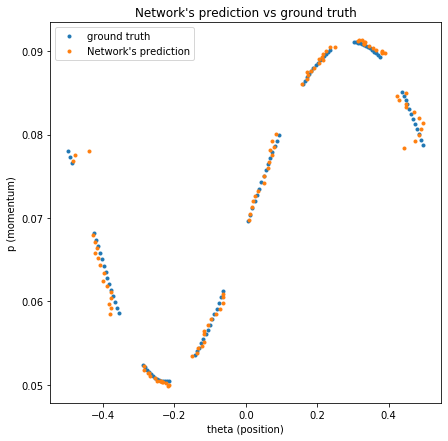

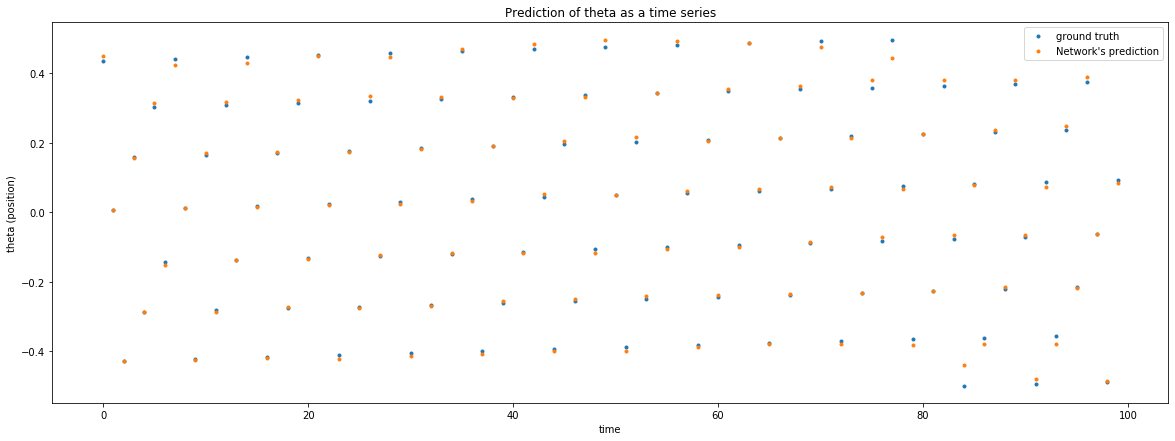

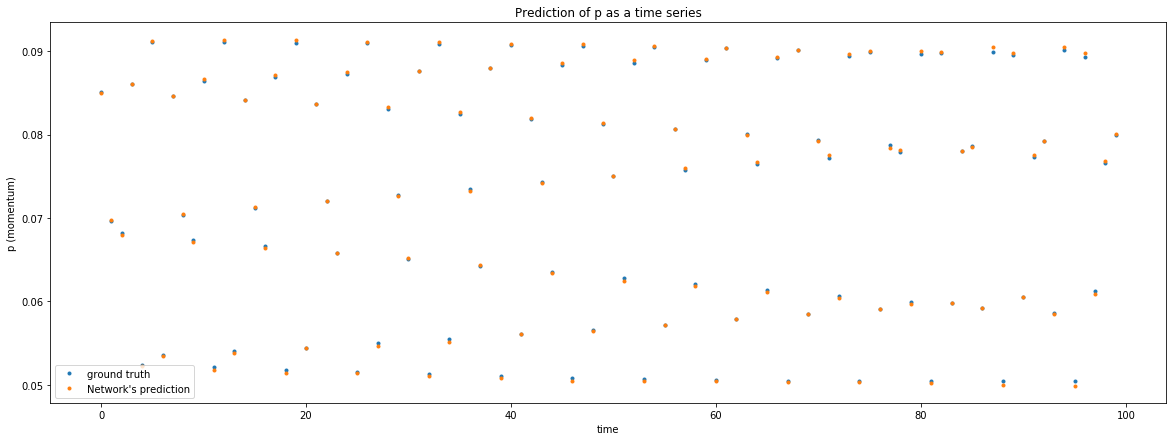

The test MSE for the 1-th dimension is 0.0001414387734780943
The test MSE for the 2-th dimension is 4.757156686731325e-08
The 84 NRMSE for the 1-th dimension is 1.5754015367510243
The 84 NRMSE for the 2-th dimension is 1.2866930020642606


In [8]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

This time, the predictions are much better than in the previous case. The performance is quite similar to the one got in [Section 2](#TrainingNetwork).

## 3.6 Loss function <a name="Loss" ></a>

In [Section 2](#TrainingNetwork), the learning consited on a ridge regression. Thus, the function to minimize was

$$
\text{RIDGE} = ||\tanh^{-1}\left(y^\text{teach}\right)-W^\text{out}\tilde{x}||_2^2+\alpha||W^\text{out}||_2^2,
$$

where $\alpha=10$. Let us now see what happens if we modify this function.

**Ridge regression with $\alpha$=0.1**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0024503834473072333
The training MSE for the 2-th dimension is 8.284850276425456e-10


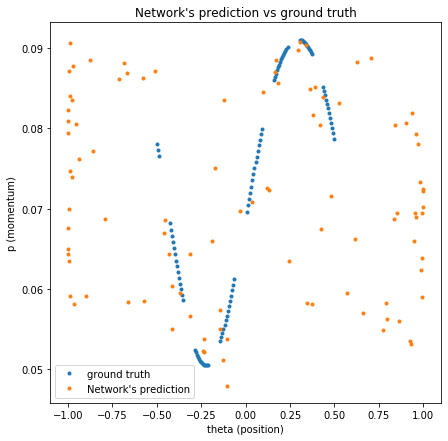

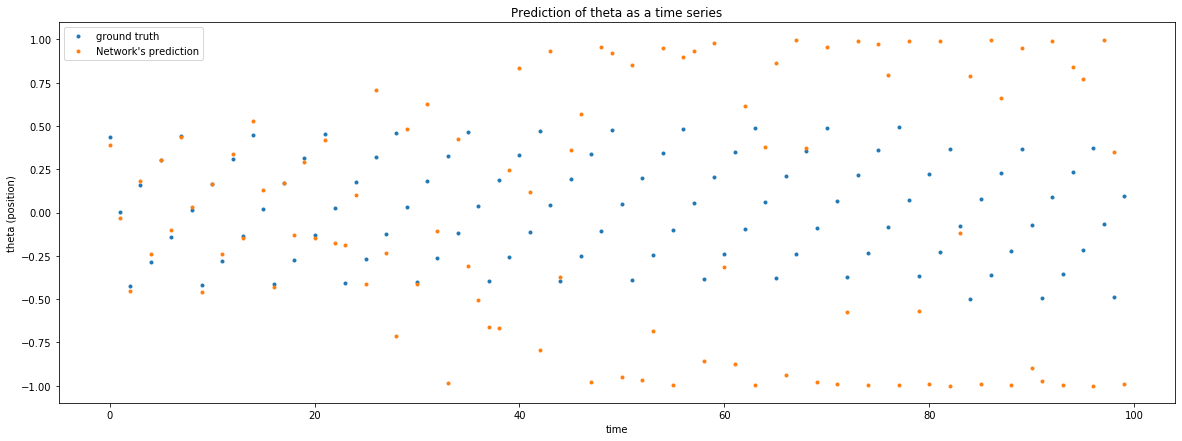

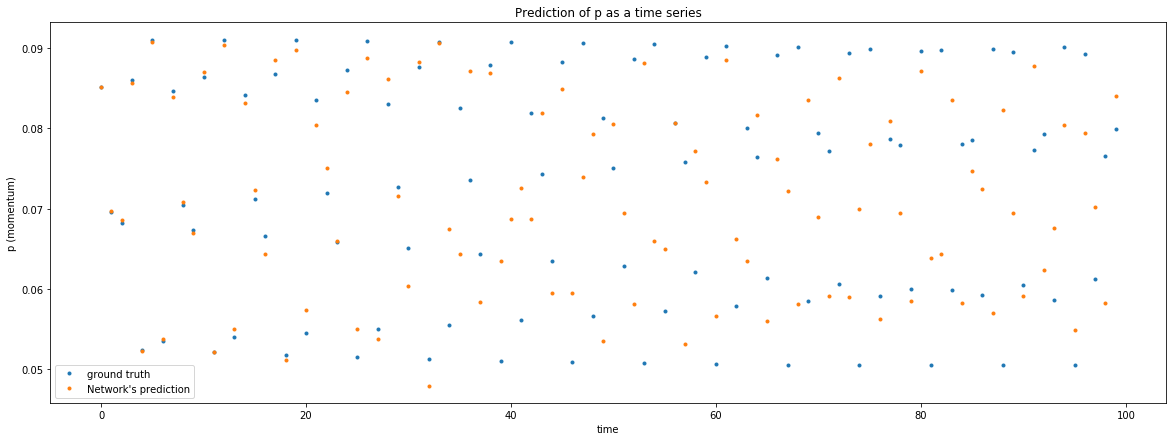

The test MSE for the 1-th dimension is 0.5487655069507772
The test MSE for the 2-th dimension is 0.00018667591892776079


In [8]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=0.1)

Poor performance. The value of $\alpha$ was too small, so it does not penalize huge values of $||W^\text{out}||_2$ as required.

**Ridge regression with $\alpha$=30**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.00483131627515511
The training MSE for the 2-th dimension is 2.068262624959385e-08


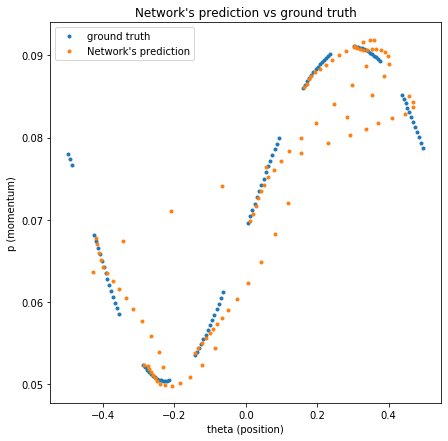

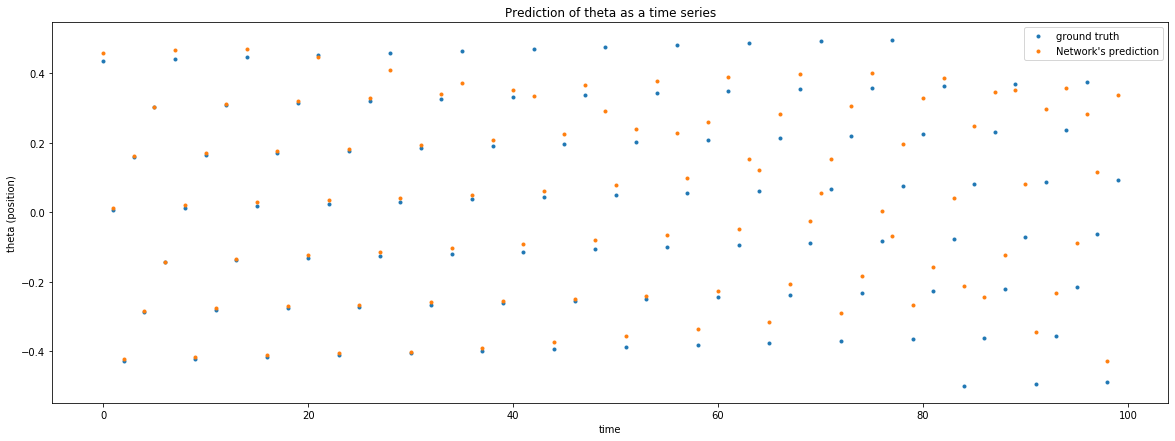

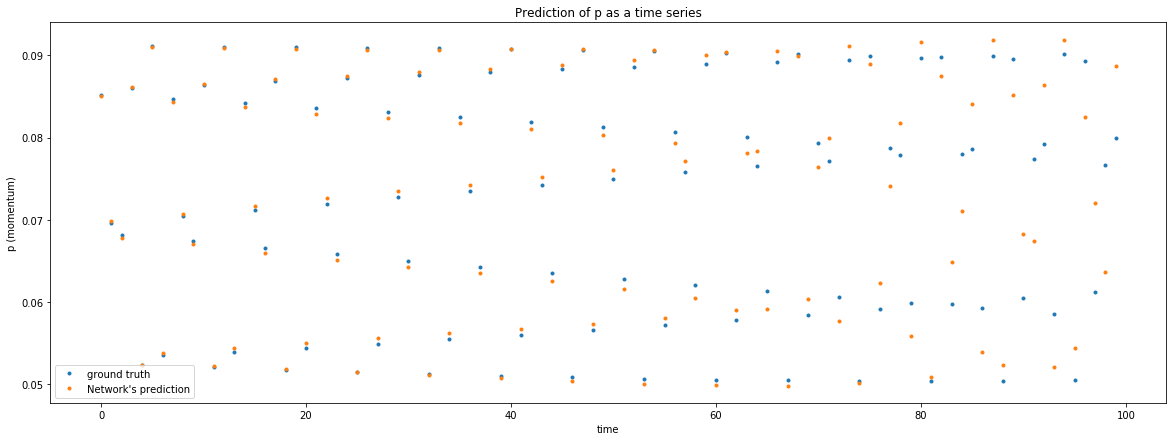

The test MSE for the 1-th dimension is 0.012609413009569337
The test MSE for the 2-th dimension is 9.822244585679526e-06


In [9]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='Ridge', regression_param=30)

The value of $\alpha$ is now too big.

**Linear regressions. Classical MSE as the loss function**


Kick value K=0.25

The training MSE for the 1-th dimension is 0.0012777438630193708
The training MSE for the 2-th dimension is 2.4834460263034104e-10


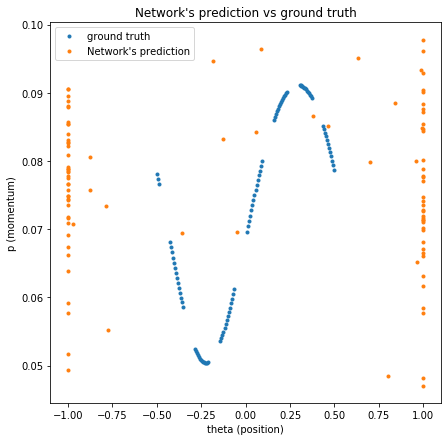

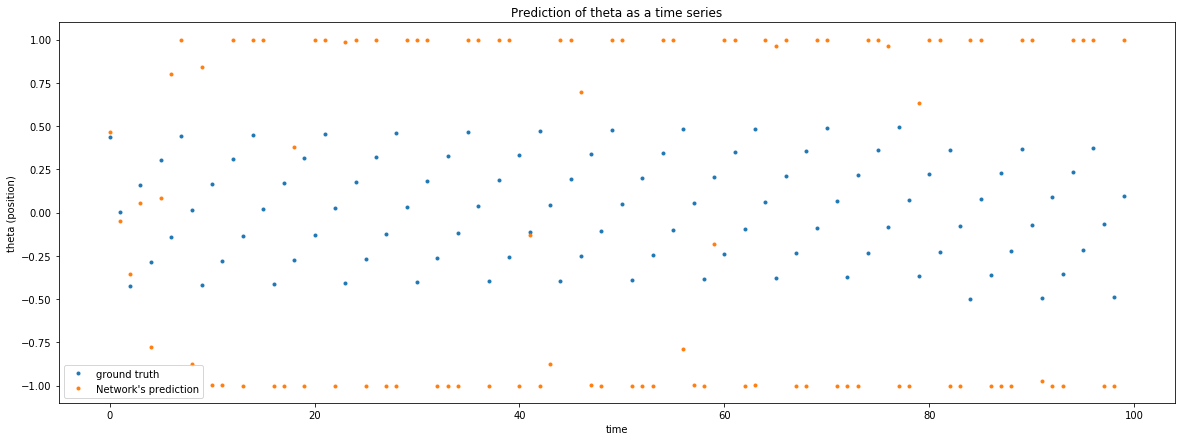

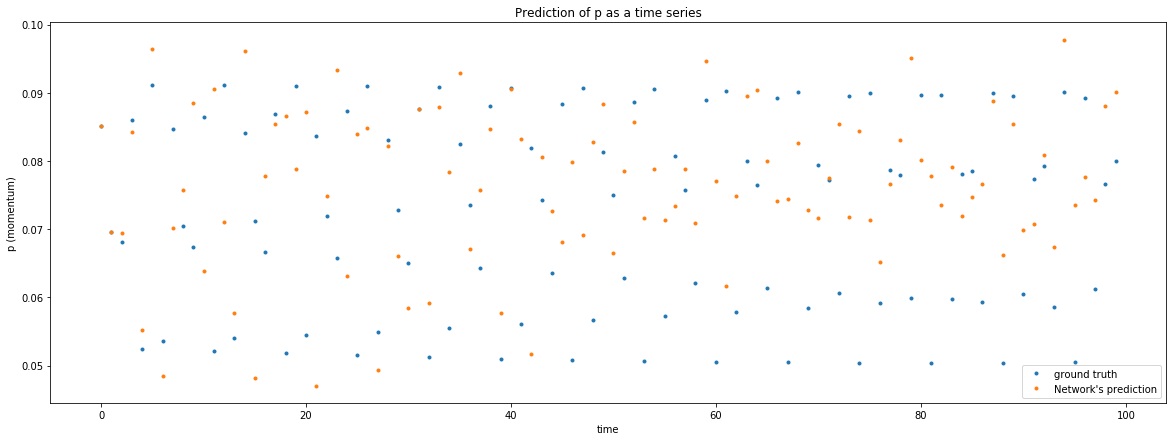

The test MSE for the 1-th dimension is 0.9183023080556383
The test MSE for the 2-th dimension is 0.0002745399581898402


In [10]:
#TRAINING AND TESTING
Network.train_test_k(ic=[1,3.5], k_list=[0.25], t_dismiss=Network.T, t_autonom=100, NRMSE=False, noise=True, stDev=0.001, regression_type='LinearRegression')

By far, this approach provides the worst result. It is clear that the MSE is not a good choice for our particular task. 